In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# Sklearn and TensorFlow related imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# CatBoost and TensorFlow Decis
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from catboost import CatBoostRegressor

from sklearn.preprocessing import OrdinalEncoder  # For tree-based models
from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import mutual_info_regression

import optuna

In [2]:
#Load datasets
df = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


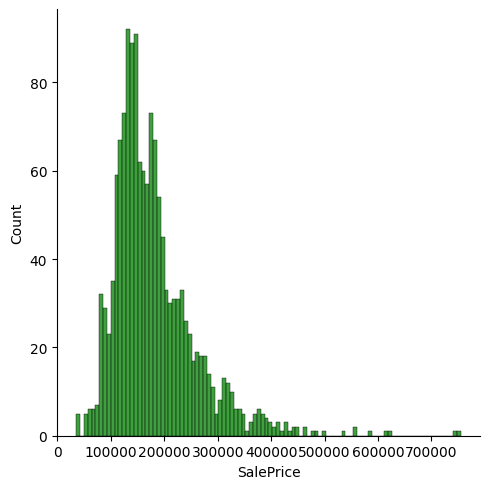

In [3]:
print(df.SalePrice.describe())

sns.displot(df["SalePrice"], color= 'g', bins = 100)

In [4]:
df_num = df.select_dtypes(include=['float64','int64'])
df_num.head()

Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  WoodDeckSF  OpenPorchSF  \
0          2003       196.0         706  ...           0           61   
1          1976         0.0         978  ...         298            0   
2          2002       162.0         486  ...           0           42   
3          1970         0.0         216  ...           0           35   
4          2000       350.0         655  ...         192           84   

   EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  \
0              0          0            0         0        0       2    2008   
1              0          0            0         0        0       5    2007   
2              0          0            0         0        0       9    2008   
3            272          0            0         0        0       2    2006   
4              0          0            0         0        0      12    2008   

   SalePrice  
0     208500  
1     181500  
2     223500  
3     140000  
4     250000  

[5 rows x 38 columns]

array([[<AxesSubplot: title={'center': 'MSSubClass'}>,
        <AxesSubplot: title={'center': 'LotFrontage'}>,
        <AxesSubplot: title={'center': 'LotArea'}>,
        <AxesSubplot: title={'center': 'OverallQual'}>,
        <AxesSubplot: title={'center': 'OverallCond'}>,
        <AxesSubplot: title={'center': 'YearBuilt'}>],
       [<AxesSubplot: title={'center': 'YearRemodAdd'}>,
        <AxesSubplot: title={'center': 'MasVnrArea'}>,
        <AxesSubplot: title={'center': 'BsmtFinSF1'}>,
        <AxesSubplot: title={'center': 'BsmtFinSF2'}>,
        <AxesSubplot: title={'center': 'BsmtUnfSF'}>,
        <AxesSubplot: title={'center': 'TotalBsmtSF'}>],
       [<AxesSubplot: title={'center': '1stFlrSF'}>,
        <AxesSubplot: title={'center': '2ndFlrSF'}>,
        <AxesSubplot: title={'center': 'LowQualFinSF'}>,
        <AxesSubplot: title={'center': 'GrLivArea'}>,
        <AxesSubplot: title={'center': 'BsmtFullBath'}>,
        <AxesSubplot: title={'center': 'BsmtHalfBath'}>],
     

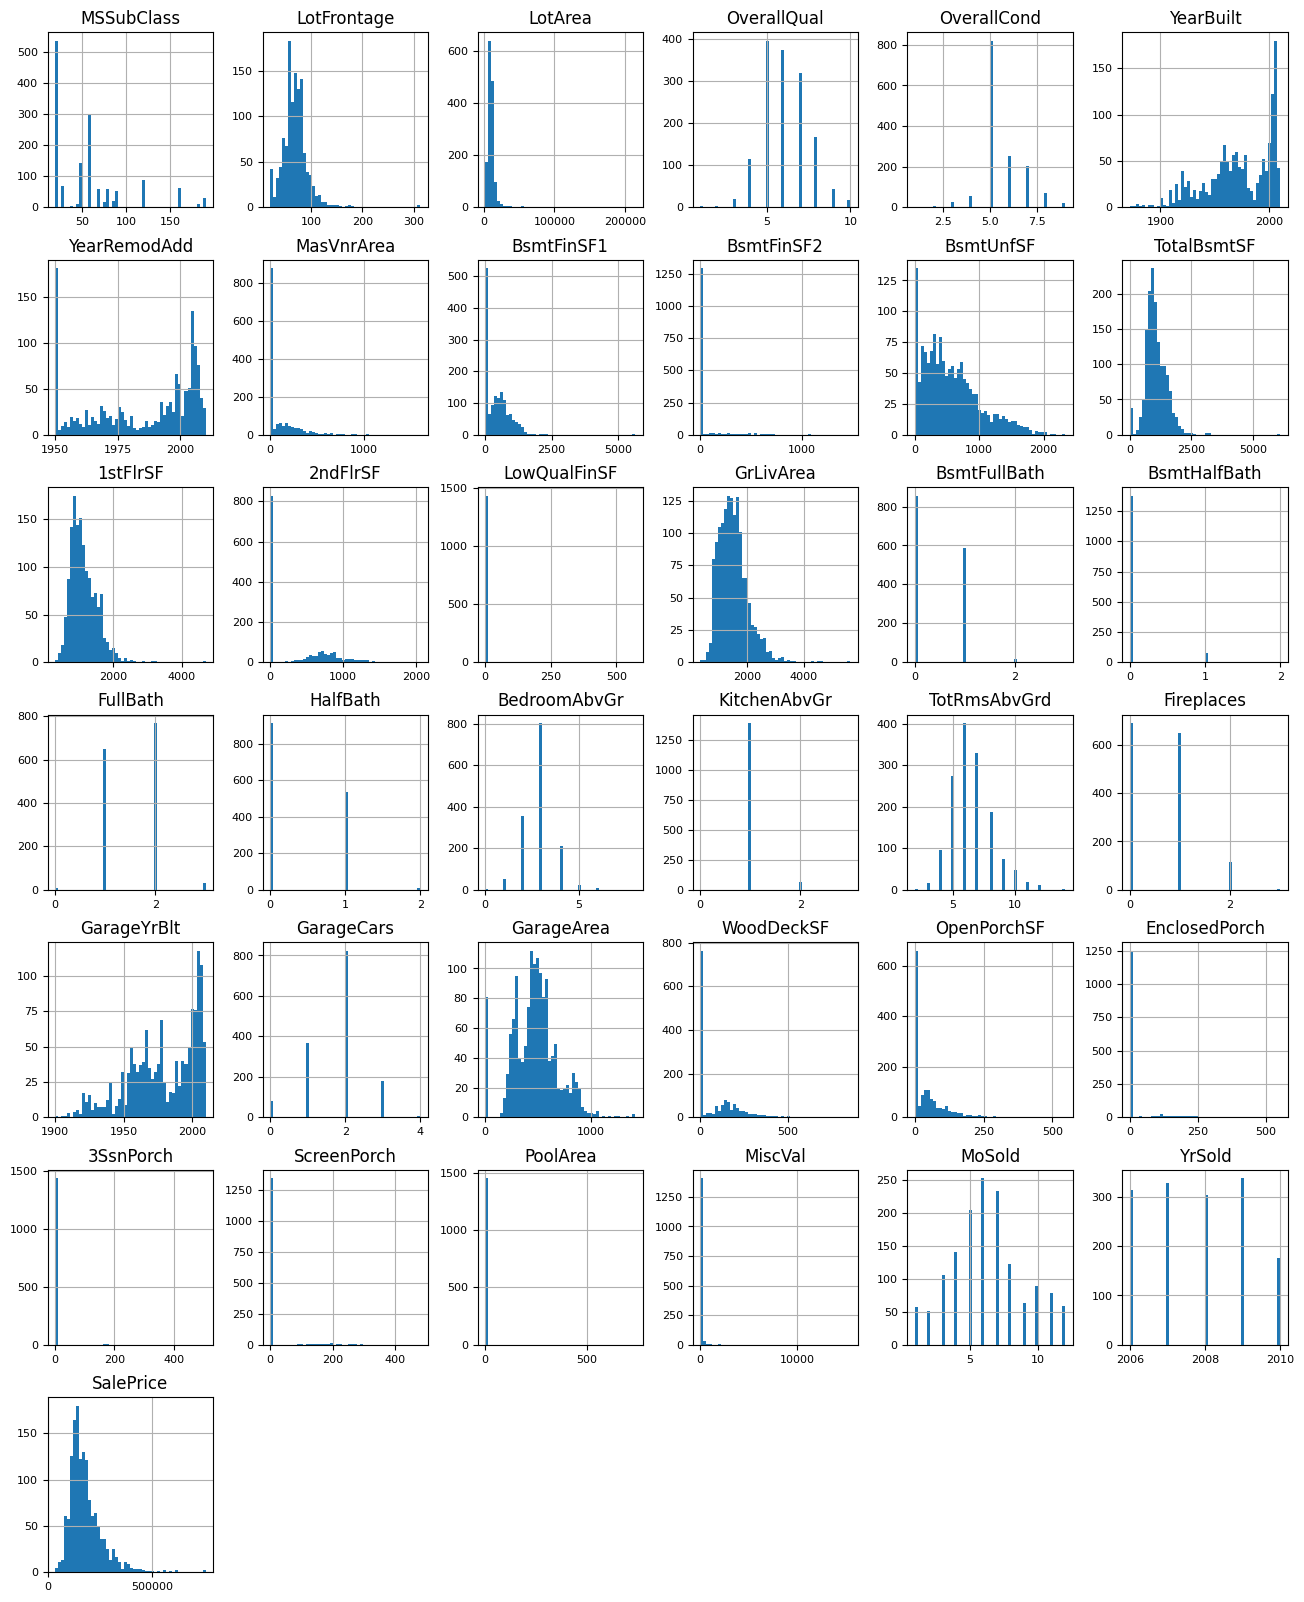

In [5]:
df_num = df_num.drop(columns = ['Id'])
df_num.hist(figsize=(16,20), bins =50, xlabelsize =8, ylabelsize=8)


--------Start of df2 transformations--------

In [6]:
#Encode categ
def encode_categ(df):
    for col in df.select_dtypes(include=["object", "category"]).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
    return df

def fillnan(X):
                    # Check if X is a DataFrame, and apply fillna
    if isinstance(X, pd.DataFrame):
        return X.fillna("nan")
    else:
        raise TypeError("Input must be a pandas DataFrame or a numpy array")
                # If the data isn't a DataFrame, just apply fillna to numpy array
    
#Calculate mutual information
def mutualInfo(df):
    # Calculate mutual information
    mi_scores = mutual_info_regression(df.drop(columns = ["SalePrice"]), df.SalePrice, random_state=42)
    # Create a results dataframe
    mi_df = pd.DataFrame({'Feature': df.drop(columns = ['SalePrice']).columns, 'MI Score': mi_scores})
    mi_df = mi_df.sort_values(by='MI Score', ascending=False)

    #Plot mutual Info.
    plt.figure(figsize=(10, 6))
    sns.barplot(x='MI Score', y='Feature', data=mi_df.head(20), palette='viridis')
    plt.title('Top 20 Features by Mutual Information Score')
    plt.xlabel('Mutual Information Score')
    plt.ylabel('Feature')
    plt.show()

In [7]:
#Apply feature engineering on df2 
df2 = df.copy()
df2 = fillnan(df2)
df2 = encode_categ(df2)

df2['log_lotArea'] = np.log1p(df['LotArea'])

df2["GrLivArea_Neigh"] = df2.GrLivArea * df2['Neighborhood']
df2["OverallQual_Neigh"] = df2.OverallQual * df2['Neighborhood']
df2["CarSpace"] = df2['GarageArea'] * df2['GarageCars']
df2['CombinedCondition'] = df2['Condition1'].astype(str) + "_" + df2['Condition2'].astype(str)

df2["LivLotRatio"] = df2.GrLivArea / df2.LotArea
df2["Spaciousness"] = (df2["1stFlrSF"]+df2["2ndFlrSF"])/df2.TotRmsAbvGrd
df2["TotalOutsideSF"] = df2.WoodDeckSF + df2.OpenPorchSF+df2.EnclosedPorch+df2["3SsnPorch"]+df2.ScreenPorch


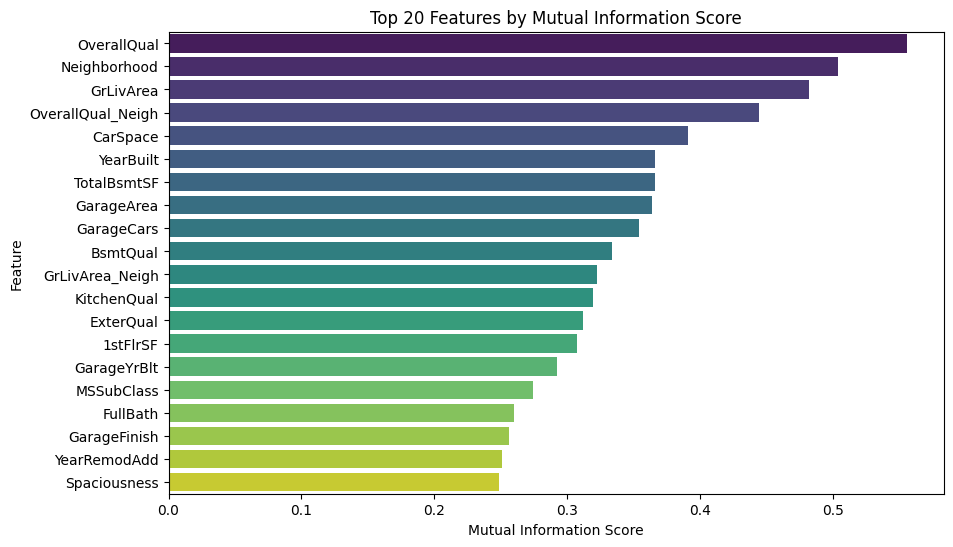

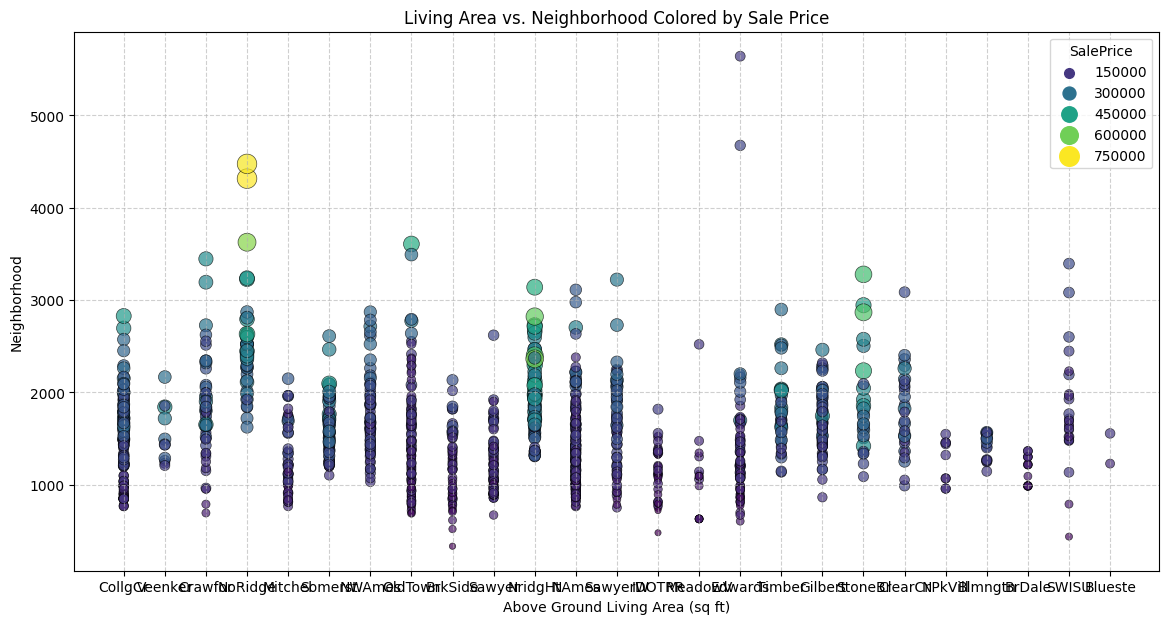

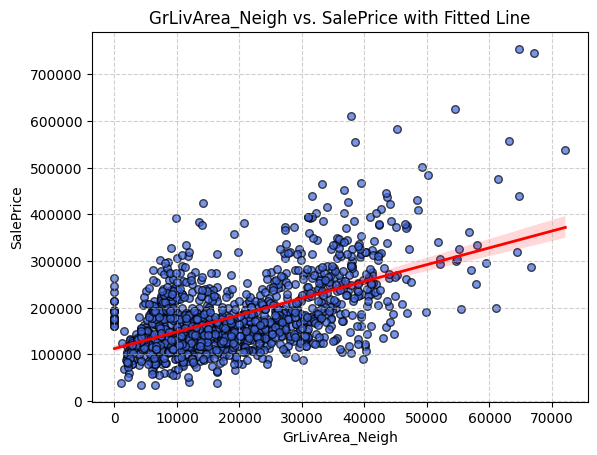

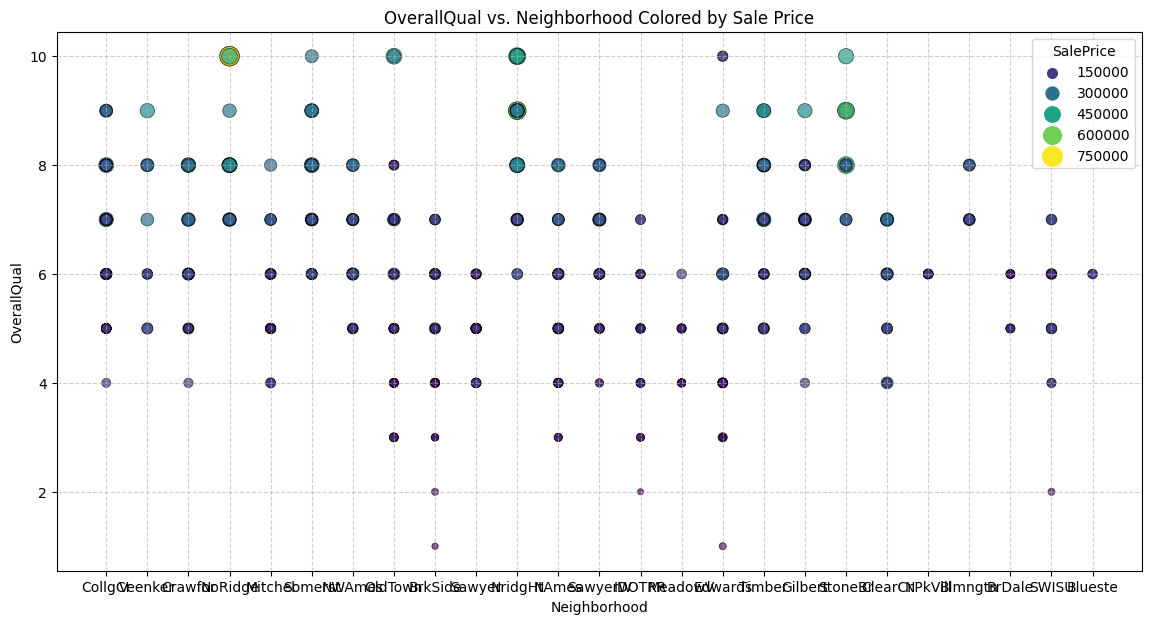

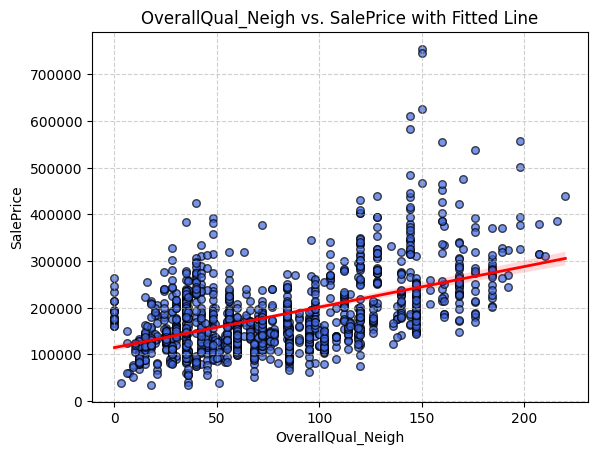

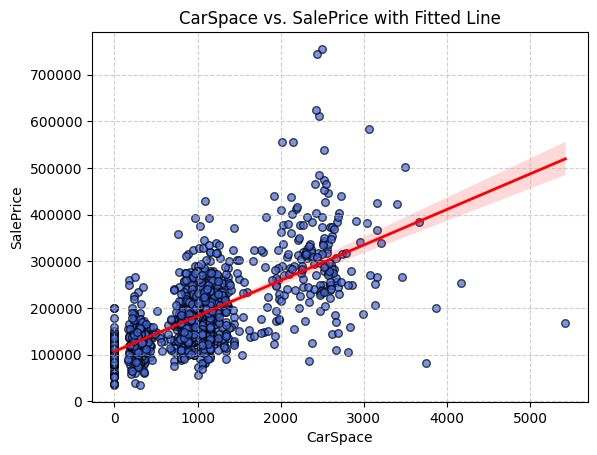

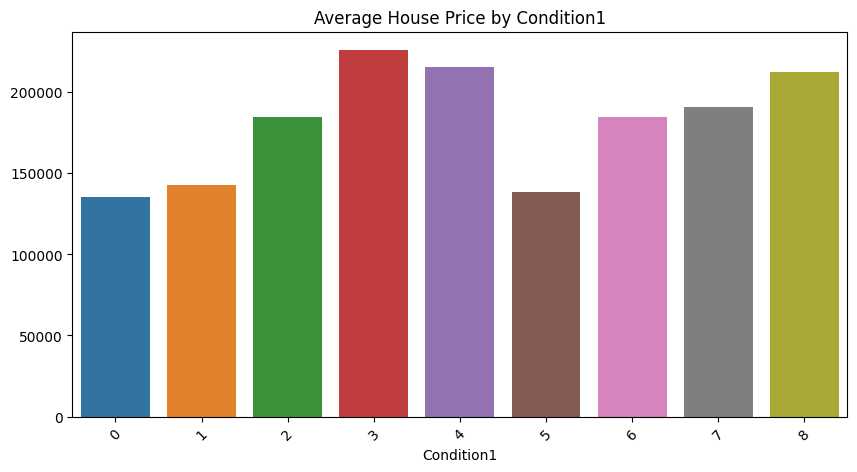

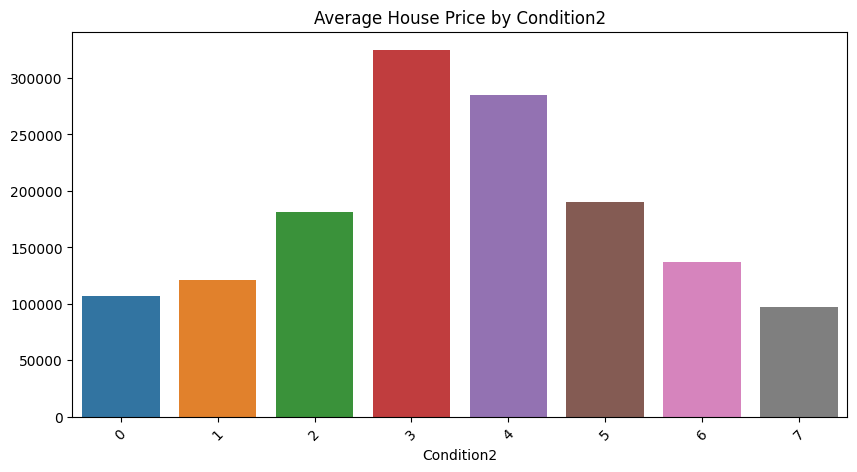

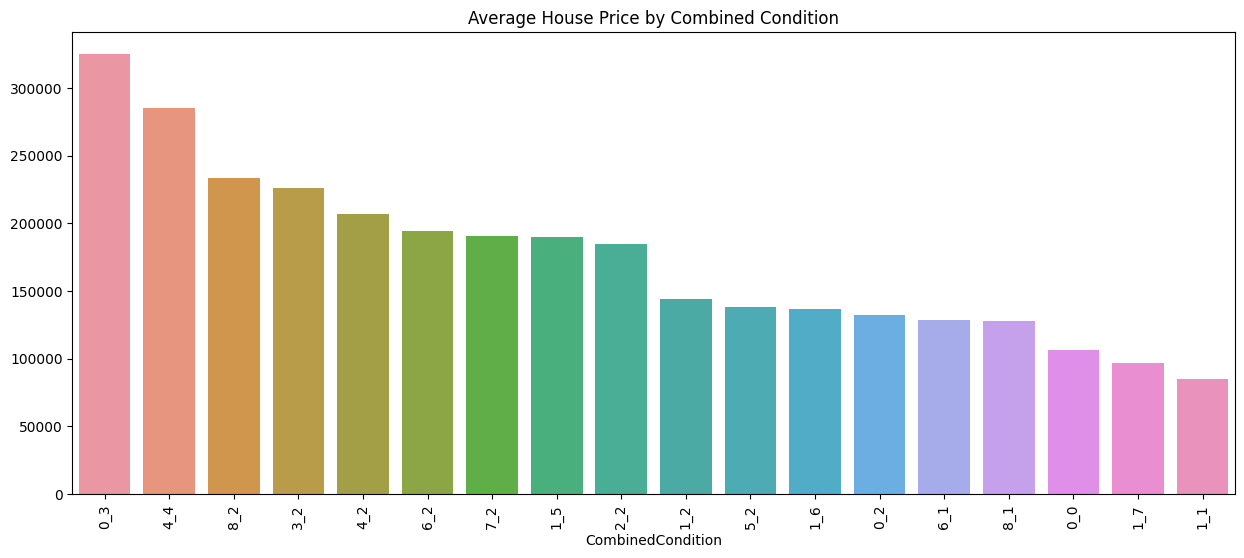

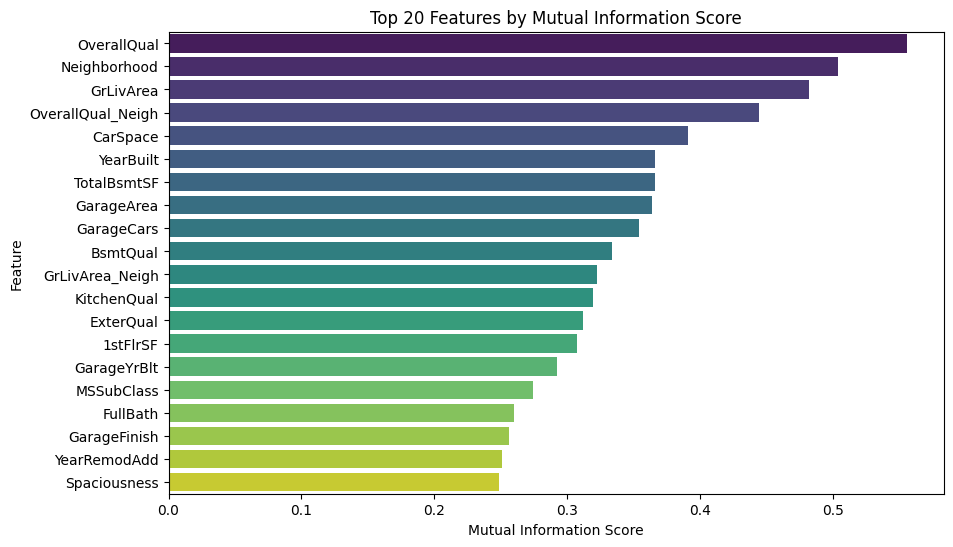

In [8]:
#Call encode categ + Create df2.

mutualInfo(df2)

#GRLivArea + Neighborhood VS SalePrice
plt.figure(figsize=(14, 7))
sns.scatterplot(
    data=df, 
    x='Neighborhood', 
    y='GrLivArea', 
    hue='SalePrice', 
    palette='viridis', 
    size='SalePrice',
    sizes=(20, 200),
    alpha=0.7,
    edgecolor='k'
)

plt.title('Living Area vs. Neighborhood Colored by Sale Price')
plt.xlabel('Above Ground Living Area (sq ft)')
plt.ylabel('Neighborhood')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Scatterplot with regression line
sns.regplot(
    data=df2, 
    x='GrLivArea_Neigh', 
    y='SalePrice', 
    scatter_kws={'alpha': 0.7, 's': 30, 'edgecolor': 'k'},  # Scatter customizations
    line_kws={'color': 'red', 'linewidth': 2},  # Regression line customizations
    color='royalblue',  # Color of scatter points
    logistic=False,  # We are fitting a linear regression, not logistic
)

# Adding labels and title
plt.title('GrLivArea_Neigh vs. SalePrice with Fitted Line')
plt.xlabel('GrLivArea_Neigh')
plt.ylabel('SalePrice')
plt.grid(True, linestyle='--', alpha=0.6)

# Show plot
plt.show()


#OverallQuality + Neighborhood VS SalePrice
plt.figure(figsize=(14, 7))
sns.scatterplot(
    data=df, 
    x='Neighborhood', 
    y='OverallQual', 
    hue='SalePrice', 
    palette='viridis', 
    size='SalePrice',
    sizes=(20, 200),
    alpha=0.7,
    edgecolor='k'
)

plt.title('OverallQual vs. Neighborhood Colored by Sale Price')
plt.xlabel('Neighborhood')
plt.ylabel('OverallQual')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Scatterplot with regression line
sns.regplot(
    data=df2, 
    x='OverallQual_Neigh', 
    y='SalePrice', 
    scatter_kws={'alpha': 0.7, 's': 30, 'edgecolor': 'k'},  # Scatter customizations
    line_kws={'color': 'red', 'linewidth': 2},  # Regression line customizations
    color='royalblue',  # Color of scatter points
    logistic=False,  # We are fitting a linear regression, not logistic
)

# Adding labels and title
plt.title('OverallQual_Neigh vs. SalePrice with Fitted Line')
plt.xlabel('OverallQual_Neigh')
plt.ylabel('SalePrice')
plt.grid(True, linestyle='--', alpha=0.6)

# Show plot
plt.show()



# Scatterplot with regression line
sns.regplot(
    data=df2, 
    x='CarSpace', 
    y='SalePrice', 
    scatter_kws={'alpha': 0.7, 's': 30, 'edgecolor': 'k'},  # Scatter customizations
    line_kws={'color': 'red', 'linewidth': 2},  # Regression line customizations
    color='royalblue',  # Color of scatter points
    logistic=False,  # We are fitting a linear regression, not logistic
)

# Adding labels and title
plt.title('CarSpace vs. SalePrice with Fitted Line')
plt.xlabel('CarSpace')
plt.ylabel('SalePrice')
plt.grid(True, linestyle='--', alpha=0.6)

# Show plot
plt.show()

df2 = fillnan(df2)

# Analyze Condition1
cond1_prices = df2.groupby('Condition1')['SalePrice'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=cond1_prices.index, y=cond1_prices.values)
plt.title('Average House Price by Condition1')
plt.xticks(rotation=45)
plt.show()

# Analyze Condition2
cond2_prices = df2.groupby('Condition2')['SalePrice'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=cond2_prices.index, y=cond2_prices.values)
plt.title('Average House Price by Condition2')
plt.xticks(rotation=45)
plt.show()

# Combine both conditions
combined_prices = df2.groupby('CombinedCondition')['SalePrice'].mean().sort_values(ascending=False)

plt.figure(figsize=(15, 6))
sns.barplot(x=combined_prices.index, y=combined_prices.values)
plt.title('Average House Price by Combined Condition')
plt.xticks(rotation=90)
plt.show()

mutualInfo(df2)



------End of df2 transformations-----

------Start working on df3-----------

In [9]:
df3 = df.copy()

In [10]:
#Function to get count of missing values in each column

def get_cols_with_missing_values(DataFrame):
    missing_na_columns=(DataFrame.isnull().sum())
    return missing_na_columns[missing_na_columns > 0]

In [11]:
#Handling missing values:
#Get a list of all the categorical features that have the keyword 'Qual' OR 'Cond' OR 'Qu' OR 'QC' in the feature name
feature_rating_Qual = [col for col in df3.columns if 'Qual' in col and df3[col].dtypes=='object']
feature_rating_Cond = [col for col in df3.columns if 'Cond' in col and col not in ['Condition1', 'Condition2', 'SaleCondition'] and df3[col].dtypes=='object']
feature_rating_Qu = [col for col in df3.columns if 'Qu' in col and df3[col].dtypes=='object' and col not in feature_rating_Qual]
feature_rating_QC = [col for col in df3.columns if 'QC' in col and df3[col].dtypes=='object']

cat_feature_with_rating = feature_rating_Qual + feature_rating_Cond + feature_rating_Qu + feature_rating_QC
for x in cat_feature_with_rating:
    print(x)

#Categorical features who have NA as a correct value

cat_feature_with_legit_na = ['Alley', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType', 'GarageFinish', 'Fence', 'MiscFeature']
ordinal_cat_features = cat_feature_with_rating + cat_feature_with_legit_na
df3[ordinal_cat_features].head()

#On checking the data description, Missing is valid in some categorical

#Handling Missing Values in Ordinal Categorical features by replacing them with 'Missing' keyword

df3[ordinal_cat_features] = df3[ordinal_cat_features].fillna("Missing")
#Making sure the missing values have been handled
print(get_cols_with_missing_values(df3[ordinal_cat_features]))

#Imputing the mode into the rest of categorical features
categorical_cols=[cname for cname in df3.columns if df3[cname].dtypes=='object' and cname!='ind']
remaining_cat_cols = [cname for cname in categorical_cols if cname not in ordinal_cat_features]
#Handling Missing Values in Categorical features by replacing them with the feature mode value
for col in remaining_cat_cols:
    df3[col] = df3[col].fillna(df3[col].mode()[0])


#Handling Missing Values in Numerical features by replacing them with Mean value
numerical_cols=[cname for cname in df3.columns if df3[cname].dtypes!='object']
df3[numerical_cols]=df3[numerical_cols].fillna(df3[numerical_cols].mean())
#Select categorical columns with low cardinality
categorical_cols=[cname for cname in df3.columns if df3[cname].dtypes=='object' and df3[cname].nunique()<10]
numerical_cols=[cname for cname in df3.columns if df3[cname].dtypes!='object']

# Keep selected columns only
my_cols = numerical_cols + categorical_cols

df3 = df3[my_cols].copy()

ExterQual
BsmtQual
KitchenQual
GarageQual
ExterCond
BsmtCond
GarageCond
FireplaceQu
HeatingQC
PoolQC
Series([], dtype: int64)


In [12]:
#Drop 'Id' feature
df3.drop('Id', axis=1, inplace=True)

In [13]:
#Dealing wiht year, bathroom number and square footage.
#Features with year
df3['GarageYrBlt'] = df3['GarageYrBlt'].astype('int')
df3['GarageYrBlt'] = df3['YrSold'] - df3['GarageYrBlt']
df3['YearBuilt'] = df3['YrSold'] - df3['YearBuilt']
df3['YearRemodAdd'] = df3['YrSold'] - df3['YearRemodAdd']
df3.drop(["YrSold"], axis=1, inplace=True)
df3.drop(["MoSold"], axis=1, inplace=True)

#Features with square footage
#TotalBsmtSF(Total square feet of basement area) = BsmtFinSF1(Type 1 finished square feet) + BsmtFinSF2(Type 2 finished square feet) + BsmtUnfSF(Unfinished square feet of basement area)
df3.drop(["TotalBsmtSF"], axis=1, inplace=True)
#Basement finished area
df3['BsmtFinSF'] = df3['BsmtFinSF1'] + df3['BsmtFinSF2']
df3.drop(["BsmtFinSF1"], axis=1, inplace=True)
df3.drop(["BsmtFinSF2"], axis=1, inplace=True)
#Total floor square feet
df3['TotalFlrSF'] = df3['1stFlrSF'] + df3['2ndFlrSF']

df3.drop(["1stFlrSF"], axis=1, inplace=True)
df3.drop(["2ndFlrSF"], axis=1, inplace=True)

#Bathroom feature
df3['Total_Bath'] = (df3['FullBath'] 
        + (0.5*df3['HalfBath']) 
        + df3['BsmtFullBath'] 
        + (0.5*df3['BsmtHalfBath']))

df3.drop(["FullBath"], axis=1, inplace=True)
df3.drop(["HalfBath"], axis=1, inplace=True)
df3.drop(["BsmtFullBath"], axis=1, inplace=True)
df3.drop(["BsmtHalfBath"], axis=1, inplace=True)

In [14]:
#Year Remodel add is -1 on row 523. This is the only such value. 
#This was the reason of -inf. Since next we take the log1p = log(x+1). In case of this row it was log(0) which is inf. 
df3.at[523, 'YearRemodAdd'] += 1


In [15]:
#Dealing with skewed data 
numerical_cols = [cname for cname in df3.columns if df3[cname].dtypes!='object' and cname!='SalePrice']
skew_df = pd.DataFrame(numerical_cols, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(df3[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)

#Apply log1p transformation
for column in skew_df.query("Skewed == True")['Feature'].values:
    df3[column] = np.log1p(df3[column])

In [16]:
#There is one row which contains -inf value in YearRemodAdd
numeric_df = df3.select_dtypes(include=[np.number])
print(np.isinf(numeric_df).any())
problematic_rows = df3[np.isinf(numeric_df).any(axis=1)]
print(problematic_rows)

#Check if this is the case for the initial database
numeric_df = df.select_dtypes(include=[np.number])
print(np.isinf(numeric_df).any())




MSSubClass       False
LotFrontage      False
LotArea          False
OverallQual      False
OverallCond      False
YearBuilt        False
YearRemodAdd     False
MasVnrArea       False
BsmtUnfSF        False
LowQualFinSF     False
GrLivArea        False
BedroomAbvGr     False
KitchenAbvGr     False
TotRmsAbvGrd     False
Fireplaces       False
GarageYrBlt      False
GarageCars       False
GarageArea       False
WoodDeckSF       False
OpenPorchSF      False
EnclosedPorch    False
3SsnPorch        False
ScreenPorch      False
PoolArea         False
MiscVal          False
SalePrice        False
BsmtFinSF        False
TotalFlrSF       False
Total_Bath       False
dtype: bool
Empty DataFrame
Columns: [MSSubClass, LotFrontage, LotArea, OverallQual, OverallCond, YearBuilt, YearRemodAdd, MasVnrArea, BsmtUnfSF, LowQualFinSF, GrLivArea, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolAre

------End of df3 transformations--------

In [17]:
#split the dataset
def split_dataset(dataset, test_ratio=0.30):
  np.random.seed(42)
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

In [18]:
#Defining the models
models = {
    "Logistic Regression": LogisticRegression(),
     "Random Forest": RandomForestClassifier(),
     "Gradient Boosting": GradientBoostingClassifier(),
     "SVM": SVC(),
     "KNN": KNeighborsClassifier(),
     "Decision Tree": DecisionTreeClassifier(),
    "TensorFlow Decision Forest": tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION),
    "Cat Boost": CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=100)
}

model_linear = {
    "Logistic Regression": LogisticRegression(),
     "SVM": SVC(),
     "KNN": KNeighborsClassifier()
}
model_tree = {
    "Decision Tree": DecisionTreeClassifier(),
    "TensorFlow Decision Forest": tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION),
    "Cat Boost": CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=100),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
}

model_deep ={}

datasets = {
    "Original Dataset": df,  # Original dataset
}

dataset2 = {
    "Dataset 2": df2, 
}

dataset3 = {
    "Dataset 3":df3
}

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp72uw84bo as temporary training directory
Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpyk7a2iee as temporary training directory


In [19]:
# Preprocessing Pipeline
class FillNaN(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
                # Check if X is a DataFrame, and apply fillna
        if isinstance(X, pd.DataFrame):
            return X.fillna("nan")
        else:
            # If the data isn't a DataFrame, just apply fillna to numpy array
            return pd.DataFrame(X).fillna("nan")
        
# Preprocessing Pipeline
def create_preprocessing_pipeline(model_name, categorical_columns, numerical_columns, model_tree =model_tree, model_linear = model_linear):
    if model_name in model_linear:  # For linear models like Logistic Regression, SVM, KNN
        return ColumnTransformer(
            transformers=[
                ('cat', Pipeline(steps=[
                    ('fillna', SimpleImputer(strategy='constant', fill_value="nan")),
                    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))  # OneHot encoding
                ]), categorical_columns),
                ('num', Pipeline(steps=[
                    ('fillna', SimpleImputer(strategy='constant', fill_value=0)),  # Handle missing values
                    ('scaler', StandardScaler())  # Standard scaling for numerical features
                ]), numerical_columns)
            ]
        )
    elif model_name in model_tree:  # For tree-based models like Random Forest, CatBoost
        return ColumnTransformer(
            transformers=[
                ('cat', Pipeline(steps=[
                    ('fillna', SimpleImputer(strategy='constant', fill_value="nan")),  # Handle missing values
                    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))  # Label encoding for categorical features
                ]), categorical_columns),
                ('num', Pipeline(steps=[
                    ('fillna', SimpleImputer(strategy='constant', fill_value=0))  # Handle missing values
                ]), numerical_columns)
            ]
        )
    else:  # For deep learning models
        return "passthrough"  # Deep learning models typically handle preprocessing differently (or not at all)


In [20]:
#Train & Evaluate Models on Multiple Datasets
def train_and_evaluate_models(models_dict, datasets, model_deep=model_deep, tune_models=False):
    results = {}
    best_params = {}

    # Loop through each dataset created (after feature engineering)
    for dataset_name, dataset in datasets.items():

        print(f"\nEvaluating models on dataset: {dataset_name}...")

        X = dataset.drop(columns=["SalePrice"])  
        y = dataset["SalePrice"]  
        
        categorical_columns = X.select_dtypes(include=["object", "category"]).columns.tolist()
        numerical_columns = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Store results for this dataset
        data_results = {}

        # Loop through each model in the dictionary
        for model_name, model in models_dict.items():
            print(f"Training {model_name}...")

            # Check if the model has been tuned already
            if model_name in best_params:
                print(f"Using pre-tuned parameters for {model_name}")
                model.set_params(**best_params[model_name])
            
            # Get the appropriate preprocessing pipeline for the model
            preprocessor = create_preprocessing_pipeline(model_name, categorical_columns, numerical_columns)
            
            if tune_models:
                # Perform hyperparameter tuning for supported models
                if model_name == "Logistic Regression":
                    param_grid = {
                        "C": [0.01, 0.1, 1, 10, 100],
                        "solver": ["lbfgs", "liblinear"]
                    }
                    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
                    grid_search.fit(X_train, y_train)
                    best_params[model_name] = grid_search.best_params_
                    print(f"Best parameters for {model_name}: {best_params[model_name]}")
                    model = grid_search.best_estimator_

                elif model_name == "Cat Boost":
                    param_grid = {
                        'iterations': [100, 500, 1000],
                        'depth': [4, 6, 8],
                        'learning_rate': [0.01, 0.05, 0.1],
                    }
                    grid_search = GridSearchCV(model, param_grid, cv=3, verbose=10, n_jobs=-1)
                    grid_search.fit(X_train, y_train)
                    best_params[model_name] = grid_search.best_params_
                    print(f"Best parameters for {model_name}: {best_params[model_name]}")
                    model = grid_search.best_estimator_

            if model_name == "TensorFlow Decision Forest":
                # For TFDF, use a basic manual approach (hyperparameter tuning can be complex for TFDF)
                model = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.REGRESSION)

                best_params[model_name] = {'iterations': 500, 'depth': 6, 'learning_rate': 0.1}  # Placeholder
                print(f"Best parameters for {model_name}: {best_params[model_name]}")

                # Proceed with training the model using the "best" parameters
                label = 'SalePrice'
                train_ds_pd, valid_ds_pd = split_dataset(dataset, test_ratio=0.30)
                train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
                valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
                model.fit(train_ds)  # Train TFDF model
                y_pred = model.predict(valid_ds)  # Predict using tfdf model
                y_pred = np.array([pred[0] for pred in y_pred])  # Extract predictions
                rmse = np.sqrt(mean_squared_error(valid_ds_pd[label], y_pred))

            else:
                # For other models, use standard sklearn pipelines
                pipeline = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('model', model)
                ])

                # Train the model
                pipeline.fit(X_train, y_train)

                # Evaluate the model
                y_pred = pipeline.predict(X_test)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))

            data_results[model_name] = rmse
            print(f"{model_name} - Score: {rmse:.4f}")

        # Store results for the dataset
        results[dataset_name] = data_results

    return results, best_params


In [21]:
def printResults(results): 
    print("\nModel Performance across different datasets:")
    for dataset_name, dataset_results in results.items():
        print(f"\nResults for {dataset_name}:")
        for model_name, score in dataset_results.items():
            print(f"{model_name}: {score:.4f}")

In [22]:
# Calling: Train and evaluate models on multiple datasets
results, best_params = train_and_evaluate_models(models, datasets)

printResults(results)


Evaluating models on dataset: Original Dataset...
Training Logistic Regression...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [10, 14, 15, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Logistic Regression - Score: 43323.9499
Training Random Forest...
Random Forest - Score: 36146.8580
Training Gradient Boosting...
Gradient Boosting - Score: 64852.8201
Training SVM...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [10, 14, 15, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


SVM - Score: 66520.1997
Training KNN...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [10, 14, 15, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


KNN - Score: 56653.4566
Training Decision Tree...
Decision Tree - Score: 53181.7618
Training TensorFlow Decision Forest...
Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpicil2161 as temporary training directory
Best parameters for TensorFlow Decision Forest: {'iterations': 500, 'depth': 6, 'learning_rate': 0.1}
Reading training dataset...


2025-02-18 22:37:42.746709: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 22:37:42.746725: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 22:37:42.746741: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.936508. Found 1001 examples.
Training model...


I0000 00:00:1739914664.766804 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739914664.768172 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739914664.768188 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739914664.770763 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739914664.770775 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739914664.772957 7125813 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (3 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739914664.773059 7125813 data_spec_inference.cc:354] 2 item(s) have been prun

Model trained in 0:00:00.859961
Compiling model...


I0000 00:00:1739914665.575268 7127730 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34334.4
2025-02-18 22:37:45.575289: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 143
2025-02-18 22:37:45.578888: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 114 tree(s) i.e. 114  iteration(s).
2025-02-18 22:37:45.579151: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:114 valid-loss:34334.406250 valid-rmse:34334.406250
I0000 00:00:1739914665.580743 7127730 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpicil2161 with prefix cd579bcfa5cf43bc
I0000 00:00:1739914665.583002 7127730 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 87ms/step
TensorFlow Decision Forest - Score: 22013.6205
Training Cat Boost...
0:	learn: 72973.9133222	total: 60.1ms	remaining: 30s
100:	learn: 15454.4215422	total: 168ms	remaining: 662ms
200:	learn: 9856.2472198	total: 272ms	remaining: 405ms
300:	learn: 6958.4447382	total: 378ms	remaining: 250ms
400:	learn: 5011.3097360	total: 484ms	remaining: 120ms
499:	learn: 3597.6854655	total: 587ms	remaining: 0us
Cat Boost - Score: 25353.8696

Model Performance across different datasets:

Results for Original Dataset:
Logistic Regression: 43323.9499
Random Forest: 36146.8580
Gradient Boosting: 64852.8201
SVM: 66520.1997
KNN: 56653.4566
Decision Tree: 53181.7618
TensorFlow Decision Forest: 22013.6205
Cat Boost: 25353.8696


In [23]:
# Calling: Train and evaluate models on dataset2

results2, best_params2 = train_and_evaluate_models(models, dataset2)


Evaluating models on dataset: Dataset 2...
Training Logistic Regression...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Logistic Regression - Score: 54986.6738
Training Random Forest...
Random Forest - Score: 41239.1017
Training Gradient Boosting...
Gradient Boosting - Score: 75159.1802
Training SVM...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


SVM - Score: 63374.0684
Training KNN...
KNN - Score: 56306.7384
Training Decision Tree...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Decision Tree - Score: 54762.6555
Training TensorFlow Decision Forest...
Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp5jdoaxmj as temporary training directory
Best parameters for TensorFlow Decision Forest: {'iterations': 500, 'depth': 6, 'learning_rate': 0.1}
Reading training dataset...


2025-02-18 22:43:32.091672: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 22:43:32.091722: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 22:43:32.091725: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.607809. Found 1001 examples.
Training model...


I0000 00:00:1739915012.765349 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739915012.765376 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739915012.765382 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739915012.765600 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739915012.765605 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739915012.766352 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739915012.766402 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.896558
Compiling model...


I0000 00:00:1739915013.641616 7131010 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33418.1
2025-02-18 22:43:33.641633: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 124
2025-02-18 22:43:33.644706: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 95 tree(s) i.e. 95  iteration(s).
2025-02-18 22:43:33.644928: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:95 valid-loss:33418.058594 valid-rmse:33418.058594
I0000 00:00:1739915013.645994 7131010 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp5jdoaxmj with prefix 600f47ae9b2c4bd0
I0000 00:00:1739915013.648150 7131010 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 70ms/step
TensorFlow Decision Forest - Score: 21566.4420
Training Cat Boost...
0:	learn: 72922.6221147	total: 2.7ms	remaining: 1.35s
100:	learn: 14703.0872678	total: 132ms	remaining: 523ms
200:	learn: 9332.3230771	total: 265ms	remaining: 394ms
300:	learn: 6666.4422574	total: 401ms	remaining: 265ms
400:	learn: 4625.1052550	total: 535ms	remaining: 132ms
499:	learn: 3440.9459468	total: 667ms	remaining: 0us
Cat Boost - Score: 23543.1692


In [24]:
# Calling: Train and evaluate models on dataset3

results3, best_params3 = train_and_evaluate_models(models, dataset3)


Evaluating models on dataset: Dataset 3...
Training Logistic Regression...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 13, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Logistic Regression - Score: 42059.3339
Training Random Forest...
Random Forest - Score: 35979.7431
Training Gradient Boosting...
Gradient Boosting - Score: 64256.9262
Training SVM...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 13, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


SVM - Score: 58948.1611
Training KNN...
KNN - Score: 56536.8710
Training Decision Tree...
Decision Tree - Score: 50515.7858
Training TensorFlow Decision Forest...
Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmxj0wtl2 as temporary training directory
Best parameters for TensorFlow Decision Forest: {'iterations': 500, 'depth': 6, 'learning_rate': 0.1}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 13, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
2025-02-18 22:47:53.618757: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 22:47:53.618850: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 22:47:53.618861: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.321319. Found 1001 examples.
Training model...


I0000 00:00:1739915274.000782 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739915274.000801 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739915274.000805 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739915274.000993 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739915274.000998 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739915274.001863 7125813 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739915274.001880 7125813 data_spec_inference.cc:354] 2 item(s) have been prun

Model trained in 0:00:00.332583
Compiling model...


I0000 00:00:1739915274.305018 7133921 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32837.7
2025-02-18 22:47:54.305036: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 58
2025-02-18 22:47:54.306410: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 29 tree(s) i.e. 29  iteration(s).
2025-02-18 22:47:54.306674: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:29 valid-loss:32837.726562 valid-rmse:32837.726562
I0000 00:00:1739915274.307170 7133921 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmxj0wtl2 with prefix ebdbdd42f5f84027
I0000 00:00:1739915274.308096 7133921 kernel.cc:944] Save model in resources
I000

Model compiled.


1/1 [==============================] - 0s 82ms/step
TensorFlow Decision Forest - Score: 25547.6473
Training Cat Boost...
0:	learn: 73416.6887570	total: 2.9ms	remaining: 1.45s
100:	learn: 16106.8932255	total: 95.2ms	remaining: 376ms
200:	learn: 10506.6219228	total: 189ms	remaining: 282ms
300:	learn: 7421.7560781	total: 281ms	remaining: 186ms
400:	learn: 5450.4350541	total: 374ms	remaining: 92.3ms
499:	learn: 4255.2984098	total: 466ms	remaining: 0us
Cat Boost - Score: 24820.2809


In [25]:
def combine_dict(dict1, dict2):
    # Combine dictionaries with distinct dataset names
    final_dict = dict1.copy()  # Start with the first dictionary
    final_dict.update(dict2)   # Add the second dictionary
    return final_dict


In [26]:
final_results = combine_dict(results, results2)
final_results = combine_dict(final_results, results3)


In [27]:
#Plot the results
def plot_results(results):
    # Flatten results into a single list of (model, rmse) with dataset appended
    combined_results = [(f"{dataset} - {model}", score) 
                        for dataset, models in results.items() 
                        for model, score in models.items()]
    
    # Sort results by RMSE in descending order
    combined_results = sorted(combined_results, key=lambda x: x[1], reverse=False)
    
    models, scores = zip(*combined_results)
    
    plt.figure(figsize=(12, 7))
    plt.barh(models, scores, color='blue')
    plt.xlabel('RMSE')
    plt.ylabel('Model (Dataset)')
    plt.title('Model Performance (RMSE) Across Datasets')
    plt.gca().invert_yaxis()  # Highest score on top
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()



{'Original Dataset': {'Logistic Regression': 43323.94993668558, 'Random Forest': 36146.85795502215, 'Gradient Boosting': 64852.820102811806, 'SVM': 66520.19972131375, 'KNN': 56653.456598027326, 'Decision Tree': 53181.76176366924, 'TensorFlow Decision Forest': 22013.620527622472, 'Cat Boost': 25353.86961851577}, 'Dataset 2': {'Logistic Regression': 54986.67379700277, 'Random Forest': 41239.1017028775, 'Gradient Boosting': 75159.18019916161, 'SVM': 63374.06836979717, 'KNN': 56306.73840073466, 'Decision Tree': 54762.65552000505, 'TensorFlow Decision Forest': 21566.441962781948, 'Cat Boost': 23543.16922175028}, 'Dataset 3': {'Logistic Regression': 42059.33387630766, 'Random Forest': 35979.74314745203, 'Gradient Boosting': 64256.92622013812, 'SVM': 58948.1610605849, 'KNN': 56536.87096807473, 'Decision Tree': 50515.78584711062, 'TensorFlow Decision Forest': 25547.647283523, 'Cat Boost': 24820.280895923413}}


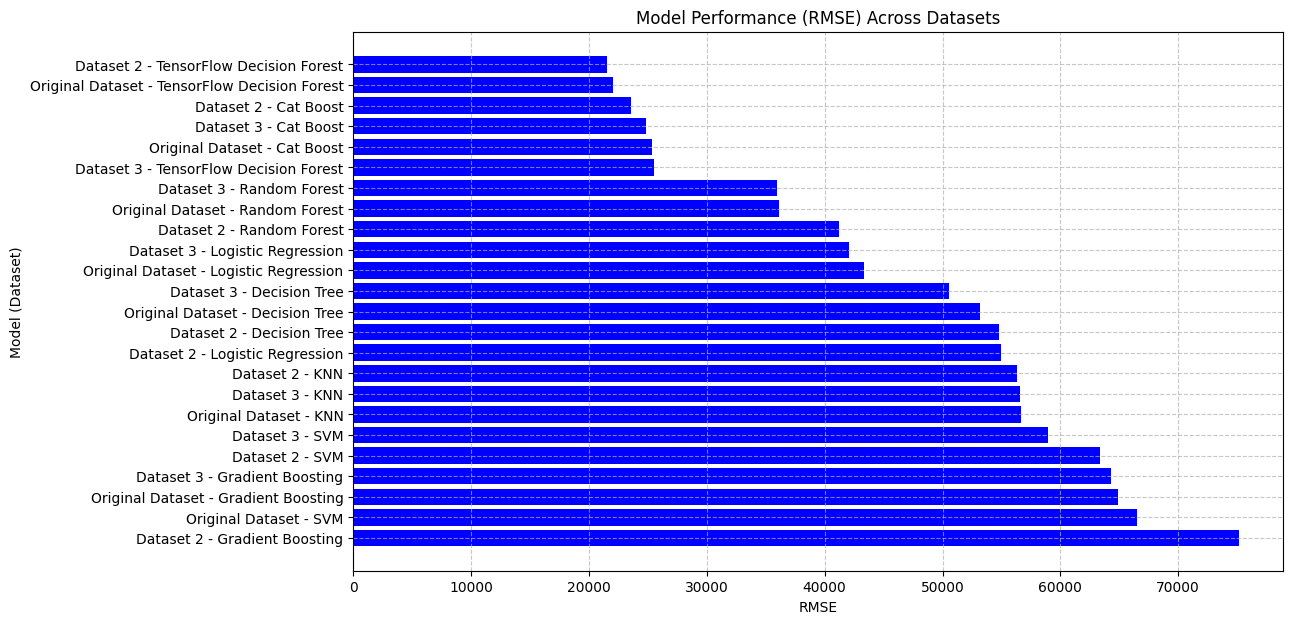

In [28]:
#Call: plot results
print(final_results)
plot_results(final_results)

---------Fine tunning CatBoost and TensorFlow random forest-------

In [32]:
import gc
import traceback

#Fine tunning TFDF with Optuna
# Define the Early Stopping mechanism
def early_stopping(patience=10):
    best_val_loss = np.inf
    epochs_without_improvement = 0

    def check_early_stopping(current_val_loss):
        nonlocal best_val_loss, epochs_without_improvement
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        return epochs_without_improvement >= patience
    
    return check_early_stopping

def objective(trial):
    try:
        # Suggest hyperparameters
        num_trees = trial.suggest_int('num_trees', 100, 1000, step=100)
        max_depth = trial.suggest_int('max_depth', 4, 16)
        min_examples = trial.suggest_int('min_examples', 1, 20)
        shrinkage = trial.suggest_float('shrinkage', 0.01, 0.2)
        honest = trial.suggest_categorical('honest', [True, False])

        # Model with suggested parameters
        model = tfdf.keras.GradientBoostedTreesModel(
            task=tfdf.keras.Task.REGRESSION,
            num_trees=num_trees,
            max_depth=max_depth,
            min_examples=min_examples,
            shrinkage=shrinkage,
            honest=honest
        )

        # Prepare dataset
        np.random.seed(42)
        test_indices = np.random.rand(len(df2)) < 0.30
        train_ds_pd, valid_ds_pd = df2.loc[~test_indices], df2.loc[test_indices]


        train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label="SalePrice", task=tfdf.keras.Task.REGRESSION)
        valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label="SalePrice", task=tfdf.keras.Task.REGRESSION)
        
        early_stopper = early_stopping(patience=10)
        # Train model
        history = model.fit(train_ds)

        # Predictions
        predictions = model.predict(valid_ds)
        predictions = [p[0] for p in predictions]

        # Evaluate RMSE
        rmse = np.sqrt(mean_squared_error(valid_ds_pd["SalePrice"], predictions))

        # Clear memory after each trial
        del model  # Delete model to release memory
        del train_ds  # Delete training dataset
        del valid_ds  # Delete validation dataset
        gc.collect()  # Force garbage collection
        # Early stopping check
        if early_stopper(rmse):
            print(f"Early stopping triggered at RMSE: {rmse}")
            return rmse
        else:
            return rmse
    
    except MemoryError as e:
        # Handle MemoryError (out of memory issue)
        print("Memory error occurred:", e)
        tf.keras.backend.clear_session()
        gc.collect()  # Trigger garbage collection
        return float('inf')  # Return a high RMSE value or a custom value to signal failure
    
    except Exception as e:
        # Catch all other exceptions
        print("An error occurred:", e)
        traceback.print_exc()  # This will print the full stack trace for debugging
        tf.keras.backend.clear_session()
        gc.collect()  # Trigger garbage collection
        return float('inf')  # Return a high RMSE value or a custom value to signal failure


tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Step 1: Broad Exploration (Random Search)
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler())
study.optimize(objective, n_trials=50)
print("\nPhase 1 - Random Search: ", study.best_params)

# Step 2: Focused Search (TPE)
study.sampler = optuna.samplers.TPESampler()
study.optimize(objective, n_trials=100)
print("\nPhase 2 - TPE Optimization: ", study.best_params)

# Step 3: Final Fine-Tuning (Bayesian)
study.sampler = optuna.samplers.CmaEsSampler()
study.optimize(objective, n_trials=50)
print("\nPhase 3 - Bayesian Optimization: ", study.best_params)

# Best result
print("\nBest RMSE: ", study.best_value)
print("Best Hyperparameters: ", study.best_params)


[I 2025-02-18 23:01:00,114] A new study created in memory with name: no-name-268b6db6-363e-4098-b752-5775a09b2855


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4lidnjm2 as temporary training directory


2025-02-18 23:01:00.240624: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:00.240958: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:00.240975: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:01.002253. Found 1001 examples.
Training model...


I0000 00:00:1739916061.388255 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916061.392349 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916061.393235 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916061.411158 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916061.411180 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916061.416087 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916061.418665 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.604016
Compiling model...


I0000 00:00:1739916062.943412 7348152 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33650.6
2025-02-18 23:01:02.943431: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 70
2025-02-18 23:01:02.948360: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 41 tree(s) i.e. 41  iteration(s).
2025-02-18 23:01:02.948792: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:41 valid-loss:33650.632812 valid-rmse:33650.632812
I0000 00:00:1739916062.950849 7348152 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4lidnjm2 with prefix 879fd0d358a34882
I0000 00:00:1739916062.953246 7348152 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 74ms/step


[I 2025-02-18 23:01:03,952] Trial 0 finished with value: 22878.458059537974 and parameters: {'num_trees': 300, 'max_depth': 13, 'min_examples': 7, 'shrinkage': 0.15182935973258604, 'honest': True}. Best is trial 0 with value: 22878.458059537974.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpw2ygcsf9 as temporary training directory
Reading training dataset...


2025-02-18 23:01:03.957061: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:03.957072: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:03.957076: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.481581. Found 1001 examples.
Training model...


I0000 00:00:1739916064.491542 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916064.491560 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916064.491565 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916064.491811 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916064.491816 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916064.492529 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916064.492574 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.729707
Compiling model...


I0000 00:00:1739916065.204643 7348800 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34632.1
2025-02-18 23:01:05.204663: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 107
2025-02-18 23:01:05.206449: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 78 tree(s) i.e. 78  iteration(s).
2025-02-18 23:01:05.206709: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:78 valid-loss:34632.070312 valid-rmse:34632.070312
I0000 00:00:1739916065.207506 7348800 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpw2ygcsf9 with prefix 8c12259e5a13415b
I0000 00:00:1739916065.208792 7348800 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 69ms/step


[I 2025-02-18 23:01:05,854] Trial 1 finished with value: 23176.007632354766 and parameters: {'num_trees': 500, 'max_depth': 7, 'min_examples': 6, 'shrinkage': 0.17595761495769574, 'honest': True}. Best is trial 0 with value: 22878.458059537974.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmps3mc_6s8 as temporary training directory
Reading training dataset...


2025-02-18 23:01:05.858200: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:05.858210: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:05.858214: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.499656. Found 1001 examples.
Training model...


I0000 00:00:1739916066.407847 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916066.407862 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916066.407866 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916066.408075 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916066.408079 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916066.408819 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916066.408856 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.057851
Compiling model...


I0000 00:00:1739916067.442377 7349778 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33425.4
2025-02-18 23:01:07.442432: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 161
2025-02-18 23:01:07.446224: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 132 tree(s) i.e. 132  iteration(s).
2025-02-18 23:01:07.446531: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:132 valid-loss:33425.355469 valid-rmse:33425.355469
I0000 00:00:1739916067.447830 7349778 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmps3mc_6s8 with prefix 676a8a95184b4acb
I0000 00:00:1739916067.449793 7349778 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 91ms/step


[I 2025-02-18 23:01:08,548] Trial 2 finished with value: 21933.38267276278 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 3, 'shrinkage': 0.11488698860489172, 'honest': True}. Best is trial 2 with value: 21933.38267276278.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpd62fqwdj as temporary training directory
Reading training dataset...


2025-02-18 23:01:08.558699: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:08.558715: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:08.558718: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.506276. Found 1001 examples.
Training model...


I0000 00:00:1739916069.127934 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916069.127953 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916069.127957 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916069.128203 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916069.128210 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916069.129007 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916069.129056 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.564606
Compiling model...


I0000 00:00:1739916070.669753 7351232 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32528.5
2025-02-18 23:01:10.669776: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 101
2025-02-18 23:01:10.672456: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 72 tree(s) i.e. 72  iteration(s).
2025-02-18 23:01:10.672938: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:72 valid-loss:32528.548828 valid-rmse:32528.548828
I0000 00:00:1739916070.674509 7351232 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpd62fqwdj with prefix b075318681f3408b
I0000 00:00:1739916070.676470 7351232 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 71ms/step


[I 2025-02-18 23:01:11,508] Trial 3 finished with value: 25342.005626553688 and parameters: {'num_trees': 900, 'max_depth': 14, 'min_examples': 8, 'shrinkage': 0.17805220685633064, 'honest': True}. Best is trial 2 with value: 21933.38267276278.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpfta7vu8m as temporary training directory
Reading training dataset...


2025-02-18 23:01:11.512508: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:11.512518: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:11.512522: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.474170. Found 1001 examples.
Training model...


I0000 00:00:1739916072.040039 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916072.040049 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916072.040056 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916072.040253 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916072.040258 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916072.040979 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916072.041021 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.425413
Compiling model...


2025-02-18 23:01:12.451216: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1603] 	num-trees:100 train-loss:6381.928711 train-rmse:6381.928711 valid-loss:34278.468750 valid-rmse:34278.468750
2025-02-18 23:01:12.451233: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 100
2025-02-18 23:01:12.452597: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 100 tree(s) i.e. 100  iteration(s).
2025-02-18 23:01:12.452603: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:100 valid-loss:34278.468750 valid-rmse:34278.468750
I0000 00:00:1739916072.453319 7352119 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpfta7vu8m with prefix 96990a6306e3475c
I0

Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:01:13,120] Trial 4 finished with value: 23845.058974029973 and parameters: {'num_trees': 100, 'max_depth': 5, 'min_examples': 1, 'shrinkage': 0.15367475383150392, 'honest': False}. Best is trial 2 with value: 21933.38267276278.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp0eg3sh2s as temporary training directory
Reading training dataset...


2025-02-18 23:01:13.124154: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:13.124167: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:13.124170: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.586681. Found 1001 examples.
Training model...


I0000 00:00:1739916073.760473 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916073.760491 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916073.760496 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916073.760700 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916073.760705 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916073.761440 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916073.761477 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.880809
Compiling model...


I0000 00:00:1739916074.623780 7353194 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33284.4
2025-02-18 23:01:14.623822: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 52
2025-02-18 23:01:14.625553: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 23 tree(s) i.e. 23  iteration(s).
2025-02-18 23:01:14.625887: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:23 valid-loss:33284.367188 valid-rmse:33284.367188
I0000 00:00:1739916074.626740 7353194 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp0eg3sh2s with prefix 1aef6888545b41aa
I0000 00:00:1739916074.627886 7353194 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 71ms/step


[I 2025-02-18 23:01:15,425] Trial 5 finished with value: 26065.622353968483 and parameters: {'num_trees': 200, 'max_depth': 10, 'min_examples': 12, 'shrinkage': 0.1021701327727789, 'honest': False}. Best is trial 2 with value: 21933.38267276278.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4m5iqrb5 as temporary training directory
Reading training dataset...


2025-02-18 23:01:15.429250: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:15.429260: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:15.429263: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.461875. Found 1001 examples.
Training model...


I0000 00:00:1739916075.939268 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916075.939281 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916075.939286 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916075.939479 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916075.939485 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916075.940172 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916075.940206 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.239321
Compiling model...


I0000 00:00:1739916076.168002 7353694 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34743
2025-02-18 23:01:16.168027: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 101
2025-02-18 23:01:16.168967: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 72 tree(s) i.e. 72  iteration(s).
2025-02-18 23:01:16.169070: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:72 valid-loss:34743.000000 valid-rmse:34743.000000
I0000 00:00:1739916076.169532 7353694 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4m5iqrb5 with prefix c8130b32d711475c
I0000 00:00:1739916076.170857 7353694 kernel.cc:944] Save model in resources
I0000

Model compiled.
1/1 [==============================] - 0s 67ms/step


[I 2025-02-18 23:01:16,882] Trial 6 finished with value: 24972.177573764886 and parameters: {'num_trees': 400, 'max_depth': 4, 'min_examples': 3, 'shrinkage': 0.1702509825642529, 'honest': True}. Best is trial 2 with value: 21933.38267276278.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpuinn7339 as temporary training directory
Reading training dataset...


2025-02-18 23:01:16.887099: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:16.887108: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:16.887111: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.431588. Found 1001 examples.
Training model...


I0000 00:00:1739916077.365159 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916077.365168 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916077.365172 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916077.365351 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916077.365356 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916077.366066 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916077.366104 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.818977
Compiling model...


I0000 00:00:1739916078.164021 7354579 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33852.2
2025-02-18 23:01:18.164047: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 196
2025-02-18 23:01:18.166306: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 167 tree(s) i.e. 167  iteration(s).
2025-02-18 23:01:18.166470: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:167 valid-loss:33852.214844 valid-rmse:33852.214844
I0000 00:00:1739916078.167641 7354579 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpuinn7339 with prefix e5036adecb5f42e4
I0000 00:00:1739916078.169430 7354579 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 66ms/step


[I 2025-02-18 23:01:18,807] Trial 7 finished with value: 22465.1147425358 and parameters: {'num_trees': 600, 'max_depth': 5, 'min_examples': 1, 'shrinkage': 0.07306720913925, 'honest': False}. Best is trial 2 with value: 21933.38267276278.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpq10gxmd_ as temporary training directory
Reading training dataset...


2025-02-18 23:01:18.811012: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:18.811023: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:18.811026: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.517495. Found 1001 examples.
Training model...


I0000 00:00:1739916079.377345 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916079.377361 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916079.377366 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916079.377579 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916079.377583 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916079.378292 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916079.378342 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.144352
Compiling model...


I0000 00:00:1739916080.477829 7356224 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31865
2025-02-18 23:01:20.477880: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 163
2025-02-18 23:01:20.480021: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 134 tree(s) i.e. 134  iteration(s).
2025-02-18 23:01:20.480174: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:134 valid-loss:31865.017578 valid-rmse:31865.017578
I0000 00:00:1739916080.481373 7356224 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpq10gxmd_ with prefix 7b7c378f0db34374
I0000 00:00:1739916080.485203 7356224 kernel.cc:944] Save model in resources
I0

Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:01:21,429] Trial 8 finished with value: 23990.914693592225 and parameters: {'num_trees': 600, 'max_depth': 7, 'min_examples': 14, 'shrinkage': 0.07988966623076843, 'honest': False}. Best is trial 2 with value: 21933.38267276278.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9r5je9tz as temporary training directory
Reading training dataset...


2025-02-18 23:01:21.433818: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:21.433830: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:21.433833: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.639254. Found 1001 examples.
Training model...


I0000 00:00:1739916082.123468 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916082.123488 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916082.123493 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916082.123718 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916082.123723 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916082.124428 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916082.124466 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.670560
Compiling model...


I0000 00:00:1739916082.759912 7357673 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34535.9
2025-02-18 23:01:22.759936: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 41
2025-02-18 23:01:22.762058: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 12 tree(s) i.e. 12  iteration(s).
2025-02-18 23:01:22.762398: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:12 valid-loss:34535.855469 valid-rmse:34535.855469
I0000 00:00:1739916082.763296 7357673 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9r5je9tz with prefix 5510f13c84254056
I0000 00:00:1739916082.776984 7357673 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 71ms/step


[I 2025-02-18 23:01:23,660] Trial 9 finished with value: 27089.977432325482 and parameters: {'num_trees': 500, 'max_depth': 8, 'min_examples': 5, 'shrinkage': 0.15115778300515245, 'honest': False}. Best is trial 2 with value: 21933.38267276278.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp2i9ig502 as temporary training directory
Reading training dataset...


2025-02-18 23:01:23.670756: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:23.670767: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:23.670771: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.454539. Found 1001 examples.
Training model...


I0000 00:00:1739916084.181855 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916084.181871 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916084.181876 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916084.182071 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916084.182075 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916084.182796 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916084.182832 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.435962
Compiling model...


I0000 00:00:1739916085.596799 7358080 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35366.1
2025-02-18 23:01:25.596820: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 55
2025-02-18 23:01:25.601228: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 26 tree(s) i.e. 26  iteration(s).
2025-02-18 23:01:25.602097: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:26 valid-loss:35366.136719 valid-rmse:35366.136719
I0000 00:00:1739916085.603158 7358080 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp2i9ig502 with prefix 067a99833fc94b51
I0000 00:00:1739916085.604924 7358080 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 71ms/step


[I 2025-02-18 23:01:26,259] Trial 10 finished with value: 26568.874933208743 and parameters: {'num_trees': 500, 'max_depth': 8, 'min_examples': 2, 'shrinkage': 0.07419770003971583, 'honest': False}. Best is trial 2 with value: 21933.38267276278.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpww5ah6bv as temporary training directory
Reading training dataset...


2025-02-18 23:01:26.263803: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:26.263816: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:26.263819: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.448879. Found 1001 examples.
Training model...


I0000 00:00:1739916086.761173 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916086.761185 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916086.761190 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916086.761371 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916086.761377 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916086.762079 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916086.762120 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.727036
Compiling model...


I0000 00:00:1739916087.464977 7358594 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32776.4
2025-02-18 23:01:27.464999: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 50
2025-02-18 23:01:27.466508: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 21 tree(s) i.e. 21  iteration(s).
2025-02-18 23:01:27.466911: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:21 valid-loss:32776.390625 valid-rmse:32776.390625
I0000 00:00:1739916087.467522 7358594 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpww5ah6bv with prefix 5d91c0205d564dd3
I0000 00:00:1739916087.468382 7358594 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:01:28,109] Trial 11 finished with value: 24932.50242071909 and parameters: {'num_trees': 100, 'max_depth': 15, 'min_examples': 11, 'shrinkage': 0.19016766491501305, 'honest': True}. Best is trial 2 with value: 21933.38267276278.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpx8azvvhh as temporary training directory
Reading training dataset...


2025-02-18 23:01:28.112901: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:28.112911: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:28.112914: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.442383. Found 1001 examples.
Training model...


I0000 00:00:1739916088.601883 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916088.601893 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916088.601898 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916088.602093 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916088.602098 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916088.602798 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916088.602835 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.695807
Compiling model...


I0000 00:00:1739916091.257297 7359071 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32706.6
2025-02-18 23:01:31.257350: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 66
2025-02-18 23:01:31.263247: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 37 tree(s) i.e. 37  iteration(s).
2025-02-18 23:01:31.264112: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:37 valid-loss:32706.570312 valid-rmse:32706.570312
I0000 00:00:1739916091.266781 7359071 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpx8azvvhh with prefix 3978098d779142cb
I0000 00:00:1739916091.270741 7359071 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-18 23:01:32,017] Trial 12 finished with value: 25223.86529605601 and parameters: {'num_trees': 400, 'max_depth': 10, 'min_examples': 3, 'shrinkage': 0.0747725896954554, 'honest': False}. Best is trial 2 with value: 21933.38267276278.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpk6d1vihj as temporary training directory
Reading training dataset...


2025-02-18 23:01:32.021851: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:32.021861: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:32.021865: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.514717. Found 1001 examples.
Training model...


I0000 00:00:1739916092.584225 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916092.584245 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916092.584250 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916092.584472 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916092.584477 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916092.585192 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916092.585250 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.520827
Compiling model...


I0000 00:00:1739916094.080481 7359685 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32017.6
2025-02-18 23:01:34.080504: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 236
2025-02-18 23:01:34.084438: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 207 tree(s) i.e. 207  iteration(s).
2025-02-18 23:01:34.084626: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:207 valid-loss:32017.580078 valid-rmse:32017.580078
I0000 00:00:1739916094.086211 7359685 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpk6d1vihj with prefix 69147e263e7e49b9
I0000 00:00:1739916094.088973 7359685 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-18 23:01:34,853] Trial 13 finished with value: 22125.959170398066 and parameters: {'num_trees': 900, 'max_depth': 8, 'min_examples': 16, 'shrinkage': 0.038182124388676915, 'honest': True}. Best is trial 2 with value: 21933.38267276278.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpc85b9iw9 as temporary training directory
Reading training dataset...


2025-02-18 23:01:34.857464: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:34.857474: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:34.857478: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.460561. Found 1001 examples.
Training model...


I0000 00:00:1739916095.366652 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916095.366665 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916095.366669 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916095.366846 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916095.366852 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916095.367527 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916095.367567 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.441849
Compiling model...


I0000 00:00:1739916096.791416 7361647 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33889.1
2025-02-18 23:01:36.791436: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 42
2025-02-18 23:01:36.794140: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 13 tree(s) i.e. 13  iteration(s).
2025-02-18 23:01:36.795026: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:13 valid-loss:33889.070312 valid-rmse:33889.070312
I0000 00:00:1739916096.795945 7361647 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpc85b9iw9 with prefix f044b527e83f4b22
I0000 00:00:1739916096.797820 7361647 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-18 23:01:37,437] Trial 14 finished with value: 30439.108927100995 and parameters: {'num_trees': 700, 'max_depth': 10, 'min_examples': 2, 'shrinkage': 0.11415965361168916, 'honest': True}. Best is trial 2 with value: 21933.38267276278.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9o6l9p63 as temporary training directory
Reading training dataset...


2025-02-18 23:01:37.441493: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:37.441503: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:37.441506: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.455587. Found 1001 examples.
Training model...


I0000 00:00:1739916097.944215 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916097.944225 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916097.944229 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916097.944418 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916097.944423 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916097.945131 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916097.945168 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.347488
Compiling model...


2025-02-18 23:01:38.279052: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1603] 	num-trees:100 train-loss:20422.417969 train-rmse:20422.417969 valid-loss:33742.828125 valid-rmse:33742.828125
2025-02-18 23:01:38.279074: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 100
2025-02-18 23:01:38.281247: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 90 tree(s) i.e. 90  iteration(s).
2025-02-18 23:01:38.281291: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:90 valid-loss:33505.625000 valid-rmse:33505.625000
I0000 00:00:1739916098.281875 7362084 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9o6l9p63 with prefix 065bb7d215614f1a
I00

Model compiled.
1/1 [==============================] - 0s 67ms/step


[I 2025-02-18 23:01:38,942] Trial 15 finished with value: 23499.566556542213 and parameters: {'num_trees': 100, 'max_depth': 5, 'min_examples': 8, 'shrinkage': 0.05213030506043557, 'honest': True}. Best is trial 2 with value: 21933.38267276278.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpcd08qfu4 as temporary training directory
Reading training dataset...


2025-02-18 23:01:38.947009: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:38.947020: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:38.947023: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.451246. Found 1001 examples.
Training model...


I0000 00:00:1739916099.448943 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916099.448964 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916099.448968 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916099.449166 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916099.449170 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916099.449874 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916099.449911 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.658960
Compiling model...


I0000 00:00:1739916102.076925 7362981 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32441.1
2025-02-18 23:01:42.076953: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 180
2025-02-18 23:01:42.080630: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 151 tree(s) i.e. 151  iteration(s).
2025-02-18 23:01:42.080857: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:151 valid-loss:32441.119141 valid-rmse:32441.119141
I0000 00:00:1739916102.083075 7362981 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpcd08qfu4 with prefix 577408fd713643fa
I0000 00:00:1739916102.086747 7362981 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:01:42,849] Trial 16 finished with value: 24024.415877074265 and parameters: {'num_trees': 700, 'max_depth': 10, 'min_examples': 17, 'shrinkage': 0.03289894194461258, 'honest': False}. Best is trial 2 with value: 21933.38267276278.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3zil5zd8 as temporary training directory
Reading training dataset...


2025-02-18 23:01:42.853348: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:42.853358: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:42.853361: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.459228. Found 1001 examples.
Training model...


I0000 00:00:1739916103.361003 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916103.361013 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916103.361017 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916103.361205 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916103.361209 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916103.361914 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916103.361956 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.994856
Compiling model...


I0000 00:00:1739916105.330708 7364524 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33882.1
2025-02-18 23:01:45.330737: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 85
2025-02-18 23:01:45.334960: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 56 tree(s) i.e. 56  iteration(s).
2025-02-18 23:01:45.335542: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:56 valid-loss:33882.144531 valid-rmse:33882.144531
I0000 00:00:1739916105.337096 7364524 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3zil5zd8 with prefix e825a50b3d284c00
I0000 00:00:1739916105.339569 7364524 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 69ms/step


[I 2025-02-18 23:01:45,992] Trial 17 finished with value: 28262.124850086122 and parameters: {'num_trees': 400, 'max_depth': 10, 'min_examples': 11, 'shrinkage': 0.03274957574359131, 'honest': False}. Best is trial 2 with value: 21933.38267276278.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpofubwkrd as temporary training directory
Reading training dataset...


2025-02-18 23:01:45.996313: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:45.996323: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:45.996346: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.451316. Found 1001 examples.
Training model...


I0000 00:00:1739916106.496212 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916106.496224 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916106.496228 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916106.496442 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916106.496449 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916106.497130 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916106.497169 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.910033
Compiling model...


I0000 00:00:1739916107.390010 7365286 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31784.6
2025-02-18 23:01:47.390034: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 102
2025-02-18 23:01:47.393318: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 73 tree(s) i.e. 73  iteration(s).
2025-02-18 23:01:47.393463: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:73 valid-loss:31784.597656 valid-rmse:31784.597656
I0000 00:00:1739916107.394330 7365286 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpofubwkrd with prefix 5db70b8c1e5d42d5
I0000 00:00:1739916107.395622 7365286 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 69ms/step


[I 2025-02-18 23:01:48,035] Trial 18 finished with value: 24290.261392639553 and parameters: {'num_trees': 900, 'max_depth': 8, 'min_examples': 18, 'shrinkage': 0.08605637229963449, 'honest': False}. Best is trial 2 with value: 21933.38267276278.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp18yka178 as temporary training directory
Reading training dataset...


2025-02-18 23:01:48.039661: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:48.039672: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:48.039675: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.461186. Found 1001 examples.
Training model...


I0000 00:00:1739916108.549086 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916108.549097 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916108.549101 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916108.549300 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916108.549304 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916108.550011 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916108.550054 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.983854
Compiling model...


I0000 00:00:1739916109.518980 7366183 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35177.9
2025-02-18 23:01:49.519000: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 45
2025-02-18 23:01:49.521612: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 16 tree(s) i.e. 16  iteration(s).
2025-02-18 23:01:49.522100: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:16 valid-loss:35177.917969 valid-rmse:35177.917969
I0000 00:00:1739916109.522869 7366183 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp18yka178 with prefix da7e73f9748e4b73
I0000 00:00:1739916109.523966 7366183 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 69ms/step


[I 2025-02-18 23:01:50,218] Trial 19 finished with value: 27333.24227384005 and parameters: {'num_trees': 100, 'max_depth': 11, 'min_examples': 10, 'shrinkage': 0.11845788864553898, 'honest': False}. Best is trial 2 with value: 21933.38267276278.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpramu2nxs as temporary training directory
Reading training dataset...


2025-02-18 23:01:50.222114: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:50.222125: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:50.222129: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.459932. Found 1001 examples.
Training model...


I0000 00:00:1739916110.730529 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916110.730543 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916110.730547 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916110.730724 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916110.730730 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916110.731404 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916110.731439 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.534759
Compiling model...


I0000 00:00:1739916111.252891 7366651 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32049.3
2025-02-18 23:01:51.252914: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 146
2025-02-18 23:01:51.254341: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 117 tree(s) i.e. 117  iteration(s).
2025-02-18 23:01:51.254442: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:117 valid-loss:32049.328125 valid-rmse:32049.328125
I0000 00:00:1739916111.255158 7366651 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpramu2nxs with prefix 535f7c1306a34cfa
I0000 00:00:1739916111.256250 7366651 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 69ms/step


[I 2025-02-18 23:01:51,912] Trial 20 finished with value: 23733.692733963628 and parameters: {'num_trees': 700, 'max_depth': 5, 'min_examples': 20, 'shrinkage': 0.08056132958300022, 'honest': False}. Best is trial 2 with value: 21933.38267276278.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp8d0epqav as temporary training directory
Reading training dataset...


2025-02-18 23:01:51.916334: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:51.916348: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:51.916365: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.461891. Found 1001 examples.
Training model...


I0000 00:00:1739916112.432956 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916112.432973 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916112.432977 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916112.433170 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916112.433176 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916112.433882 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916112.433918 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.971442
Compiling model...


I0000 00:00:1739916113.386286 7367903 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32223.7
2025-02-18 23:01:53.386307: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 302
2025-02-18 23:01:53.388369: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 273 tree(s) i.e. 273  iteration(s).
2025-02-18 23:01:53.388470: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:273 valid-loss:32223.734375 valid-rmse:32223.734375
I0000 00:00:1739916113.389865 7367903 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp8d0epqav with prefix 25c7134efb7745f6
I0000 00:00:1739916113.391616 7367903 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 71ms/step


[I 2025-02-18 23:01:54,046] Trial 21 finished with value: 22860.716177152794 and parameters: {'num_trees': 500, 'max_depth': 5, 'min_examples': 15, 'shrinkage': 0.029346142447210656, 'honest': True}. Best is trial 2 with value: 21933.38267276278.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpg61s0dlh as temporary training directory
Reading training dataset...


2025-02-18 23:01:54.050381: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:54.050391: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:54.050394: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.458041. Found 1001 examples.
Training model...


I0000 00:00:1739916114.557528 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916114.557543 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916114.557547 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916114.557728 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916114.557732 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916114.558446 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916114.558484 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.714742
Compiling model...


I0000 00:00:1739916115.258237 7370404 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31476.5
2025-02-18 23:01:55.258257: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 173
2025-02-18 23:01:55.259897: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 144 tree(s) i.e. 144  iteration(s).
2025-02-18 23:01:55.260034: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:144 valid-loss:31476.513672 valid-rmse:31476.513672
I0000 00:00:1739916115.260910 7370404 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpg61s0dlh with prefix e82c40e7b7f44810
I0000 00:00:1739916115.262175 7370404 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:01:55,917] Trial 22 finished with value: 22579.160749499104 and parameters: {'num_trees': 900, 'max_depth': 5, 'min_examples': 7, 'shrinkage': 0.18982566459511913, 'honest': True}. Best is trial 2 with value: 21933.38267276278.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3anujaw0 as temporary training directory
Reading training dataset...


2025-02-18 23:01:55.923052: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:55.923062: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:55.923065: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.463971. Found 1001 examples.
Training model...


I0000 00:00:1739916116.435043 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916116.435054 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916116.435061 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916116.435270 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916116.435280 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916116.435998 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916116.436034 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.670485
Compiling model...


I0000 00:00:1739916117.091076 7371872 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32162
2025-02-18 23:01:57.091100: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 73
2025-02-18 23:01:57.092715: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 44 tree(s) i.e. 44  iteration(s).
2025-02-18 23:01:57.092949: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:44 valid-loss:32162.009766 valid-rmse:32162.009766
I0000 00:00:1739916117.093737 7371872 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3anujaw0 with prefix 04ce0ea556bf4441
I0000 00:00:1739916117.095180 7371872 kernel.cc:944] Save model in resources
I0000 

Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:01:57,768] Trial 23 finished with value: 23955.342646346748 and parameters: {'num_trees': 100, 'max_depth': 7, 'min_examples': 6, 'shrinkage': 0.061568791953395575, 'honest': True}. Best is trial 2 with value: 21933.38267276278.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp28wbom99 as temporary training directory
Reading training dataset...


2025-02-18 23:01:57.772801: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:57.772812: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:01:57.772815: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.462394. Found 1001 examples.
Training model...


I0000 00:00:1739916118.293039 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916118.293050 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916118.293054 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916118.293236 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916118.293240 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916118.293967 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916118.294004 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.477148
Compiling model...


I0000 00:00:1739916119.752210 7372532 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35237.4
2025-02-18 23:01:59.752232: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 48
2025-02-18 23:01:59.756129: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 19 tree(s) i.e. 19  iteration(s).
2025-02-18 23:01:59.756646: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:19 valid-loss:35237.390625 valid-rmse:35237.390625
I0000 00:00:1739916119.757652 7372532 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp28wbom99 with prefix afba7755b8ed4291
I0000 00:00:1739916119.759079 7372532 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-18 23:02:00,442] Trial 24 finished with value: 25915.327087161182 and parameters: {'num_trees': 100, 'max_depth': 11, 'min_examples': 7, 'shrinkage': 0.12210954587217969, 'honest': False}. Best is trial 2 with value: 21933.38267276278.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpwlh6ld1_ as temporary training directory
Reading training dataset...


2025-02-18 23:02:00.446503: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:00.446513: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:00.446516: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.498734. Found 1001 examples.
Training model...


I0000 00:00:1739916120.994493 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916120.994506 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916120.994510 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916120.994689 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916120.994693 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916120.995414 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916120.995450 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.322227
Compiling model...


I0000 00:00:1739916121.306285 7372996 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33382.2
2025-02-18 23:02:01.306305: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 67
2025-02-18 23:02:01.307428: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 38 tree(s) i.e. 38  iteration(s).
2025-02-18 23:02:01.307552: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:38 valid-loss:33382.152344 valid-rmse:33382.152344
I0000 00:00:1739916121.308041 7372996 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpwlh6ld1_ with prefix 05592db50a3546c9
I0000 00:00:1739916121.308807 7372996 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 77ms/step


[I 2025-02-18 23:02:02,067] Trial 25 finished with value: 24286.315530084263 and parameters: {'num_trees': 800, 'max_depth': 6, 'min_examples': 20, 'shrinkage': 0.12194387361671928, 'honest': False}. Best is trial 2 with value: 21933.38267276278.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpwejohb0w as temporary training directory
Reading training dataset...


2025-02-18 23:02:02.072137: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:02.072147: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:02.072151: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.471989. Found 1001 examples.
Training model...
Model trained in 0:00:00.129682
Compiling model...


I0000 00:00:1739916122.593964 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916122.593976 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916122.593980 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916122.594162 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916122.594166 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916122.594855 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916122.594892 7125813 kernel.cc:802] Training dataset:
Number of

Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-18 23:02:03,368] Trial 26 finished with value: 26573.465820113855 and parameters: {'num_trees': 900, 'max_depth': 4, 'min_examples': 4, 'shrinkage': 0.14788953997477935, 'honest': True}. Best is trial 2 with value: 21933.38267276278.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpauqaofr9 as temporary training directory
Reading training dataset...


2025-02-18 23:02:03.372769: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:03.372779: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:03.372782: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.458199. Found 1001 examples.
Training model...


I0000 00:00:1739916123.878834 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916123.878846 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916123.878850 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916123.879048 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916123.879054 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916123.879796 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916123.879835 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.907773
Compiling model...


2025-02-18 23:02:04.764427: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1603] 	num-trees:100 train-loss:11850.552734 train-rmse:11850.552734 valid-loss:33341.699219 valid-rmse:33341.699219
2025-02-18 23:02:04.764442: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 100
2025-02-18 23:02:04.767816: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 100 tree(s) i.e. 100  iteration(s).
2025-02-18 23:02:04.767823: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:100 valid-loss:33341.699219 valid-rmse:33341.699219
I0000 00:00:1739916124.769160 7374131 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpauqaofr9 with prefix baab4c481e0a4b4e


Model compiled.
1/1 [==============================] - 0s 69ms/step


[I 2025-02-18 23:02:05,422] Trial 27 finished with value: 21568.368577779565 and parameters: {'num_trees': 100, 'max_depth': 7, 'min_examples': 3, 'shrinkage': 0.06333416064955638, 'honest': True}. Best is trial 27 with value: 21568.368577779565.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpkc1olyeb as temporary training directory
Reading training dataset...


2025-02-18 23:02:05.426428: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:05.426438: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:05.426441: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.455283. Found 1001 examples.
Training model...


I0000 00:00:1739916125.930977 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916125.930994 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916125.930998 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916125.931183 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916125.931189 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916125.931878 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916125.931912 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.749186
Compiling model...


I0000 00:00:1739916127.650519 7374997 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33670.9
2025-02-18 23:02:07.650543: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 163
2025-02-18 23:02:07.655236: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 134 tree(s) i.e. 134  iteration(s).
2025-02-18 23:02:07.655663: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:134 valid-loss:33670.851562 valid-rmse:33670.851562
I0000 00:00:1739916127.657586 7374997 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpkc1olyeb with prefix 122c3b8ad40a4ba8
I0000 00:00:1739916127.660473 7374997 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:02:08,372] Trial 28 finished with value: 20904.173888564048 and parameters: {'num_trees': 600, 'max_depth': 7, 'min_examples': 2, 'shrinkage': 0.05786256375494713, 'honest': True}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpc6sy3cjv as temporary training directory
Reading training dataset...


2025-02-18 23:02:08.376697: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:08.376709: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:08.376712: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.468429. Found 1001 examples.
Training model...


I0000 00:00:1739916128.896558 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916128.896569 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916128.896573 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916128.896769 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916128.896773 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916128.897490 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916128.897527 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.537375
Compiling model...


I0000 00:00:1739916130.412360 7376392 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32405.5
2025-02-18 23:02:10.412385: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 134
2025-02-18 23:02:10.415291: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 105 tree(s) i.e. 105  iteration(s).
2025-02-18 23:02:10.415554: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:105 valid-loss:32405.472656 valid-rmse:32405.472656
I0000 00:00:1739916130.416986 7376392 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpc6sy3cjv with prefix 065e9c00488a470b
I0000 00:00:1739916130.418909 7376392 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:02:11,127] Trial 29 finished with value: 23137.43872773397 and parameters: {'num_trees': 500, 'max_depth': 10, 'min_examples': 15, 'shrinkage': 0.13316986582744353, 'honest': False}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpvdm1n88y as temporary training directory
Reading training dataset...


2025-02-18 23:02:11.131509: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:11.131523: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:11.131527: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.458763. Found 1001 examples.
Training model...


I0000 00:00:1739916131.639271 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916131.639283 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916131.639287 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916131.639479 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916131.639483 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916131.640171 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916131.640208 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.628484
Compiling model...


I0000 00:00:1739916132.254698 7377551 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32692.8
2025-02-18 23:02:12.254723: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 46
2025-02-18 23:02:12.256168: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 17 tree(s) i.e. 17  iteration(s).
2025-02-18 23:02:12.256546: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:17 valid-loss:32692.765625 valid-rmse:32692.765625
I0000 00:00:1739916132.257056 7377551 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpvdm1n88y with prefix f0606127d4664109
I0000 00:00:1739916132.257838 7377551 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-18 23:02:12,940] Trial 30 finished with value: 26226.31006656339 and parameters: {'num_trees': 300, 'max_depth': 15, 'min_examples': 12, 'shrinkage': 0.16559539645631222, 'honest': True}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpaslu3n_2 as temporary training directory
Reading training dataset...


2025-02-18 23:02:12.944120: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:12.944133: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:12.944136: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.465990. Found 1001 examples.
Training model...


I0000 00:00:1739916133.458242 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916133.458253 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916133.458257 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916133.458439 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916133.458443 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916133.459129 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916133.459170 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.504207
Compiling model...


I0000 00:00:1739916135.934918 7378005 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34136.1
2025-02-18 23:02:15.934942: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 88
2025-02-18 23:02:15.940200: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 59 tree(s) i.e. 59  iteration(s).
2025-02-18 23:02:15.940887: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:59 valid-loss:34136.093750 valid-rmse:34136.093750
I0000 00:00:1739916135.942730 7378005 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpaslu3n_2 with prefix 681503b8abd04ad1
I0000 00:00:1739916135.945257 7378005 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 71ms/step


[I 2025-02-18 23:02:16,717] Trial 31 finished with value: 25450.690665021746 and parameters: {'num_trees': 700, 'max_depth': 15, 'min_examples': 12, 'shrinkage': 0.04095186052684986, 'honest': False}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp45x04c7y as temporary training directory
Reading training dataset...


2025-02-18 23:02:16.721455: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:16.721465: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:16.721468: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.469581. Found 1001 examples.
Training model...


I0000 00:00:1739916137.240067 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916137.240078 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916137.240082 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916137.240274 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916137.240278 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916137.240977 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916137.241011 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.902388
Compiling model...


I0000 00:00:1739916139.122608 7378812 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 36890
2025-02-18 23:02:19.122633: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 40
2025-02-18 23:02:19.126174: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 11 tree(s) i.e. 11  iteration(s).
2025-02-18 23:02:19.127186: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:297] The best validation loss was obtained during iteration 10. This is the first step during which a validation loss was computed, hence the validation loss might still have been unstable and not optimal. Following are examples of hyper-parameter changes that might help with the situation. Try them in order: (1) Decrease the 'shrink

Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:02:19,886] Trial 32 finished with value: 27746.157095492577 and parameters: {'num_trees': 800, 'max_depth': 13, 'min_examples': 4, 'shrinkage': 0.17014969516163447, 'honest': False}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjq1x7wxk as temporary training directory
Reading training dataset...


2025-02-18 23:02:19.890731: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:19.890741: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:19.890744: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.470437. Found 1001 examples.
Training model...


I0000 00:00:1739916140.410908 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916140.410921 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916140.410925 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916140.411129 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916140.411133 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916140.411845 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916140.411883 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.394817
Compiling model...


I0000 00:00:1739916140.790925 7379220 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31467.5
2025-02-18 23:02:20.790945: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 50
2025-02-18 23:02:20.795570: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 21 tree(s) i.e. 21  iteration(s).
2025-02-18 23:02:20.795789: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:21 valid-loss:31467.525391 valid-rmse:31467.525391
I0000 00:00:1739916140.796265 7379220 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjq1x7wxk with prefix bc46874508724c92
I0000 00:00:1739916140.797233 7379220 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 71ms/step


[I 2025-02-18 23:02:21,498] Trial 33 finished with value: 26735.476715447116 and parameters: {'num_trees': 300, 'max_depth': 9, 'min_examples': 17, 'shrinkage': 0.17076862994154943, 'honest': True}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpl_n6o3zd as temporary training directory
Reading training dataset...


2025-02-18 23:02:21.504092: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:21.504103: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:21.504106: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.459126. Found 1001 examples.
Training model...


I0000 00:00:1739916142.013716 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916142.013726 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916142.013730 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916142.013928 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916142.013933 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916142.014644 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916142.014683 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:04.361314
Compiling model...


I0000 00:00:1739916146.327997 7379696 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30612.3
2025-02-18 23:02:26.328023: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 400
2025-02-18 23:02:26.333793: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 371 tree(s) i.e. 371  iteration(s).
2025-02-18 23:02:26.334018: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:371 valid-loss:30612.261719 valid-rmse:30612.261719
I0000 00:00:1739916146.338030 7379696 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpl_n6o3zd with prefix e0127d70fb1242d4
I0000 00:00:1739916146.343217 7379696 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 72ms/step


[I 2025-02-18 23:02:27,137] Trial 34 finished with value: 23501.214002571687 and parameters: {'num_trees': 800, 'max_depth': 10, 'min_examples': 20, 'shrinkage': 0.024059655854129842, 'honest': False}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpu_zs8ass as temporary training directory
Reading training dataset...


2025-02-18 23:02:27.141599: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:27.141610: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:27.141613: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.468577. Found 1001 examples.
Training model...


I0000 00:00:1739916147.661779 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916147.661791 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916147.661795 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916147.661986 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916147.661990 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916147.662701 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916147.662736 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.407167
Compiling model...


I0000 00:00:1739916149.049199 7383020 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30340.4
2025-02-18 23:02:29.049218: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 105
2025-02-18 23:02:29.052019: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 76 tree(s) i.e. 76  iteration(s).
2025-02-18 23:02:29.052398: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:76 valid-loss:30340.433594 valid-rmse:30340.433594
I0000 00:00:1739916149.053708 7383020 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpu_zs8ass with prefix 9fec3731d4b44c27
I0000 00:00:1739916149.055700 7383020 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:02:29,788] Trial 35 finished with value: 23306.592531081256 and parameters: {'num_trees': 500, 'max_depth': 16, 'min_examples': 13, 'shrinkage': 0.08579090233423682, 'honest': True}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmprxoamjhr as temporary training directory
Reading training dataset...


2025-02-18 23:02:29.792702: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:29.792712: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:29.792715: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.486544. Found 1001 examples.
Training model...


I0000 00:00:1739916150.354992 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916150.355008 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916150.355014 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916150.355207 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916150.355213 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916150.355926 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916150.355963 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:04.179173
Compiling model...


I0000 00:00:1739916154.493548 7383954 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32013.3
2025-02-18 23:02:34.493578: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 76
2025-02-18 23:02:34.500211: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 47 tree(s) i.e. 47  iteration(s).
2025-02-18 23:02:34.501349: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:47 valid-loss:32013.330078 valid-rmse:32013.330078
I0000 00:00:1739916154.504574 7383954 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmprxoamjhr with prefix c005b3362ced4a4e
I0000 00:00:1739916154.508328 7383954 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 74ms/step


[I 2025-02-18 23:02:35,344] Trial 36 finished with value: 24960.138827031045 and parameters: {'num_trees': 200, 'max_depth': 14, 'min_examples': 3, 'shrinkage': 0.049383398006046214, 'honest': True}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpr8sbe0tt as temporary training directory
Reading training dataset...


2025-02-18 23:02:35.349592: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:35.349602: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:35.349606: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.476483. Found 1001 examples.
Training model...


I0000 00:00:1739916155.879720 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916155.879731 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916155.879735 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916155.879920 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916155.879924 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916155.880653 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916155.880693 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:04.854156
Compiling model...


2025-02-18 23:02:40.670732: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1603] 	num-trees:300 train-loss:9527.024414 train-rmse:9527.024414 valid-loss:30881.019531 valid-rmse:30881.019531
2025-02-18 23:02:40.670768: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 300
2025-02-18 23:02:40.684775: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 295 tree(s) i.e. 295  iteration(s).
2025-02-18 23:02:40.684849: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:295 valid-loss:30826.119141 valid-rmse:30826.119141
I0000 00:00:1739916160.689849 7384662 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpr8sbe0tt with prefix 9cf02ea4d32e4f00
I0

Model compiled.
1/1 [==============================] - 0s 71ms/step


[I 2025-02-18 23:02:41,592] Trial 37 finished with value: 24164.194603922206 and parameters: {'num_trees': 300, 'max_depth': 15, 'min_examples': 19, 'shrinkage': 0.04092043648206104, 'honest': False}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp2fi4zioy as temporary training directory
Reading training dataset...


2025-02-18 23:02:41.610270: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:41.610284: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:41.610287: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.472072. Found 1001 examples.
Training model...


I0000 00:00:1739916162.140765 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916162.140784 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916162.140793 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916162.141026 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916162.141031 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916162.141746 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916162.141785 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.713135
Compiling model...


I0000 00:00:1739916162.840243 7387215 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35753.7
2025-02-18 23:02:42.840266: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 51
2025-02-18 23:02:42.842067: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 22 tree(s) i.e. 22  iteration(s).
2025-02-18 23:02:42.842538: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:22 valid-loss:35753.695312 valid-rmse:35753.695312
I0000 00:00:1739916162.843162 7387215 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp2fi4zioy with prefix 197b62063cce4b6e
I0000 00:00:1739916162.844460 7387215 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:02:43,533] Trial 38 finished with value: 24415.04040099328 and parameters: {'num_trees': 100, 'max_depth': 7, 'min_examples': 1, 'shrinkage': 0.13533806337003754, 'honest': True}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpifn6_6l2 as temporary training directory
Reading training dataset...


2025-02-18 23:02:43.537379: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:43.537389: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:43.537392: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.466187. Found 1001 examples.
Training model...


I0000 00:00:1739916164.053303 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916164.053313 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916164.053318 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916164.053534 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916164.053539 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916164.054264 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916164.054309 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.614132
Compiling model...


I0000 00:00:1739916165.641705 7387699 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32063.3
2025-02-18 23:02:45.641730: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 237
2025-02-18 23:02:45.644774: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 208 tree(s) i.e. 208  iteration(s).
2025-02-18 23:02:45.644949: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:208 valid-loss:32063.273438 valid-rmse:32063.273438
I0000 00:00:1739916165.646663 7387699 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpifn6_6l2 with prefix 2d23905066d141df
I0000 00:00:1739916165.649603 7387699 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-18 23:02:46,498] Trial 39 finished with value: 23875.82815635859 and parameters: {'num_trees': 900, 'max_depth': 8, 'min_examples': 13, 'shrinkage': 0.0997501648488907, 'honest': False}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpstwal4z6 as temporary training directory
Reading training dataset...


2025-02-18 23:02:46.504385: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:46.504398: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:46.504401: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.480284. Found 1001 examples.
Training model...


I0000 00:00:1739916167.047677 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916167.047694 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916167.047699 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916167.047907 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916167.047912 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916167.048601 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916167.048640 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.397166
Compiling model...


I0000 00:00:1739916168.425141 7389696 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31624.1
2025-02-18 23:02:48.425166: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 120
2025-02-18 23:02:48.428491: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 91 tree(s) i.e. 91  iteration(s).
2025-02-18 23:02:48.428736: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:91 valid-loss:31624.076172 valid-rmse:31624.076172
I0000 00:00:1739916168.429932 7389696 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpstwal4z6 with prefix 710be4c7ccce4b63
I0000 00:00:1739916168.431567 7389696 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 77ms/step


[I 2025-02-18 23:02:49,156] Trial 40 finished with value: 23174.937479499353 and parameters: {'num_trees': 800, 'max_depth': 11, 'min_examples': 15, 'shrinkage': 0.05017006264344741, 'honest': True}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp5d4dzvdk as temporary training directory
Reading training dataset...


2025-02-18 23:02:49.161302: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:49.161312: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:49.161315: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.474751. Found 1001 examples.
Training model...


I0000 00:00:1739916169.685503 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916169.685513 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916169.685518 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916169.685712 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916169.685717 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916169.686422 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916169.686459 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.822934
Compiling model...


I0000 00:00:1739916170.495681 7390749 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33292.5
2025-02-18 23:02:50.495703: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 40
2025-02-18 23:02:50.497455: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 11 tree(s) i.e. 11  iteration(s).
2025-02-18 23:02:50.497967: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:297] The best validation loss was obtained during iteration 10. This is the first step during which a validation loss was computed, hence the validation loss might still have been unstable and not optimal. Following are examples of hyper-parameter changes that might help with the situation. Try them in order: (1) Decrease the 'shri

Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-18 23:02:51,249] Trial 41 finished with value: 28568.712459723647 and parameters: {'num_trees': 900, 'max_depth': 12, 'min_examples': 5, 'shrinkage': 0.1579820746515455, 'honest': True}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpoii9kadr as temporary training directory
Reading training dataset...


2025-02-18 23:02:51.253958: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:51.253970: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:51.253978: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.486151. Found 1001 examples.
Training model...


I0000 00:00:1739916171.793587 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916171.793600 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916171.793604 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916171.793785 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916171.793789 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916171.794491 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916171.794526 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:04.150661
Compiling model...


I0000 00:00:1739916175.897514 7391154 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31645.7
2025-02-18 23:02:55.897545: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 291
2025-02-18 23:02:55.903031: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 262 tree(s) i.e. 262  iteration(s).
2025-02-18 23:02:55.903330: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:262 valid-loss:31645.730469 valid-rmse:31645.730469
I0000 00:00:1739916175.907302 7391154 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpoii9kadr with prefix 693645b8862a4d8e
I0000 00:00:1739916175.912736 7391154 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 71ms/step


[I 2025-02-18 23:02:56,749] Trial 42 finished with value: 23273.76734724798 and parameters: {'num_trees': 500, 'max_depth': 11, 'min_examples': 11, 'shrinkage': 0.01454226107495991, 'honest': True}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpdrsudras as temporary training directory
Reading training dataset...


2025-02-18 23:02:56.753349: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:56.753359: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:02:56.753363: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.486649. Found 1001 examples.
Training model...


I0000 00:00:1739916177.293947 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916177.293962 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916177.293967 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916177.294164 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916177.294169 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916177.294853 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916177.294889 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:03.305276
Compiling model...


I0000 00:00:1739916180.562710 7393597 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31475.2
2025-02-18 23:03:00.562768: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 99
2025-02-18 23:03:00.567934: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 70 tree(s) i.e. 70  iteration(s).
2025-02-18 23:03:00.568733: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:70 valid-loss:31475.177734 valid-rmse:31475.177734
I0000 00:00:1739916180.571822 7393597 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpdrsudras with prefix 81265c338fb8457a
I0000 00:00:1739916180.575328 7393597 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 72ms/step


[I 2025-02-18 23:03:01,545] Trial 43 finished with value: 21640.617950208583 and parameters: {'num_trees': 900, 'max_depth': 16, 'min_examples': 4, 'shrinkage': 0.14914551225394582, 'honest': True}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpsx73lipv as temporary training directory
Reading training dataset...


2025-02-18 23:03:01.553376: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:01.553395: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:01.553399: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.493766. Found 1001 examples.
Training model...


I0000 00:00:1739916182.128045 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916182.128059 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916182.128064 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916182.128291 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916182.128300 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916182.129026 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916182.129062 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.224608
Compiling model...


I0000 00:00:1739916183.336899 7394492 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33749.2
2025-02-18 23:03:03.336918: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 51
2025-02-18 23:03:03.338996: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 22 tree(s) i.e. 22  iteration(s).
2025-02-18 23:03:03.339504: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:22 valid-loss:33749.167969 valid-rmse:33749.167969
I0000 00:00:1739916183.340292 7394492 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpsx73lipv with prefix 5637e720d12b448d
I0000 00:00:1739916183.341437 7394492 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:03:04,128] Trial 44 finished with value: 29581.513140063475 and parameters: {'num_trees': 400, 'max_depth': 11, 'min_examples': 13, 'shrinkage': 0.07663198764390772, 'honest': False}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpn5ujuh08 as temporary training directory
Reading training dataset...


2025-02-18 23:03:04.131964: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:04.131974: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:04.131977: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.476500. Found 1001 examples.
Training model...


I0000 00:00:1739916184.659065 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916184.659075 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916184.659079 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916184.659281 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916184.659287 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916184.660016 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916184.660061 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.855496
Compiling model...


I0000 00:00:1739916185.499029 7394980 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33240.2
2025-02-18 23:03:05.499054: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 47
2025-02-18 23:03:05.501200: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 18 tree(s) i.e. 18  iteration(s).
2025-02-18 23:03:05.501528: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:18 valid-loss:33240.230469 valid-rmse:33240.230469
I0000 00:00:1739916185.502239 7394980 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpn5ujuh08 with prefix 1cb546cf8dcc4cd9
I0000 00:00:1739916185.503812 7394980 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-18 23:03:06,192] Trial 45 finished with value: 26121.319632089922 and parameters: {'num_trees': 800, 'max_depth': 10, 'min_examples': 11, 'shrinkage': 0.1305563868957817, 'honest': False}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmprzzqzsrv as temporary training directory
Reading training dataset...


2025-02-18 23:03:06.196116: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:06.196126: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:06.196129: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.479438. Found 1001 examples.
Training model...


I0000 00:00:1739916186.729381 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916186.729391 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916186.729395 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916186.729610 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916186.729616 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916186.730325 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916186.730362 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.469903
Compiling model...


I0000 00:00:1739916188.183850 7395442 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33563.6
2025-02-18 23:03:08.183871: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 50
2025-02-18 23:03:08.186124: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 21 tree(s) i.e. 21  iteration(s).
2025-02-18 23:03:08.186747: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:21 valid-loss:33563.640625 valid-rmse:33563.640625
I0000 00:00:1739916188.187511 7395442 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmprzzqzsrv with prefix 32559eba13904def
I0000 00:00:1739916188.188636 7395442 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 75ms/step


[I 2025-02-18 23:03:09,050] Trial 46 finished with value: 29206.980020347775 and parameters: {'num_trees': 600, 'max_depth': 15, 'min_examples': 13, 'shrinkage': 0.08191273473686304, 'honest': False}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptds3xxif as temporary training directory
Reading training dataset...


2025-02-18 23:03:09.062783: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:09.062795: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:09.062799: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.497354. Found 1001 examples.
Training model...


I0000 00:00:1739916189.622289 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916189.622304 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916189.622309 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916189.622529 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916189.622533 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916189.623306 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916189.623353 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.808296
Compiling model...


I0000 00:00:1739916190.411227 7395952 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31873.7
2025-02-18 23:03:10.411247: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 106
2025-02-18 23:03:10.413080: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 77 tree(s) i.e. 77  iteration(s).
2025-02-18 23:03:10.413295: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:77 valid-loss:31873.703125 valid-rmse:31873.703125
I0000 00:00:1739916190.414144 7395952 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptds3xxif with prefix ab16b6c1da2e4930
I0000 00:00:1739916190.415694 7395952 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 74ms/step


[I 2025-02-18 23:03:11,316] Trial 47 finished with value: 21881.154713268555 and parameters: {'num_trees': 800, 'max_depth': 9, 'min_examples': 13, 'shrinkage': 0.12203066870022394, 'honest': True}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4zlq9oaz as temporary training directory
Reading training dataset...


2025-02-18 23:03:11.322508: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:11.322520: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:11.322523: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.475871. Found 1001 examples.
Training model...


I0000 00:00:1739916191.856673 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916191.856696 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916191.856701 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916191.856960 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916191.856965 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916191.857685 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916191.857726 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.609278
Compiling model...


2025-02-18 23:03:13.444284: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1603] 	num-trees:100 train-loss:6157.366699 train-rmse:6157.366699 valid-loss:30261.453125 valid-rmse:30261.453125
2025-02-18 23:03:13.444299: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 100
2025-02-18 23:03:13.446589: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 94 tree(s) i.e. 94  iteration(s).
2025-02-18 23:03:13.446671: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:94 valid-loss:30059.140625 valid-rmse:30059.140625
I0000 00:00:1739916193.448231 7396898 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4zlq9oaz with prefix 2a5d526a7e1a4767
I0000

Model compiled.
1/1 [==============================] - 0s 71ms/step


[I 2025-02-18 23:03:14,261] Trial 48 finished with value: 24802.12626215077 and parameters: {'num_trees': 100, 'max_depth': 14, 'min_examples': 18, 'shrinkage': 0.17508065524120411, 'honest': False}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpgwrzuct4 as temporary training directory
Reading training dataset...


2025-02-18 23:03:14.265967: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:14.265978: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:14.265981: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.488198. Found 1001 examples.
Training model...


I0000 00:00:1739916194.805245 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916194.805259 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916194.805265 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916194.805515 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916194.805525 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916194.806438 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916194.806491 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:04.134714
Compiling model...


I0000 00:00:1739916198.901958 7397822 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32082.2
2025-02-18 23:03:18.901980: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 44
2025-02-18 23:03:18.908569: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 15 tree(s) i.e. 15  iteration(s).
2025-02-18 23:03:18.910939: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:15 valid-loss:32082.240234 valid-rmse:32082.240234
I0000 00:00:1739916198.913423 7397822 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpgwrzuct4 with prefix 7691fbe42bbf4298
I0000 00:00:1739916198.916647 7397822 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:03:19,640] Trial 49 finished with value: 26463.57342335944 and parameters: {'num_trees': 400, 'max_depth': 13, 'min_examples': 1, 'shrinkage': 0.17282793538996977, 'honest': True}. Best is trial 28 with value: 20904.173888564048.



Phase 1 - Random Search:  {'num_trees': 600, 'max_depth': 7, 'min_examples': 2, 'shrinkage': 0.05786256375494713, 'honest': True}
Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmph58xce_u as temporary training directory
Reading training dataset...


2025-02-18 23:03:19.666097: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:19.666107: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:19.666110: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.474808. Found 1001 examples.
Training model...


I0000 00:00:1739916200.200089 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916200.200102 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916200.200106 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916200.200282 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916200.200287 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916200.200991 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916200.201033 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.214850
Compiling model...


I0000 00:00:1739916201.393089 7398287 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33273.9
2025-02-18 23:03:21.393113: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 162
2025-02-18 23:03:21.395856: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 133 tree(s) i.e. 133  iteration(s).
2025-02-18 23:03:21.396159: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:133 valid-loss:33273.937500 valid-rmse:33273.937500
I0000 00:00:1739916201.397569 7398287 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmph58xce_u with prefix fb41826e14d94cd1
I0000 00:00:1739916201.399743 7398287 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 76ms/step


[I 2025-02-18 23:03:22,182] Trial 50 finished with value: 22789.762966014365 and parameters: {'num_trees': 1000, 'max_depth': 6, 'min_examples': 2, 'shrinkage': 0.10362021281072045, 'honest': True}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpfqgc7ve5 as temporary training directory
Reading training dataset...


2025-02-18 23:03:22.198796: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:22.198807: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:22.198812: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.470944. Found 1001 examples.
Training model...


I0000 00:00:1739916202.722716 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916202.722734 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916202.722738 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916202.722942 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916202.722946 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916202.723637 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916202.723672 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.438885
Compiling model...


I0000 00:00:1739916204.141769 7399663 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32026.9
2025-02-18 23:03:24.141799: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 117
2025-02-18 23:03:24.144158: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 88 tree(s) i.e. 88  iteration(s).
2025-02-18 23:03:24.144393: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:88 valid-loss:32026.892578 valid-rmse:32026.892578
I0000 00:00:1739916204.145668 7399663 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpfqgc7ve5 with prefix 440173827b80432b
I0000 00:00:1739916204.147475 7399663 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 72ms/step


[I 2025-02-18 23:03:25,002] Trial 51 finished with value: 22679.16765449375 and parameters: {'num_trees': 1000, 'max_depth': 9, 'min_examples': 9, 'shrinkage': 0.06476094807614215, 'honest': True}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppub5fffu as temporary training directory
Reading training dataset...


2025-02-18 23:03:25.020598: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:25.020609: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:25.020612: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.482626. Found 1001 examples.
Training model...


I0000 00:00:1739916205.560260 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916205.560274 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916205.560278 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916205.560492 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916205.560499 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916205.561226 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916205.561267 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.117031
Compiling model...


I0000 00:00:1739916206.653971 7400731 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31503.3
2025-02-18 23:03:26.653995: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 187
2025-02-18 23:03:26.658610: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 158 tree(s) i.e. 158  iteration(s).
2025-02-18 23:03:26.658868: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:158 valid-loss:31503.312500 valid-rmse:31503.312500
I0000 00:00:1739916206.660161 7400731 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppub5fffu with prefix c72b77c717d9424b
I0000 00:00:1739916206.662099 7400731 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:03:27,374] Trial 52 finished with value: 22119.107529244535 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 4, 'shrinkage': 0.09221416262171526, 'honest': True}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp2e2xn2tx as temporary training directory
Reading training dataset...


2025-02-18 23:03:27.389719: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:27.389729: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:27.389733: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.481278. Found 1001 examples.
Training model...


I0000 00:00:1739916207.920152 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916207.920166 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916207.920172 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916207.920373 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916207.920380 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916207.921109 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916207.921147 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.176879
Compiling model...


I0000 00:00:1739916209.077332 7402313 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30036
2025-02-18 23:03:29.077355: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 165
2025-02-18 23:03:29.079608: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 136 tree(s) i.e. 136  iteration(s).
2025-02-18 23:03:29.079849: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:136 valid-loss:30036.025391 valid-rmse:30036.025391
I0000 00:00:1739916209.081078 7402313 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp2e2xn2tx with prefix e4334ebd1288437f
I0000 00:00:1739916209.082926 7402313 kernel.cc:944] Save model in resources
I0

Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:03:29,890] Trial 53 finished with value: 21688.91660327143 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 4, 'shrinkage': 0.09597269930291473, 'honest': True}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpz11aoiz2 as temporary training directory
Reading training dataset...


2025-02-18 23:03:29.913559: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:29.913569: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:29.913573: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.495249. Found 1001 examples.
Training model...


I0000 00:00:1739916210.471694 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916210.471869 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916210.471881 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916210.472328 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916210.472337 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916210.473179 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916210.473231 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.129915
Compiling model...


I0000 00:00:1739916211.575724 7403717 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31503
2025-02-18 23:03:31.575749: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 104
2025-02-18 23:03:31.577993: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 75 tree(s) i.e. 75  iteration(s).
2025-02-18 23:03:31.578432: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:75 valid-loss:31502.978516 valid-rmse:31502.978516
I0000 00:00:1739916211.579471 7403717 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpz11aoiz2 with prefix 42dce4291dbb447a
I0000 00:00:1739916211.583630 7403717 kernel.cc:944] Save model in resources
I0000

Model compiled.
1/1 [==============================] - 0s 77ms/step


[I 2025-02-18 23:03:32,543] Trial 54 finished with value: 23277.59199287264 and parameters: {'num_trees': 600, 'max_depth': 7, 'min_examples': 3, 'shrinkage': 0.1432868430296777, 'honest': True}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpsq_f_52l as temporary training directory
Reading training dataset...


2025-02-18 23:03:32.561011: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:32.561025: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:32.561028: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.477874. Found 1001 examples.
Training model...


I0000 00:00:1739916213.097144 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916213.097162 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916213.097166 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916213.097379 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916213.097385 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916213.098094 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916213.098140 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.943089
Compiling model...


I0000 00:00:1739916214.023032 7404732 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31335
2025-02-18 23:03:34.023053: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 145
2025-02-18 23:03:34.025051: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 116 tree(s) i.e. 116  iteration(s).
2025-02-18 23:03:34.025267: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:116 valid-loss:31335.011719 valid-rmse:31335.011719
I0000 00:00:1739916214.026240 7404732 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpsq_f_52l with prefix e156e18a985a45a4
I0000 00:00:1739916214.027696 7404732 kernel.cc:944] Save model in resources
I0

Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:03:34,951] Trial 55 finished with value: 21560.26984844825 and parameters: {'num_trees': 700, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.1122679407828859, 'honest': True}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp10tlt2aa as temporary training directory
Reading training dataset...


2025-02-18 23:03:34.973275: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:34.973288: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:34.973291: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.497114. Found 1001 examples.
Training model...


I0000 00:00:1739916215.536353 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916215.536371 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916215.536376 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916215.536604 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916215.536611 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916215.537333 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916215.537373 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.505127
Compiling model...


I0000 00:00:1739916216.027728 7405986 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31021.6
2025-02-18 23:03:36.027749: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 91
2025-02-18 23:03:36.030116: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 62 tree(s) i.e. 62  iteration(s).
2025-02-18 23:03:36.030284: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:62 valid-loss:31021.554688 valid-rmse:31021.554688
I0000 00:00:1739916216.030912 7405986 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp10tlt2aa with prefix 9c9f9decc8ce44c0
I0000 00:00:1739916216.031916 7405986 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-18 23:03:36,808] Trial 56 finished with value: 22998.925365875173 and parameters: {'num_trees': 700, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10893924847424598, 'honest': True}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpuwkazhig as temporary training directory
Reading training dataset...


2025-02-18 23:03:36.828374: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:36.828386: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:36.828389: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.481699. Found 1001 examples.
Training model...


I0000 00:00:1739916217.365726 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916217.365739 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916217.365743 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916217.365954 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916217.365960 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916217.366715 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916217.366757 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.904518
Compiling model...


I0000 00:00:1739916218.249923 7406804 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30023
2025-02-18 23:03:38.249951: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 65
2025-02-18 23:03:38.253218: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 36 tree(s) i.e. 36  iteration(s).
2025-02-18 23:03:38.253524: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:36 valid-loss:30022.962891 valid-rmse:30022.962891
I0000 00:00:1739916218.254469 7406804 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpuwkazhig with prefix a7a230c239734186
I0000 00:00:1739916218.255944 7406804 kernel.cc:944] Save model in resources
I0000 

Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-18 23:03:39,205] Trial 57 finished with value: 23200.582052207417 and parameters: {'num_trees': 700, 'max_depth': 9, 'min_examples': 6, 'shrinkage': 0.09738503661922145, 'honest': True}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppchdhiki as temporary training directory
Reading training dataset...


2025-02-18 23:03:39.238198: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:39.238212: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:39.238216: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.492558. Found 1001 examples.
Training model...


I0000 00:00:1739916219.795401 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916219.795416 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916219.795420 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916219.795637 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916219.795645 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916219.796331 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916219.796367 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.380251
Compiling model...


I0000 00:00:1739916221.141444 7407560 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32959.7
2025-02-18 23:03:41.141471: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 120
2025-02-18 23:03:41.145490: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 91 tree(s) i.e. 91  iteration(s).
2025-02-18 23:03:41.145954: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:91 valid-loss:32959.722656 valid-rmse:32959.722656
I0000 00:00:1739916221.147715 7407560 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppchdhiki with prefix e0765ef34d5e44e7
I0000 00:00:1739916221.150218 7407560 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 71ms/step


[I 2025-02-18 23:03:42,104] Trial 58 finished with value: 21150.516321356936 and parameters: {'num_trees': 600, 'max_depth': 7, 'min_examples': 2, 'shrinkage': 0.06608868556766775, 'honest': True}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3m5u34uw as temporary training directory
Reading training dataset...


2025-02-18 23:03:42.121008: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:42.121021: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:42.121029: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.490257. Found 1001 examples.
Training model...


I0000 00:00:1739916222.685279 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916222.685294 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916222.685302 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916222.685510 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916222.685514 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916222.686234 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916222.686270 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.588251
Compiling model...


I0000 00:00:1739916223.259065 7408602 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32927.9
2025-02-18 23:03:43.259090: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 58
2025-02-18 23:03:43.260762: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 29 tree(s) i.e. 29  iteration(s).
2025-02-18 23:03:43.261067: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:29 valid-loss:32927.878906 valid-rmse:32927.878906
I0000 00:00:1739916223.261748 7408602 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3m5u34uw with prefix baeb76785ad94806
I0000 00:00:1739916223.262810 7408602 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 85ms/step


[I 2025-02-18 23:03:44,207] Trial 59 finished with value: 27609.04036995988 and parameters: {'num_trees': 600, 'max_depth': 7, 'min_examples': 4, 'shrinkage': 0.06596861074528476, 'honest': True}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp_6fhab0a as temporary training directory
Reading training dataset...


2025-02-18 23:03:44.225447: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:44.225459: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:44.225463: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.496394. Found 1001 examples.
Training model...


I0000 00:00:1739916224.789445 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916224.789458 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916224.789463 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916224.789688 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916224.789692 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916224.790384 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916224.790424 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.245052
Compiling model...


I0000 00:00:1739916225.021136 7409169 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34929.7
2025-02-18 23:03:45.021159: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 103
2025-02-18 23:03:45.022941: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 74 tree(s) i.e. 74  iteration(s).
2025-02-18 23:03:45.023069: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:74 valid-loss:34929.710938 valid-rmse:34929.710938
I0000 00:00:1739916225.023911 7409169 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp_6fhab0a with prefix 46bcc887fc6148f0
I0000 00:00:1739916225.025882 7409169 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-18 23:03:45,800] Trial 60 finished with value: 27102.363094441327 and parameters: {'num_trees': 600, 'max_depth': 4, 'min_examples': 2, 'shrinkage': 0.057161770329069043, 'honest': True}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpumcej1ef as temporary training directory
Reading training dataset...


2025-02-18 23:03:45.820383: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:45.820407: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:45.820411: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.471223. Found 1001 examples.
Training model...


I0000 00:00:1739916226.351731 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916226.351746 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916226.351750 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916226.351969 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916226.351973 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916226.352689 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916226.352725 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.614110
Compiling model...


I0000 00:00:1739916226.953562 7410063 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33965.9
2025-02-18 23:03:46.953587: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 46
2025-02-18 23:03:46.955111: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 17 tree(s) i.e. 17  iteration(s).
2025-02-18 23:03:46.955417: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:17 valid-loss:33965.875000 valid-rmse:33965.875000
I0000 00:00:1739916226.956020 7410063 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpumcej1ef with prefix bc863c520bee44a4
I0000 00:00:1739916226.956915 7410063 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:03:47,693] Trial 61 finished with value: 28389.55777709495 and parameters: {'num_trees': 700, 'max_depth': 8, 'min_examples': 5, 'shrinkage': 0.11103298436427317, 'honest': True}. Best is trial 28 with value: 20904.173888564048.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1mwd66cd as temporary training directory
Reading training dataset...


2025-02-18 23:03:47.712846: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:47.712857: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:47.712860: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.473730. Found 1001 examples.
Training model...


I0000 00:00:1739916228.248731 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916228.248743 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916228.248746 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916228.248945 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916228.248951 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916228.249676 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916228.249711 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.194463
Compiling model...


I0000 00:00:1739916230.405599 7410510 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31459.5
2025-02-18 23:03:50.405633: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 193
2025-02-18 23:03:50.410554: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 164 tree(s) i.e. 164  iteration(s).
2025-02-18 23:03:50.411006: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:164 valid-loss:31459.466797 valid-rmse:31459.466797
I0000 00:00:1739916230.413477 7410510 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1mwd66cd with prefix 1f8f1038a8a24d3c
I0000 00:00:1739916230.417667 7410510 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:03:51,290] Trial 62 finished with value: 20270.884967118654 and parameters: {'num_trees': 800, 'max_depth': 7, 'min_examples': 2, 'shrinkage': 0.07095057316874807, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpt6dfm8w_ as temporary training directory
Reading training dataset...


2025-02-18 23:03:51.323218: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:51.323230: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:51.323233: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.544060. Found 1001 examples.
Training model...


I0000 00:00:1739916231.923769 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916231.923782 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916231.923791 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916231.924016 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916231.924021 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916231.924729 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916231.924765 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.172969
Compiling model...


I0000 00:00:1739916233.073505 7412210 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32482.1
2025-02-18 23:03:53.073530: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 163
2025-02-18 23:03:53.076266: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 134 tree(s) i.e. 134  iteration(s).
2025-02-18 23:03:53.076570: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:134 valid-loss:32482.107422 valid-rmse:32482.107422
I0000 00:00:1739916233.077948 7412210 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpt6dfm8w_ with prefix 7b7d72b9639a44d2
I0000 00:00:1739916233.080112 7412210 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-18 23:03:53,940] Trial 63 finished with value: 22175.272663783333 and parameters: {'num_trees': 700, 'max_depth': 6, 'min_examples': 2, 'shrinkage': 0.06726014154808739, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpwwgni4py as temporary training directory
Reading training dataset...


2025-02-18 23:03:53.972295: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:53.972306: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:53.972309: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.488636. Found 1001 examples.
Training model...


I0000 00:00:1739916234.510408 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916234.510419 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916234.510423 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916234.510618 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916234.510623 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916234.511313 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916234.511356 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.125404
Compiling model...


I0000 00:00:1739916236.601031 7413593 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30953.9
2025-02-18 23:03:56.601065: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 220
2025-02-18 23:03:56.606292: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 191 tree(s) i.e. 191  iteration(s).
2025-02-18 23:03:56.606724: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:191 valid-loss:30953.857422 valid-rmse:30953.857422
I0000 00:00:1739916236.609087 7413593 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpwwgni4py with prefix 355a721732a244b0
I0000 00:00:1739916236.612634 7413593 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 69ms/step


[I 2025-02-18 23:03:57,403] Trial 64 finished with value: 22066.420538769544 and parameters: {'num_trees': 600, 'max_depth': 7, 'min_examples': 3, 'shrinkage': 0.07194348689589579, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4j7mq98u as temporary training directory
Reading training dataset...


2025-02-18 23:03:57.420233: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:57.420247: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:57.420250: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.497371. Found 1001 examples.
Training model...


I0000 00:00:1739916237.973726 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916237.973736 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916237.973741 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916237.973934 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916237.973939 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916237.974676 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916237.974714 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.753264
Compiling model...


I0000 00:00:1739916238.709756 7415475 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32054.6
2025-02-18 23:03:58.709778: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 173
2025-02-18 23:03:58.711766: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 144 tree(s) i.e. 144  iteration(s).
2025-02-18 23:03:58.711941: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:144 valid-loss:32054.587891 valid-rmse:32054.587891
I0000 00:00:1739916238.712922 7415475 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4j7mq98u with prefix 0ab17c63d3d64d00
I0000 00:00:1739916238.714457 7415475 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:03:59,623] Trial 65 finished with value: 21666.249136551032 and parameters: {'num_trees': 700, 'max_depth': 5, 'min_examples': 2, 'shrinkage': 0.08857701806372391, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpw6ihwqh4 as temporary training directory
Reading training dataset...


2025-02-18 23:03:59.640431: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:59.640441: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:03:59.640445: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.501101. Found 1001 examples.
Training model...


I0000 00:00:1739916240.193904 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916240.193915 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916240.193919 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916240.194104 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916240.194109 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916240.194831 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916240.194867 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.638008
Compiling model...


I0000 00:00:1739916240.793161 7416938 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34556
2025-02-18 23:04:00.793187: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 144
2025-02-18 23:04:00.798115: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 115 tree(s) i.e. 115  iteration(s).
2025-02-18 23:04:00.798293: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:115 valid-loss:34556.027344 valid-rmse:34556.027344
I0000 00:00:1739916240.799371 7416938 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpw6ihwqh4 with prefix fad29c529e724120
I0000 00:00:1739916240.809544 7416938 kernel.cc:944] Save model in resources
I0

Model compiled.
1/1 [==============================] - 0s 69ms/step


[I 2025-02-18 23:04:01,796] Trial 66 finished with value: 22292.230990624998 and parameters: {'num_trees': 800, 'max_depth': 5, 'min_examples': 2, 'shrinkage': 0.057153982689038985, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp7othet3y as temporary training directory
Reading training dataset...


2025-02-18 23:04:01.827070: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:01.827082: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:01.827095: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.481115. Found 1001 examples.
Training model...


I0000 00:00:1739916242.384607 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916242.384624 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916242.384628 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916242.384849 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916242.384855 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916242.385573 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916242.385612 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.692248
Compiling model...


I0000 00:00:1739916244.048508 7418172 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33273.5
2025-02-18 23:04:04.048531: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 113
2025-02-18 23:04:04.052155: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 84 tree(s) i.e. 84  iteration(s).
2025-02-18 23:04:04.052656: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:84 valid-loss:33273.503906 valid-rmse:33273.503906
I0000 00:00:1739916244.054396 7418172 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp7othet3y with prefix 3401561626b54a8e
I0000 00:00:1739916244.057644 7418172 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:04:04,843] Trial 67 finished with value: 22592.526390382005 and parameters: {'num_trees': 700, 'max_depth': 7, 'min_examples': 1, 'shrinkage': 0.0919184859875836, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmphexb1tpr as temporary training directory
Reading training dataset...


2025-02-18 23:04:04.858187: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:04.858198: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:04.858201: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.476263. Found 1001 examples.
Training model...


I0000 00:00:1739916245.387769 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916245.387782 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916245.387788 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916245.387998 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916245.388003 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916245.388718 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916245.388757 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.235849
Compiling model...


I0000 00:00:1739916245.612254 7419158 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 36560
2025-02-18 23:04:05.612276: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 57
2025-02-18 23:04:05.614128: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 28 tree(s) i.e. 28  iteration(s).
2025-02-18 23:04:05.614304: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:28 valid-loss:36559.996094 valid-rmse:36559.996094
I0000 00:00:1739916245.614702 7419158 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmphexb1tpr with prefix a173b80fc15a4257
I0000 00:00:1739916245.615652 7419158 kernel.cc:944] Save model in resources
I0000 

Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-18 23:04:06,374] Trial 68 finished with value: 23593.59280932094 and parameters: {'num_trees': 800, 'max_depth': 5, 'min_examples': 2, 'shrinkage': 0.19780971924361998, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptv30ac12 as temporary training directory
Reading training dataset...


2025-02-18 23:04:06.389729: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:06.389739: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:06.389743: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.465078. Found 1001 examples.
Training model...


I0000 00:00:1739916246.903767 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916246.903778 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916246.903783 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916246.903975 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916246.903980 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916246.904700 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916246.904740 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.366102
Compiling model...


I0000 00:00:1739916247.256756 7419689 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34389.3
2025-02-18 23:04:07.256778: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 158
2025-02-18 23:04:07.259068: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 129 tree(s) i.e. 129  iteration(s).
2025-02-18 23:04:07.259160: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:129 valid-loss:34389.253906 valid-rmse:34389.253906
I0000 00:00:1739916247.259832 7419689 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptv30ac12 with prefix be12eb739eb84f7b
I0000 00:00:1739916247.260826 7419689 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-18 23:04:07,996] Trial 69 finished with value: 24360.378445278326 and parameters: {'num_trees': 200, 'max_depth': 4, 'min_examples': 3, 'shrinkage': 0.07178270940921214, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpnw41rzdo as temporary training directory
Reading training dataset...


2025-02-18 23:04:08.011838: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:08.011849: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:08.011853: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.459828. Found 1001 examples.
Training model...


I0000 00:00:1739916248.519933 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916248.519944 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916248.519948 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916248.520133 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916248.520137 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916248.520838 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916248.520876 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.679671
Compiling model...


I0000 00:00:1739916251.151006 7421035 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32867.1
2025-02-18 23:04:11.151030: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 335
2025-02-18 23:04:11.158565: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 306 tree(s) i.e. 306  iteration(s).
2025-02-18 23:04:11.158916: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:306 valid-loss:32867.093750 valid-rmse:32867.093750
I0000 00:00:1739916251.162072 7421035 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpnw41rzdo with prefix 93d8dc5cc1304619
I0000 00:00:1739916251.167296 7421035 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:04:12,060] Trial 70 finished with value: 21201.925263230452 and parameters: {'num_trees': 700, 'max_depth': 6, 'min_examples': 1, 'shrinkage': 0.046678050749258855, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpca616m42 as temporary training directory
Reading training dataset...


2025-02-18 23:04:12.078333: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:12.078345: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:12.078355: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.474188. Found 1001 examples.
Training model...


I0000 00:00:1739916252.631675 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916252.631689 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916252.631693 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916252.631900 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916252.631905 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916252.632607 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916252.632645 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.016061
Compiling model...


I0000 00:00:1739916254.611125 7423809 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33202.3
2025-02-18 23:04:14.611146: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 244
2025-02-18 23:04:14.616009: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 215 tree(s) i.e. 215  iteration(s).
2025-02-18 23:04:14.616315: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:215 valid-loss:33202.316406 valid-rmse:33202.316406
I0000 00:00:1739916254.618606 7423809 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpca616m42 with prefix 30bea181ecaf4673
I0000 00:00:1739916254.622755 7423809 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 69ms/step


[I 2025-02-18 23:04:15,413] Trial 71 finished with value: 22059.826966914945 and parameters: {'num_trees': 700, 'max_depth': 6, 'min_examples': 1, 'shrinkage': 0.045278217844922905, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4t9fqvov as temporary training directory
Reading training dataset...


2025-02-18 23:04:15.427712: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:15.427723: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:15.427727: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.474801. Found 1001 examples.
Training model...


I0000 00:00:1739916255.953540 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916255.953551 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916255.953555 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916255.953758 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916255.953763 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916255.954478 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916255.954518 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.117469
Compiling model...


I0000 00:00:1739916257.051646 7425846 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31336.1
2025-02-18 23:04:17.051671: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 74
2025-02-18 23:04:17.054148: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 45 tree(s) i.e. 45  iteration(s).
2025-02-18 23:04:17.054540: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:45 valid-loss:31336.117188 valid-rmse:31336.117188
I0000 00:00:1739916257.055755 7425846 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4t9fqvov with prefix 83df9b93cda14cae
I0000 00:00:1739916257.057577 7425846 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 69ms/step


[I 2025-02-18 23:04:17,825] Trial 72 finished with value: 24032.974581418293 and parameters: {'num_trees': 700, 'max_depth': 8, 'min_examples': 3, 'shrinkage': 0.057706558462791026, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpnipmlp2o as temporary training directory
Reading training dataset...


2025-02-18 23:04:17.843912: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:17.843925: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:17.843929: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.517939. Found 1001 examples.
Training model...


I0000 00:00:1739916258.420432 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916258.420449 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916258.420454 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916258.420666 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916258.420671 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916258.421388 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916258.421429 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.975452
Compiling model...


I0000 00:00:1739916260.359962 7426537 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33789.7
2025-02-18 23:04:20.359982: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 124
2025-02-18 23:04:20.364674: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 95 tree(s) i.e. 95  iteration(s).
2025-02-18 23:04:20.365191: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:95 valid-loss:33789.738281 valid-rmse:33789.738281
I0000 00:00:1739916260.367263 7426537 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpnipmlp2o with prefix 8088ead2ea324492
I0000 00:00:1739916260.370694 7426537 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 69ms/step


[I 2025-02-18 23:04:21,402] Trial 73 finished with value: 24435.58113925489 and parameters: {'num_trees': 800, 'max_depth': 7, 'min_examples': 1, 'shrinkage': 0.06115335948234218, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpza5qgguz as temporary training directory
Reading training dataset...


2025-02-18 23:04:21.423370: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:21.423383: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:21.423387: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.486828. Found 1001 examples.
Training model...


I0000 00:00:1739916261.985970 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916261.985985 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916261.985989 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916261.986225 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916261.986231 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916261.986983 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916261.987028 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.321421
Compiling model...


I0000 00:00:1739916263.268604 7427632 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34108.6
2025-02-18 23:04:23.268633: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 216
2025-02-18 23:04:23.273666: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 187 tree(s) i.e. 187  iteration(s).
2025-02-18 23:04:23.273887: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:187 valid-loss:34108.558594 valid-rmse:34108.558594
I0000 00:00:1739916263.275943 7427632 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpza5qgguz with prefix c8d5ad4a113649b5
I0000 00:00:1739916263.279503 7427632 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-18 23:04:24,257] Trial 74 finished with value: 21639.777527215327 and parameters: {'num_trees': 700, 'max_depth': 5, 'min_examples': 3, 'shrinkage': 0.08620219933037915, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6bzw46tu as temporary training directory
Reading training dataset...


2025-02-18 23:04:24.281958: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:24.281970: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:24.281996: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.499830. Found 1001 examples.
Training model...


I0000 00:00:1739916264.865563 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916264.865574 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916264.865577 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916264.865785 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916264.865790 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916264.866501 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916264.866539 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.929024
Compiling model...


I0000 00:00:1739916265.776502 7429476 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34187.6
2025-02-18 23:04:25.776521: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 145
2025-02-18 23:04:25.778517: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 116 tree(s) i.e. 116  iteration(s).
2025-02-18 23:04:25.778706: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:116 valid-loss:34187.597656 valid-rmse:34187.597656
I0000 00:00:1739916265.779744 7429476 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6bzw46tu with prefix 098b4318d61b49f3
I0000 00:00:1739916265.781259 7429476 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 71ms/step


[I 2025-02-18 23:04:26,703] Trial 75 finished with value: 22790.65710210794 and parameters: {'num_trees': 1000, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.08018374076319332, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpx1yprhe8 as temporary training directory
Reading training dataset...


2025-02-18 23:04:26.736936: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:26.736949: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:26.736953: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.502165. Found 1001 examples.
Training model...


I0000 00:00:1739916267.305124 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916267.305139 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916267.305144 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916267.305385 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916267.305390 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916267.306110 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916267.306152 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.675105
Compiling model...


I0000 00:00:1739916268.952469 7430756 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30180.3
2025-02-18 23:04:28.952501: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 165
2025-02-18 23:04:28.955835: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 136 tree(s) i.e. 136  iteration(s).
2025-02-18 23:04:28.956138: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:136 valid-loss:30180.289062 valid-rmse:30180.289062
I0000 00:00:1739916268.957965 7430756 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpx1yprhe8 with prefix 10133b65c44c44cb
I0000 00:00:1739916268.960637 7430756 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 71ms/step


[I 2025-02-18 23:04:29,987] Trial 76 finished with value: 21199.675964621514 and parameters: {'num_trees': 500, 'max_depth': 7, 'min_examples': 3, 'shrinkage': 0.052082257596734016, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpieu9goir as temporary training directory
Reading training dataset...


2025-02-18 23:04:30.005475: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:30.005487: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:30.005490: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.504406. Found 1001 examples.
Training model...


I0000 00:00:1739916270.573455 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916270.573473 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916270.573481 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916270.573707 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916270.573712 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916270.574444 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916270.574484 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.845401
Compiling model...


I0000 00:00:1739916272.383944 7432197 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33673.5
2025-02-18 23:04:32.383965: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 106
2025-02-18 23:04:32.387502: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 77 tree(s) i.e. 77  iteration(s).
2025-02-18 23:04:32.387966: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:77 valid-loss:33673.457031 valid-rmse:33673.457031
I0000 00:00:1739916272.389808 7432197 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpieu9goir with prefix c3fc9e14a91f4e60
I0000 00:00:1739916272.393340 7432197 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:04:33,387] Trial 77 finished with value: 23098.720741959827 and parameters: {'num_trees': 500, 'max_depth': 8, 'min_examples': 3, 'shrinkage': 0.03579406189774258, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1y28y7nr as temporary training directory
Reading training dataset...


2025-02-18 23:04:33.414795: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:33.414808: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:33.414811: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.549282. Found 1001 examples.
Training model...


I0000 00:00:1739916274.028336 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916274.028349 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916274.028354 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916274.028558 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916274.028565 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916274.029274 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916274.029311 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.425409
Compiling model...


I0000 00:00:1739916275.429831 7433170 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31027.5
2025-02-18 23:04:35.429855: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 178
2025-02-18 23:04:35.432420: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 149 tree(s) i.e. 149  iteration(s).
2025-02-18 23:04:35.432612: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:149 valid-loss:31027.466797 valid-rmse:31027.466797
I0000 00:00:1739916275.434059 7433170 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1y28y7nr with prefix ddc62580a7c44288
I0000 00:00:1739916275.436560 7433170 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-18 23:04:36,436] Trial 78 finished with value: 21403.961833471454 and parameters: {'num_trees': 600, 'max_depth': 7, 'min_examples': 6, 'shrinkage': 0.04715805433517238, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp06962c92 as temporary training directory
Reading training dataset...


2025-02-18 23:04:36.460723: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:36.460736: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:36.460740: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.514010. Found 1001 examples.
Training model...


I0000 00:00:1739916277.039768 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916277.039784 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916277.039788 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916277.040001 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916277.040006 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916277.040713 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916277.040749 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.306259
Compiling model...


I0000 00:00:1739916278.317311 7434720 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32198.1
2025-02-18 23:04:38.317334: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 166
2025-02-18 23:04:38.320662: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 137 tree(s) i.e. 137  iteration(s).
2025-02-18 23:04:38.320870: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:137 valid-loss:32198.123047 valid-rmse:32198.123047
I0000 00:00:1739916278.322711 7434720 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp06962c92 with prefix 2d119478f2db4e53
I0000 00:00:1739916278.326433 7434720 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:04:39,355] Trial 79 finished with value: 22339.228960346692 and parameters: {'num_trees': 600, 'max_depth': 7, 'min_examples': 8, 'shrinkage': 0.027513015752909226, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpqfr091kf as temporary training directory
Reading training dataset...


2025-02-18 23:04:39.383066: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:39.383091: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:39.383102: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.513850. Found 1001 examples.
Training model...


I0000 00:00:1739916279.960332 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916279.960346 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916279.960350 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916279.960545 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916279.960551 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916279.961260 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916279.961299 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.118176
Compiling model...


I0000 00:00:1739916281.057646 7436159 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33156.8
2025-02-18 23:04:41.057666: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 131
2025-02-18 23:04:41.059938: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 102 tree(s) i.e. 102  iteration(s).
2025-02-18 23:04:41.060131: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:102 valid-loss:33156.785156 valid-rmse:33156.785156
I0000 00:00:1739916281.061425 7436159 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpqfr091kf with prefix 5186a19319a14dfc
I0000 00:00:1739916281.063312 7436159 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 74ms/step


[I 2025-02-18 23:04:42,093] Trial 80 finished with value: 22401.666184946953 and parameters: {'num_trees': 200, 'max_depth': 7, 'min_examples': 6, 'shrinkage': 0.04485219733482607, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1hmht4_x as temporary training directory
Reading training dataset...


2025-02-18 23:04:42.117323: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:42.117338: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:42.117351: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.488807. Found 1001 examples.
Training model...


I0000 00:00:1739916282.676447 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916282.676460 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916282.676465 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916282.676675 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916282.676682 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916282.677385 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916282.677421 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:03.606911
Compiling model...


I0000 00:00:1739916286.225477 7437307 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32356.7
2025-02-18 23:04:46.225497: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 157
2025-02-18 23:04:46.233143: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 128 tree(s) i.e. 128  iteration(s).
2025-02-18 23:04:46.233948: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:128 valid-loss:32356.734375 valid-rmse:32356.734375
I0000 00:00:1739916286.238624 7437307 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1hmht4_x with prefix 12346680765d49f6
I0000 00:00:1739916286.244470 7437307 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-18 23:04:47,243] Trial 81 finished with value: 23395.806892675075 and parameters: {'num_trees': 500, 'max_depth': 8, 'min_examples': 1, 'shrinkage': 0.0534739861764169, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmg8w8ml_ as temporary training directory
Reading training dataset...


2025-02-18 23:04:47.266371: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:47.266384: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:47.266387: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.499835. Found 1001 examples.
Training model...


I0000 00:00:1739916287.822181 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916287.822197 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916287.822202 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916287.822422 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916287.822426 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916287.823119 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916287.823157 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.021932
Compiling model...


I0000 00:00:1739916288.815737 7438671 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33244.7
2025-02-18 23:04:48.815758: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 177
2025-02-18 23:04:48.818107: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 148 tree(s) i.e. 148  iteration(s).
2025-02-18 23:04:48.818276: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:148 valid-loss:33244.722656 valid-rmse:33244.722656
I0000 00:00:1739916288.819675 7438671 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmg8w8ml_ with prefix 9a982ac3a61c40ed
I0000 00:00:1739916288.822503 7438671 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:04:49,589] Trial 82 finished with value: 21361.773911514858 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 4, 'shrinkage': 0.047339191709803684, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6iezlgvq as temporary training directory
Reading training dataset...


2025-02-18 23:04:49.612254: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:49.612268: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:49.612271: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.483101. Found 1001 examples.
Training model...


I0000 00:00:1739916290.148852 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916290.148866 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916290.148871 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916290.149082 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916290.149086 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916290.149798 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916290.149841 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.064088
Compiling model...


I0000 00:00:1739916291.189498 7440175 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31448
2025-02-18 23:04:51.189532: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 192
2025-02-18 23:04:51.193950: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 163 tree(s) i.e. 163  iteration(s).
2025-02-18 23:04:51.194114: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:163 valid-loss:31448.003906 valid-rmse:31448.003906
I0000 00:00:1739916291.195638 7440175 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6iezlgvq with prefix 355f873fda154182
I0000 00:00:1739916291.197763 7440175 kernel.cc:944] Save model in resources
I0

Model compiled.
1/1 [==============================] - 0s 71ms/step


[I 2025-02-18 23:04:52,048] Trial 83 finished with value: 21663.077168699223 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.046147206344066403, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjoziayz7 as temporary training directory
Reading training dataset...


2025-02-18 23:04:52.076039: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:52.076051: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:52.076059: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.482744. Found 1001 examples.
Training model...


I0000 00:00:1739916292.609644 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916292.609656 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916292.609661 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916292.609880 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916292.609888 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916292.610594 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916292.610631 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.462751
Compiling model...


I0000 00:00:1739916294.045083 7441783 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33534.5
2025-02-18 23:04:54.045113: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 126
2025-02-18 23:04:54.049463: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 97 tree(s) i.e. 97  iteration(s).
2025-02-18 23:04:54.049809: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:97 valid-loss:33534.515625 valid-rmse:33534.515625
I0000 00:00:1739916294.051362 7441783 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjoziayz7 with prefix c7f4f6175074406e
I0000 00:00:1739916294.053839 7441783 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-18 23:04:54,896] Trial 84 finished with value: 21663.878630942236 and parameters: {'num_trees': 500, 'max_depth': 7, 'min_examples': 2, 'shrinkage': 0.05162857596960054, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6bj4b51m as temporary training directory
Reading training dataset...


2025-02-18 23:04:54.912806: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:54.912818: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:54.912822: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.492507. Found 1001 examples.
Training model...


I0000 00:00:1739916295.455916 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916295.455927 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916295.455933 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916295.456152 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916295.456157 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916295.456866 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916295.456907 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.023463
Compiling model...


I0000 00:00:1739916297.444429 7442865 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33198.6
2025-02-18 23:04:57.444457: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 333
2025-02-18 23:04:57.448957: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 304 tree(s) i.e. 304  iteration(s).
2025-02-18 23:04:57.449138: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:304 valid-loss:33198.574219 valid-rmse:33198.574219
I0000 00:00:1739916297.451770 7442865 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6bj4b51m with prefix fa7128c92d364022
I0000 00:00:1739916297.455295 7442865 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-18 23:04:58,295] Trial 85 finished with value: 21536.715499222424 and parameters: {'num_trees': 400, 'max_depth': 6, 'min_examples': 4, 'shrinkage': 0.021031179806849862, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpzyzec14w as temporary training directory
Reading training dataset...


2025-02-18 23:04:58.310348: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:58.310359: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:04:58.310362: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.498292. Found 1001 examples.
Training model...


I0000 00:00:1739916298.865679 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916298.865690 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916298.865695 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916298.865920 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916298.865926 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916298.866630 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916298.866669 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.197202
Compiling model...


I0000 00:00:1739916301.026752 7445612 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31666.9
2025-02-18 23:05:01.026772: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 349
2025-02-18 23:05:01.031871: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 320 tree(s) i.e. 320  iteration(s).
2025-02-18 23:05:01.032021: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:320 valid-loss:31666.945312 valid-rmse:31666.945312
I0000 00:00:1739916301.034301 7445612 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpzyzec14w with prefix 8deb879635774d57
I0000 00:00:1739916301.037635 7445612 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 96ms/step


[I 2025-02-18 23:05:02,096] Trial 86 finished with value: 22302.094299667817 and parameters: {'num_trees': 400, 'max_depth': 6, 'min_examples': 7, 'shrinkage': 0.01705014605481213, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpfl3amajw as temporary training directory
Reading training dataset...


2025-02-18 23:05:02.122806: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:02.122819: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:02.122822: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.501994. Found 1001 examples.
Training model...


I0000 00:00:1739916302.678664 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916302.678680 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916302.678684 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916302.679527 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916302.679532 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916302.680247 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916302.680288 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.112248
Compiling model...


I0000 00:00:1739916303.768408 7448496 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34418.8
2025-02-18 23:05:03.768431: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 167
2025-02-18 23:05:03.771021: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 138 tree(s) i.e. 138  iteration(s).
2025-02-18 23:05:03.771220: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:138 valid-loss:34418.800781 valid-rmse:34418.800781
I0000 00:00:1739916303.772558 7448496 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpfl3amajw with prefix 10eaeb1e633b4709
I0000 00:00:1739916303.774706 7448496 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-18 23:05:04,563] Trial 87 finished with value: 23783.397501895957 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 4, 'shrinkage': 0.02380445089816883, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp54tscn6s as temporary training directory
Reading training dataset...


2025-02-18 23:05:04.577210: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:04.577220: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:04.577223: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.486595. Found 1001 examples.
Training model...


I0000 00:00:1739916305.115917 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916305.115929 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916305.115933 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916305.116130 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916305.116135 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916305.116871 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916305.116917 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.228073
Compiling model...


I0000 00:00:1739916306.318656 7449917 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33873.6
2025-02-18 23:05:06.318678: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 373
2025-02-18 23:05:06.322814: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 344 tree(s) i.e. 344  iteration(s).
2025-02-18 23:05:06.322941: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:344 valid-loss:33873.574219 valid-rmse:33873.574219
I0000 00:00:1739916306.324505 7449917 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp54tscn6s with prefix 7d92b660327e4da3
I0000 00:00:1739916306.326873 7449917 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 72ms/step


[I 2025-02-18 23:05:07,194] Trial 88 finished with value: 22388.068679809345 and parameters: {'num_trees': 500, 'max_depth': 5, 'min_examples': 6, 'shrinkage': 0.03725679866835935, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpwx73uevj as temporary training directory
Reading training dataset...


2025-02-18 23:05:07.209818: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:07.209832: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:07.209835: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.492730. Found 1001 examples.
Training model...


I0000 00:00:1739916307.778792 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916307.778805 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916307.778810 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916307.779021 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916307.779026 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916307.779724 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916307.779760 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.491500
Compiling model...


I0000 00:00:1739916310.234001 7452985 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32479.2
2025-02-18 23:05:10.234031: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 141
2025-02-18 23:05:10.239578: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 112 tree(s) i.e. 112  iteration(s).
2025-02-18 23:05:10.240001: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:112 valid-loss:32479.166016 valid-rmse:32479.166016
I0000 00:00:1739916310.242432 7452985 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpwx73uevj with prefix 983bbb47bec64ad0
I0000 00:00:1739916310.245947 7452985 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 74ms/step


[I 2025-02-18 23:05:11,111] Trial 89 finished with value: 25358.53730123761 and parameters: {'num_trees': 400, 'max_depth': 8, 'min_examples': 4, 'shrinkage': 0.020083972224108564, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpgv0dj4t0 as temporary training directory
Reading training dataset...


2025-02-18 23:05:11.127668: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:11.127681: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:11.127684: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.492571. Found 1001 examples.
Training model...


I0000 00:00:1739916311.677995 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916311.678004 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916311.678008 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916311.678219 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916311.678223 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916311.678921 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916311.678960 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:04.161868
Compiling model...


I0000 00:00:1739916315.769060 7454199 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32668.2
2025-02-18 23:05:15.769133: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 292
2025-02-18 23:05:15.779608: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 263 tree(s) i.e. 263  iteration(s).
2025-02-18 23:05:15.780173: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:263 valid-loss:32668.203125 valid-rmse:32668.203125
I0000 00:00:1739916315.784985 7454199 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpgv0dj4t0 with prefix 8a0e9ec3e695442d
I0000 00:00:1739916315.792903 7454199 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-18 23:05:16,754] Trial 90 finished with value: 21563.623079551533 and parameters: {'num_trees': 500, 'max_depth': 7, 'min_examples': 1, 'shrinkage': 0.0330395382746097, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6ig5gdr8 as temporary training directory
Reading training dataset...


2025-02-18 23:05:16.775851: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:16.775861: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:16.775864: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.497500. Found 1001 examples.
Training model...


I0000 00:00:1739916317.331117 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916317.331133 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916317.331138 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916317.331357 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916317.331362 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916317.332072 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916317.332112 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:05.015506
Compiling model...


I0000 00:00:1739916322.263456 7456631 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31839
2025-02-18 23:05:22.263481: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 352
2025-02-18 23:05:22.274803: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 323 tree(s) i.e. 323  iteration(s).
2025-02-18 23:05:22.275346: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:323 valid-loss:31838.990234 valid-rmse:31838.990234
I0000 00:00:1739916322.281141 7456631 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6ig5gdr8 with prefix 9810963399e04a60
I0000 00:00:1739916322.290567 7456631 kernel.cc:944] Save model in resources
I0

Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-18 23:05:23,295] Trial 91 finished with value: 21984.05308306536 and parameters: {'num_trees': 500, 'max_depth': 7, 'min_examples': 1, 'shrinkage': 0.029139753167993283, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpsf4ew1om as temporary training directory
Reading training dataset...


2025-02-18 23:05:23.314789: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:23.314802: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:23.314805: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.483918. Found 1001 examples.
Training model...


I0000 00:00:1739916323.855208 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916323.855219 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916323.855224 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916323.855440 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916323.855445 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916323.856145 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916323.856181 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.246988
Compiling model...


I0000 00:00:1739916325.077659 7459538 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33531
2025-02-18 23:05:25.077682: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 100
2025-02-18 23:05:25.080655: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 71 tree(s) i.e. 71  iteration(s).
2025-02-18 23:05:25.081087: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:71 valid-loss:33531.019531 valid-rmse:33531.019531
I0000 00:00:1739916325.082528 7459538 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpsf4ew1om with prefix 04bb3070b6ac49de
I0000 00:00:1739916325.084609 7459538 kernel.cc:944] Save model in resources
I0000

Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-18 23:05:25,914] Trial 92 finished with value: 25054.956741412127 and parameters: {'num_trees': 600, 'max_depth': 7, 'min_examples': 2, 'shrinkage': 0.0397767044800899, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6bthj_t9 as temporary training directory
Reading training dataset...


2025-02-18 23:05:25.928629: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:25.928640: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:25.928644: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.488865. Found 1001 examples.
Training model...


I0000 00:00:1739916326.470205 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916326.470215 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916326.470219 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916326.470438 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916326.470442 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916326.471159 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916326.471199 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.164920
Compiling model...


I0000 00:00:1739916327.611337 7460410 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34937.6
2025-02-18 23:05:27.611362: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 149
2025-02-18 23:05:27.614743: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 120 tree(s) i.e. 120  iteration(s).
2025-02-18 23:05:27.615069: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:120 valid-loss:34937.636719 valid-rmse:34937.636719
I0000 00:00:1739916327.616517 7460410 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6bthj_t9 with prefix 658e64417f0543f3
I0000 00:00:1739916327.618727 7460410 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 74ms/step


[I 2025-02-18 23:05:28,432] Trial 93 finished with value: 24242.636834400244 and parameters: {'num_trees': 500, 'max_depth': 6, 'min_examples': 1, 'shrinkage': 0.03444831895975555, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppjhajftg as temporary training directory
Reading training dataset...


2025-02-18 23:05:28.447510: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:28.447521: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:28.447524: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.483164. Found 1001 examples.
Training model...


I0000 00:00:1739916328.979820 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916328.979830 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916328.979834 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916328.980040 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916328.980045 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916328.980743 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916328.980784 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.728203
Compiling model...


I0000 00:00:1739916331.652765 7461686 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33148.1
2025-02-18 23:05:31.652820: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 204
2025-02-18 23:05:31.659379: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 175 tree(s) i.e. 175  iteration(s).
2025-02-18 23:05:31.659828: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:175 valid-loss:33148.121094 valid-rmse:33148.121094
I0000 00:00:1739916331.662462 7461686 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppjhajftg with prefix 41828a2866d44e57
I0000 00:00:1739916331.668321 7461686 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:05:32,618] Trial 94 finished with value: 21445.933374742515 and parameters: {'num_trees': 600, 'max_depth': 7, 'min_examples': 2, 'shrinkage': 0.04215373608108325, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptec7_ce9 as temporary training directory
Reading training dataset...


2025-02-18 23:05:32.642661: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:32.642673: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:32.642677: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.513915. Found 1001 examples.
Training model...


I0000 00:00:1739916333.212298 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916333.212311 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916333.212315 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916333.212515 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916333.212520 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916333.213222 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916333.213261 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.833899
Compiling model...


I0000 00:00:1739916334.028471 7463413 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33279.5
2025-02-18 23:05:34.028494: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 114
2025-02-18 23:05:34.031251: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 85 tree(s) i.e. 85  iteration(s).
2025-02-18 23:05:34.031450: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:85 valid-loss:33279.488281 valid-rmse:33279.488281
I0000 00:00:1739916334.032331 7463413 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptec7_ce9 with prefix 0a5ec15ce7bf4936
I0000 00:00:1739916334.034452 7463413 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:05:34,790] Trial 95 finished with value: 23492.24688319684 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 3, 'shrinkage': 0.0473188630439861, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpn25ar1ts as temporary training directory
Reading training dataset...


2025-02-18 23:05:34.814799: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:34.814810: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:34.814813: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.473860. Found 1001 examples.
Training model...


I0000 00:00:1739916335.341596 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916335.341608 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916335.341616 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916335.341794 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916335.341798 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916335.342538 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916335.342574 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.953609
Compiling model...


I0000 00:00:1739916337.266150 7464399 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31570.7
2025-02-18 23:05:37.266171: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 156
2025-02-18 23:05:37.270560: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 127 tree(s) i.e. 127  iteration(s).
2025-02-18 23:05:37.270854: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:127 valid-loss:31570.658203 valid-rmse:31570.658203
I0000 00:00:1739916337.272723 7464399 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpn25ar1ts with prefix 8bc4e4a3c1984f76
I0000 00:00:1739916337.275345 7464399 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 72ms/step


[I 2025-02-18 23:05:38,164] Trial 96 finished with value: 20332.853711125983 and parameters: {'num_trees': 600, 'max_depth': 8, 'min_examples': 5, 'shrinkage': 0.05278457297752738, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6kmqcqfx as temporary training directory
Reading training dataset...


2025-02-18 23:05:38.180134: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:38.180146: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:38.180149: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.509479. Found 1001 examples.
Training model...


I0000 00:00:1739916338.740697 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916338.740707 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916338.740711 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916338.740918 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916338.740922 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916338.741626 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916338.741667 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.686030
Compiling model...


I0000 00:00:1739916340.399282 7465721 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32207.7
2025-02-18 23:05:40.399309: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 94
2025-02-18 23:05:40.402810: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 65 tree(s) i.e. 65  iteration(s).
2025-02-18 23:05:40.403364: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:65 valid-loss:32207.732422 valid-rmse:32207.732422
I0000 00:00:1739916340.405181 7465721 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6kmqcqfx with prefix 0735e1b59d7d443d
I0000 00:00:1739916340.407708 7465721 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 71ms/step


[I 2025-02-18 23:05:41,388] Trial 97 finished with value: 22888.663488658247 and parameters: {'num_trees': 600, 'max_depth': 8, 'min_examples': 2, 'shrinkage': 0.0540189486272952, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp69kanmfc as temporary training directory
Reading training dataset...


2025-02-18 23:05:41.403756: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:41.403766: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:41.403770: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.479229. Found 1001 examples.
Training model...


I0000 00:00:1739916341.947596 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916341.947607 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916341.947611 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916341.948024 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916341.948030 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916341.948758 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916341.948801 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:06.905141
Compiling model...


I0000 00:00:1739916348.765072 7466568 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32530
2025-02-18 23:05:48.765095: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 297
2025-02-18 23:05:48.776815: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 268 tree(s) i.e. 268  iteration(s).
2025-02-18 23:05:48.777329: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:268 valid-loss:32530.029297 valid-rmse:32530.029297
I0000 00:00:1739916348.784222 7466568 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp69kanmfc with prefix d20392aa0aea487a
I0000 00:00:1739916348.794333 7466568 kernel.cc:944] Save model in resources
I0

Model compiled.
1/1 [==============================] - 0s 74ms/step


[I 2025-02-18 23:05:49,856] Trial 98 finished with value: 23126.44162551434 and parameters: {'num_trees': 600, 'max_depth': 9, 'min_examples': 4, 'shrinkage': 0.010302849725844387, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp7q_o279b as temporary training directory
Reading training dataset...


2025-02-18 23:05:49.888143: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:49.888156: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:49.888159: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.505656. Found 1001 examples.
Training model...


I0000 00:00:1739916350.452906 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916350.452920 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916350.452925 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916350.453142 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916350.453146 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916350.453847 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916350.453885 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.837896
Compiling model...


I0000 00:00:1739916352.262187 7469077 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32806.8
2025-02-18 23:05:52.262213: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 100
2025-02-18 23:05:52.265633: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 71 tree(s) i.e. 71  iteration(s).
2025-02-18 23:05:52.266036: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:71 valid-loss:32806.785156 valid-rmse:32806.785156
I0000 00:00:1739916352.267727 7469077 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp7q_o279b with prefix e8d1380289da4046
I0000 00:00:1739916352.270220 7469077 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 71ms/step


[I 2025-02-18 23:05:53,366] Trial 99 finished with value: 22710.67103334018 and parameters: {'num_trees': 600, 'max_depth': 8, 'min_examples': 3, 'shrinkage': 0.04142996467070062, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpr5b4z295 as temporary training directory
Reading training dataset...


2025-02-18 23:05:53.398530: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:53.398546: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:53.398549: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.573582. Found 1001 examples.
Training model...


I0000 00:00:1739916354.043546 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916354.043575 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916354.043581 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916354.043902 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916354.043908 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916354.044622 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916354.044668 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.465720
Compiling model...


I0000 00:00:1739916355.483616 7470214 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31369.2
2025-02-18 23:05:55.483638: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 213
2025-02-18 23:05:55.487465: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 184 tree(s) i.e. 184  iteration(s).
2025-02-18 23:05:55.487634: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:184 valid-loss:31369.220703 valid-rmse:31369.220703
I0000 00:00:1739916355.489345 7470214 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpr5b4z295 with prefix 3517c84243434fbe
I0000 00:00:1739916355.491593 7470214 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 82ms/step


[I 2025-02-18 23:05:56,471] Trial 100 finished with value: 22347.389017664995 and parameters: {'num_trees': 600, 'max_depth': 7, 'min_examples': 9, 'shrinkage': 0.043849122284147043, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpb5rs4lwu as temporary training directory
Reading training dataset...


2025-02-18 23:05:56.496999: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:56.497010: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:56.497013: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.512430. Found 1001 examples.
Training model...


I0000 00:00:1739916357.076061 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916357.076075 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916357.076079 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916357.076398 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916357.076404 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916357.077133 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916357.077171 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.063571
Compiling model...


I0000 00:00:1739916358.117221 7472004 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30699.9
2025-02-18 23:05:58.117244: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 199
2025-02-18 23:05:58.119956: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 170 tree(s) i.e. 170  iteration(s).
2025-02-18 23:05:58.120134: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:170 valid-loss:30699.865234 valid-rmse:30699.865234
I0000 00:00:1739916358.121453 7472004 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpb5rs4lwu with prefix ca08289eab794295
I0000 00:00:1739916358.124021 7472004 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-18 23:05:59,088] Trial 101 finished with value: 21272.719366296074 and parameters: {'num_trees': 700, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.0609360047372178, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpao58l6uk as temporary training directory
Reading training dataset...


2025-02-18 23:05:59.114748: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:59.114760: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:05:59.114763: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.505497. Found 1001 examples.
Training model...


I0000 00:00:1739916359.679716 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916359.679727 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916359.679731 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916359.679944 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916359.679949 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916359.680664 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916359.680701 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.043596
Compiling model...


I0000 00:00:1739916360.685817 7473684 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32721.4
2025-02-18 23:06:00.685868: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 140
2025-02-18 23:06:00.689428: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 111 tree(s) i.e. 111  iteration(s).
2025-02-18 23:06:00.689655: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:111 valid-loss:32721.419922 valid-rmse:32721.419922
I0000 00:00:1739916360.691126 7473684 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpao58l6uk with prefix caa9fb4ab91a4d28
I0000 00:00:1739916360.699489 7473684 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:06:01,744] Trial 102 finished with value: 21782.184138398807 and parameters: {'num_trees': 600, 'max_depth': 7, 'min_examples': 6, 'shrinkage': 0.06916608216202877, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjgvi961y as temporary training directory
Reading training dataset...


2025-02-18 23:06:01.771134: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:01.771149: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:01.771152: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.512448. Found 1001 examples.
Training model...


I0000 00:00:1739916362.340911 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916362.340925 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916362.340929 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916362.341152 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916362.341158 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916362.341869 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916362.341911 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.443780
Compiling model...


I0000 00:00:1739916364.743066 7474882 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 29851.3
2025-02-18 23:06:04.743089: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 394
2025-02-18 23:06:04.748547: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 365 tree(s) i.e. 365  iteration(s).
2025-02-18 23:06:04.748822: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:365 valid-loss:29851.279297 valid-rmse:29851.279297
I0000 00:00:1739916364.751538 7474882 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjgvi961y with prefix 1676477f7b9a4280
I0000 00:00:1739916364.756103 7474882 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-18 23:06:05,782] Trial 103 finished with value: 21759.925363027338 and parameters: {'num_trees': 700, 'max_depth': 6, 'min_examples': 4, 'shrinkage': 0.06333065329919293, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp8ual3zub as temporary training directory
Reading training dataset...


2025-02-18 23:06:05.815854: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:05.815866: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:05.815869: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.512960. Found 1001 examples.
Training model...


I0000 00:00:1739916366.381088 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916366.381100 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916366.381104 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916366.381298 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916366.381304 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916366.382010 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916366.382050 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.369907
Compiling model...


I0000 00:00:1739916367.717528 7478124 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31990.9
2025-02-18 23:06:07.717552: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 159
2025-02-18 23:06:07.728954: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 130 tree(s) i.e. 130  iteration(s).
2025-02-18 23:06:07.729205: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:130 valid-loss:31990.941406 valid-rmse:31990.941406
I0000 00:00:1739916367.731178 7478124 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp8ual3zub with prefix 1b33c87549554653
I0000 00:00:1739916367.734408 7478124 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 77ms/step


[I 2025-02-18 23:06:08,544] Trial 104 finished with value: 21810.338549973112 and parameters: {'num_trees': 500, 'max_depth': 7, 'min_examples': 5, 'shrinkage': 0.05968632656900206, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpk5tvmh50 as temporary training directory
Reading training dataset...


2025-02-18 23:06:08.567406: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:08.567417: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:08.567420: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.485707. Found 1001 examples.
Training model...


I0000 00:00:1739916369.103651 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916369.103663 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916369.103668 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916369.103882 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916369.103886 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916369.104622 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916369.104665 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.732579
Compiling model...


I0000 00:00:1739916369.820223 7479478 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33885.4
2025-02-18 23:06:09.820246: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 145
2025-02-18 23:06:09.822080: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 116 tree(s) i.e. 116  iteration(s).
2025-02-18 23:06:09.822258: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:116 valid-loss:33885.433594 valid-rmse:33885.433594
I0000 00:00:1739916369.823171 7479478 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpk5tvmh50 with prefix 0b0e825a488741b7
I0000 00:00:1739916369.824616 7479478 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 74ms/step


[I 2025-02-18 23:06:10,670] Trial 105 finished with value: 21031.659414109123 and parameters: {'num_trees': 600, 'max_depth': 5, 'min_examples': 2, 'shrinkage': 0.07652057803176056, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpsts1cefo as temporary training directory
Reading training dataset...


2025-02-18 23:06:10.685374: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:10.685386: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:10.685389: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.506008. Found 1001 examples.
Training model...


I0000 00:00:1739916371.244987 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916371.244998 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916371.245002 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916371.245217 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916371.245221 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916371.245949 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916371.245986 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.450614
Compiling model...


I0000 00:00:1739916371.683283 7480714 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34714.1
2025-02-18 23:06:11.683301: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 97
2025-02-18 23:06:11.684626: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 68 tree(s) i.e. 68  iteration(s).
2025-02-18 23:06:11.684785: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:68 valid-loss:34714.105469 valid-rmse:34714.105469
I0000 00:00:1739916371.685362 7480714 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpsts1cefo with prefix 571e4cd1d110453b
I0000 00:00:1739916371.686324 7480714 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-18 23:06:12,485] Trial 106 finished with value: 24955.538694815285 and parameters: {'num_trees': 600, 'max_depth': 5, 'min_examples': 2, 'shrinkage': 0.055152360736502384, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmprxqtlojt as temporary training directory
Reading training dataset...


2025-02-18 23:06:12.500572: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:12.500582: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:12.500586: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.481268. Found 1001 examples.
Training model...


I0000 00:00:1739916373.036423 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916373.036434 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916373.036438 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916373.036621 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916373.036626 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916373.037317 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916373.037354 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.354272
Compiling model...


I0000 00:00:1739916373.377889 7481559 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34558.5
2025-02-18 23:06:13.377914: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 158
2025-02-18 23:06:13.379255: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 129 tree(s) i.e. 129  iteration(s).
2025-02-18 23:06:13.379346: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:129 valid-loss:34558.496094 valid-rmse:34558.496094
I0000 00:00:1739916373.380016 7481559 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmprxqtlojt with prefix 5a10c18d71cc43c1
I0000 00:00:1739916373.381381 7481559 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:06:14,215] Trial 107 finished with value: 24575.76151647275 and parameters: {'num_trees': 700, 'max_depth': 4, 'min_examples': 3, 'shrinkage': 0.048616582157748625, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpov2bw470 as temporary training directory
Reading training dataset...


2025-02-18 23:06:14.230684: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:14.230695: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:14.230699: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.488869. Found 1001 examples.
Training model...


I0000 00:00:1739916374.780750 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916374.780760 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916374.780764 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916374.780966 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916374.780971 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916374.781680 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916374.781716 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.484324
Compiling model...


I0000 00:00:1739916375.251228 7482903 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35008.9
2025-02-18 23:06:15.251247: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 109
2025-02-18 23:06:15.252812: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 80 tree(s) i.e. 80  iteration(s).
2025-02-18 23:06:15.252995: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:80 valid-loss:35008.906250 valid-rmse:35008.906250
I0000 00:00:1739916375.253672 7482903 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpov2bw470 with prefix f7cad7f6f8dd4f5f
I0000 00:00:1739916375.254796 7482903 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 69ms/step


[I 2025-02-18 23:06:16,068] Trial 108 finished with value: 21870.989016750304 and parameters: {'num_trees': 700, 'max_depth': 5, 'min_examples': 2, 'shrinkage': 0.07601062252609864, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpqiq3bxox as temporary training directory
Reading training dataset...


2025-02-18 23:06:16.086334: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:16.086346: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:16.086349: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.483659. Found 1001 examples.
Training model...


I0000 00:00:1739916376.622561 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916376.622572 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916376.622578 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916376.622779 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916376.622784 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916376.623514 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916376.623575 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.380390
Compiling model...


I0000 00:00:1739916377.977424 7483843 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31233.4
2025-02-18 23:06:17.977452: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 109
2025-02-18 23:06:17.980131: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 80 tree(s) i.e. 80  iteration(s).
2025-02-18 23:06:17.980372: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:80 valid-loss:31233.441406 valid-rmse:31233.441406
I0000 00:00:1739916377.982292 7483843 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpqiq3bxox with prefix f631143a71b249a4
I0000 00:00:1739916377.989673 7483843 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 72ms/step


[I 2025-02-18 23:06:18,827] Trial 109 finished with value: 22266.398235100092 and parameters: {'num_trees': 600, 'max_depth': 8, 'min_examples': 7, 'shrinkage': 0.06655071054072235, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpuuzacdf2 as temporary training directory
Reading training dataset...


2025-02-18 23:06:18.842543: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:18.842555: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:18.842559: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.493172. Found 1001 examples.
Training model...


I0000 00:00:1739916379.386058 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916379.386084 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916379.386088 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916379.386281 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916379.386287 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916379.386999 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916379.387036 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.695344
Compiling model...


I0000 00:00:1739916381.053300 7484788 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32036
2025-02-18 23:06:21.053327: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 154
2025-02-18 23:06:21.057397: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 125 tree(s) i.e. 125  iteration(s).
2025-02-18 23:06:21.057727: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:125 valid-loss:32036.000000 valid-rmse:32036.000000
I0000 00:00:1739916381.059435 7484788 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpuuzacdf2 with prefix 9485ea8c0afa4e1a
I0000 00:00:1739916381.062324 7484788 kernel.cc:944] Save model in resources
I0

Model compiled.
1/1 [==============================] - 0s 77ms/step


[I 2025-02-18 23:06:22,006] Trial 110 finished with value: 21125.92386326376 and parameters: {'num_trees': 600, 'max_depth': 7, 'min_examples': 3, 'shrinkage': 0.050906724801445626, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpek65tw5_ as temporary training directory
Reading training dataset...


2025-02-18 23:06:22.023594: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:22.023608: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:22.023612: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.496378. Found 1001 examples.
Training model...


I0000 00:00:1739916382.576258 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916382.576268 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916382.576273 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916382.576478 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916382.576485 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916382.577171 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916382.577208 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.956857
Compiling model...


I0000 00:00:1739916384.502598 7486104 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31694.4
2025-02-18 23:06:24.502627: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 182
2025-02-18 23:06:24.506489: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 153 tree(s) i.e. 153  iteration(s).
2025-02-18 23:06:24.506824: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:153 valid-loss:31694.375000 valid-rmse:31694.375000
I0000 00:00:1739916384.508831 7486104 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpek65tw5_ with prefix 31a7494242344a50
I0000 00:00:1739916384.511774 7486104 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-18 23:06:25,453] Trial 111 finished with value: 20556.297575158194 and parameters: {'num_trees': 600, 'max_depth': 7, 'min_examples': 3, 'shrinkage': 0.05041075178316632, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmkadgjke as temporary training directory
Reading training dataset...


2025-02-18 23:06:25.468812: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:25.468822: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:25.468826: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.495761. Found 1001 examples.
Training model...


I0000 00:00:1739916386.016506 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916386.016521 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916386.016525 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916386.016721 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916386.016725 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916386.017439 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916386.017475 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.663249
Compiling model...


I0000 00:00:1739916387.651865 7487662 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32802
2025-02-18 23:06:27.651898: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 148
2025-02-18 23:06:27.656232: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 119 tree(s) i.e. 119  iteration(s).
2025-02-18 23:06:27.656543: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:119 valid-loss:32801.953125 valid-rmse:32801.953125
I0000 00:00:1739916387.658158 7487662 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmkadgjke with prefix ef743b5ef0ae4c1d
I0000 00:00:1739916387.660979 7487662 kernel.cc:944] Save model in resources
I0

Model compiled.
1/1 [==============================] - 0s 75ms/step


[I 2025-02-18 23:06:28,668] Trial 112 finished with value: 21323.87234141555 and parameters: {'num_trees': 600, 'max_depth': 7, 'min_examples': 3, 'shrinkage': 0.050513081262124525, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpvgi23isg as temporary training directory
Reading training dataset...


2025-02-18 23:06:28.686137: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:28.686150: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:28.686159: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.502570. Found 1001 examples.
Training model...


I0000 00:00:1739916389.244437 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916389.244446 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916389.244450 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916389.244641 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916389.244645 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916389.245328 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916389.245365 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.346062
Compiling model...


I0000 00:00:1739916391.553052 7488936 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32060.9
2025-02-18 23:06:31.553078: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 283
2025-02-18 23:06:31.557915: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 254 tree(s) i.e. 254  iteration(s).
2025-02-18 23:06:31.558188: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:254 valid-loss:32060.927734 valid-rmse:32060.927734
I0000 00:00:1739916391.560419 7488936 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpvgi23isg with prefix f8e294d7bba242b8
I0000 00:00:1739916391.564092 7488936 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 74ms/step


[I 2025-02-18 23:06:32,534] Trial 113 finished with value: 21513.61955615544 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 3, 'shrinkage': 0.06067059844571428, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpfspuml54 as temporary training directory
Reading training dataset...


2025-02-18 23:06:32.551601: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:32.551613: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:32.551616: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.502155. Found 1001 examples.
Training model...


I0000 00:00:1739916393.114146 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916393.114156 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916393.114160 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916393.114367 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916393.114372 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916393.115098 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916393.115136 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.332275
Compiling model...


I0000 00:00:1739916394.416822 7491285 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32777.9
2025-02-18 23:06:34.416843: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 97
2025-02-18 23:06:34.420349: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 68 tree(s) i.e. 68  iteration(s).
2025-02-18 23:06:34.420764: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:68 valid-loss:32777.859375 valid-rmse:32777.859375
I0000 00:00:1739916394.422505 7491285 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpfspuml54 with prefix 9477f1b84d3948e2
I0000 00:00:1739916394.425741 7491285 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 75ms/step


[I 2025-02-18 23:06:35,279] Trial 114 finished with value: 22089.04130843153 and parameters: {'num_trees': 600, 'max_depth': 8, 'min_examples': 3, 'shrinkage': 0.06978199259668041, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9to23tss as temporary training directory
Reading training dataset...


2025-02-18 23:06:35.295169: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:35.295180: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:35.295183: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.479643. Found 1001 examples.
Training model...


I0000 00:00:1739916395.830103 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916395.830117 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916395.830121 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916395.830316 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916395.830321 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916395.831030 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916395.831067 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.164268
Compiling model...


I0000 00:00:1739916397.955600 7492217 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32898
2025-02-18 23:06:37.955648: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 187
2025-02-18 23:06:37.961687: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 158 tree(s) i.e. 158  iteration(s).
2025-02-18 23:06:37.962114: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:158 valid-loss:32898.031250 valid-rmse:32898.031250
I0000 00:00:1739916397.964454 7492217 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9to23tss with prefix 32462369556a4db5
I0000 00:00:1739916397.968066 7492217 kernel.cc:944] Save model in resources
I0

Model compiled.
1/1 [==============================] - 0s 71ms/step


[I 2025-02-18 23:06:38,972] Trial 115 finished with value: 20774.818310521347 and parameters: {'num_trees': 700, 'max_depth': 7, 'min_examples': 2, 'shrinkage': 0.05093495634284034, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpj7j7mbrr as temporary training directory
Reading training dataset...


2025-02-18 23:06:39.001084: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:39.001097: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:39.001101: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.671392. Found 1001 examples.
Training model...


I0000 00:00:1739916399.802654 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916399.802668 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916399.802673 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916399.802918 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916399.802926 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916399.803646 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916399.803684 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.363237
Compiling model...


I0000 00:00:1739916402.114401 7494099 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34635.2
2025-02-18 23:06:42.114425: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 199
2025-02-18 23:06:42.119815: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 170 tree(s) i.e. 170  iteration(s).
2025-02-18 23:06:42.120284: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:170 valid-loss:34635.234375 valid-rmse:34635.234375
I0000 00:00:1739916402.122962 7494099 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpj7j7mbrr with prefix a9e11d0e22e44d42
I0000 00:00:1739916402.126982 7494099 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-18 23:06:43,209] Trial 116 finished with value: 21651.337872331038 and parameters: {'num_trees': 700, 'max_depth': 7, 'min_examples': 2, 'shrinkage': 0.0512928908838986, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmphhw8gjh_ as temporary training directory
Reading training dataset...


2025-02-18 23:06:43.233364: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:43.233378: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:43.233382: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.499263. Found 1001 examples.
Training model...


I0000 00:00:1739916403.794129 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916403.794147 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916403.794152 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916403.794387 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916403.794391 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916403.795102 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916403.795142 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.863897
Compiling model...


I0000 00:00:1739916406.617040 7495874 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35424
2025-02-18 23:06:46.617065: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 114
2025-02-18 23:06:46.622781: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 85 tree(s) i.e. 85  iteration(s).
2025-02-18 23:06:46.623608: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:85 valid-loss:35424.046875 valid-rmse:35424.046875
I0000 00:00:1739916406.626413 7495874 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmphhw8gjh_ with prefix 73950b1509f74103
I0000 00:00:1739916406.630537 7495874 kernel.cc:944] Save model in resources
I0000

Model compiled.
1/1 [==============================] - 0s 72ms/step


[I 2025-02-18 23:06:47,693] Trial 117 finished with value: 22485.59258857601 and parameters: {'num_trees': 800, 'max_depth': 8, 'min_examples': 1, 'shrinkage': 0.05604543118866608, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjoah6whv as temporary training directory
Reading training dataset...


2025-02-18 23:06:47.710466: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:47.710479: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:47.710482: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.515652. Found 1001 examples.
Training model...


I0000 00:00:1739916408.288649 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916408.288663 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916408.288667 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916408.288882 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916408.288887 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916408.289603 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916408.289640 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.621479
Compiling model...


I0000 00:00:1739916409.883797 7496889 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35867.4
2025-02-18 23:06:49.883827: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 100
2025-02-18 23:06:49.887446: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 71 tree(s) i.e. 71  iteration(s).
2025-02-18 23:06:49.888021: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:71 valid-loss:35867.378906 valid-rmse:35867.378906
I0000 00:00:1739916409.889726 7496889 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjoah6whv with prefix fb431db377b24b57
I0000 00:00:1739916409.892188 7496889 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-18 23:06:50,772] Trial 118 finished with value: 24226.971214609974 and parameters: {'num_trees': 700, 'max_depth': 7, 'min_examples': 1, 'shrinkage': 0.06361888906986089, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpsmuzyx6j as temporary training directory
Reading training dataset...


2025-02-18 23:06:50.794970: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:50.794982: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:50.794985: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.492248. Found 1001 examples.
Training model...


I0000 00:00:1739916411.345267 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916411.345279 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916411.345283 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916411.345476 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916411.345483 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916411.346249 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916411.346293 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.212757
Compiling model...


I0000 00:00:1739916413.520586 7497780 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32222.3
2025-02-18 23:06:53.520608: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 172
2025-02-18 23:06:53.524955: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 143 tree(s) i.e. 143  iteration(s).
2025-02-18 23:06:53.525398: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:143 valid-loss:32222.281250 valid-rmse:32222.281250
I0000 00:00:1739916413.527671 7497780 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpsmuzyx6j with prefix 4464c8cc25454d59
I0000 00:00:1739916413.531832 7497780 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 74ms/step


[I 2025-02-18 23:06:54,419] Trial 119 finished with value: 23218.40758215631 and parameters: {'num_trees': 700, 'max_depth': 7, 'min_examples': 2, 'shrinkage': 0.07448019943604693, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpi244t4d9 as temporary training directory
Reading training dataset...


2025-02-18 23:06:54.435406: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:54.435417: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:54.435420: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.500033. Found 1001 examples.
Training model...


I0000 00:00:1739916414.989374 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916414.989383 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916414.989388 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916414.989597 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916414.989601 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916414.990323 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916414.990361 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.720813
Compiling model...


I0000 00:00:1739916416.684429 7499251 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33228.4
2025-02-18 23:06:56.684455: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 106
2025-02-18 23:06:56.687581: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 77 tree(s) i.e. 77  iteration(s).
2025-02-18 23:06:56.687979: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:77 valid-loss:33228.351562 valid-rmse:33228.351562
I0000 00:00:1739916416.689900 7499251 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpi244t4d9 with prefix ebdb9071e7034520
I0000 00:00:1739916416.692722 7499251 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-18 23:06:57,582] Trial 120 finished with value: 21978.19687520974 and parameters: {'num_trees': 800, 'max_depth': 8, 'min_examples': 3, 'shrinkage': 0.05929209233270831, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpaw70h_ax as temporary training directory
Reading training dataset...


2025-02-18 23:06:57.599825: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:57.599836: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:06:57.599839: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.508837. Found 1001 examples.
Training model...


I0000 00:00:1739916418.175981 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916418.175991 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916418.175998 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916418.177166 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916418.177172 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916418.177896 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916418.177938 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.445930
Compiling model...


I0000 00:00:1739916420.579134 7500201 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30949.5
2025-02-18 23:07:00.579154: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 344
2025-02-18 23:07:00.583614: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 315 tree(s) i.e. 315  iteration(s).
2025-02-18 23:07:00.583842: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:315 valid-loss:30949.535156 valid-rmse:30949.535156
I0000 00:00:1739916420.586509 7500201 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpaw70h_ax with prefix 5ce06f212b1a47a0
I0000 00:00:1739916420.590410 7500201 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-18 23:07:01,652] Trial 121 finished with value: 20861.181649351664 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 4, 'shrinkage': 0.05081634664552912, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpv6y4razc as temporary training directory
Reading training dataset...


2025-02-18 23:07:01.685784: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:01.685798: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:01.685801: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.510463. Found 1001 examples.
Training model...


I0000 00:00:1739916422.251857 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916422.251870 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916422.251875 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916422.252093 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916422.252101 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916422.252819 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916422.252856 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.597988
Compiling model...


I0000 00:00:1739916423.820832 7503056 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33000.5
2025-02-18 23:07:03.820854: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 230
2025-02-18 23:07:03.825615: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 201 tree(s) i.e. 201  iteration(s).
2025-02-18 23:07:03.825879: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:201 valid-loss:33000.492188 valid-rmse:33000.492188
I0000 00:00:1739916423.827596 7503056 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpv6y4razc with prefix 2e24694b26824ebb
I0000 00:00:1739916423.830373 7503056 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:07:04,881] Trial 122 finished with value: 21248.71318403955 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 3, 'shrinkage': 0.05232163185081013, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp44mn8unv as temporary training directory
Reading training dataset...


2025-02-18 23:07:04.899874: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:04.899888: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:04.899891: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.506027. Found 1001 examples.
Training model...


I0000 00:00:1739916425.464323 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916425.464338 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916425.464343 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916425.464551 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916425.464558 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916425.465267 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916425.465303 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.682944
Compiling model...


I0000 00:00:1739916427.119452 7504984 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31645.8
2025-02-18 23:07:07.119473: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 206
2025-02-18 23:07:07.123086: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 177 tree(s) i.e. 177  iteration(s).
2025-02-18 23:07:07.123363: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:177 valid-loss:31645.789062 valid-rmse:31645.789062
I0000 00:00:1739916427.125107 7504984 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp44mn8unv with prefix d85e09e5674348c3
I0000 00:00:1739916427.127795 7504984 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 76ms/step


[I 2025-02-18 23:07:07,933] Trial 123 finished with value: 22496.758184754013 and parameters: {'num_trees': 500, 'max_depth': 6, 'min_examples': 2, 'shrinkage': 0.05340426388209779, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp82gjth8u as temporary training directory
Reading training dataset...


2025-02-18 23:07:07.951114: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:07.951125: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:07.951128: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.489147. Found 1001 examples.
Training model...


I0000 00:00:1739916428.490527 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916428.490538 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916428.490542 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916428.490729 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916428.490733 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916428.491457 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916428.491492 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.041687
Compiling model...


I0000 00:00:1739916429.509713 7506744 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33676.5
2025-02-18 23:07:09.509741: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 258
2025-02-18 23:07:09.512337: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 229 tree(s) i.e. 229  iteration(s).
2025-02-18 23:07:09.512509: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:229 valid-loss:33676.523438 valid-rmse:33676.523438
I0000 00:00:1739916429.513904 7506744 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp82gjth8u with prefix 9dfa86992af64051
I0000 00:00:1739916429.516403 7506744 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 72ms/step


[I 2025-02-18 23:07:10,452] Trial 124 finished with value: 21726.895764986253 and parameters: {'num_trees': 700, 'max_depth': 5, 'min_examples': 3, 'shrinkage': 0.062041285559730305, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpd5nie7k4 as temporary training directory
Reading training dataset...


2025-02-18 23:07:10.469379: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:10.469391: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:10.469394: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.508564. Found 1001 examples.
Training model...


I0000 00:00:1739916431.031851 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916431.031864 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916431.031868 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916431.032070 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916431.032074 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916431.032775 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916431.032810 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.934893
Compiling model...


I0000 00:00:1739916432.938120 7508907 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32237.5
2025-02-18 23:07:12.938144: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 206
2025-02-18 23:07:12.941836: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 177 tree(s) i.e. 177  iteration(s).
2025-02-18 23:07:12.942129: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:177 valid-loss:32237.535156 valid-rmse:32237.535156
I0000 00:00:1739916432.943901 7508907 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpd5nie7k4 with prefix 7b7a80e72e4a45ec
I0000 00:00:1739916432.947271 7508907 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-18 23:07:13,869] Trial 125 finished with value: 21291.278486029383 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 2, 'shrinkage': 0.06747183031818428, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6k5tbx9n as temporary training directory
Reading training dataset...


2025-02-18 23:07:13.886913: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:13.886924: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:13.886927: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.486104. Found 1001 examples.
Training model...


I0000 00:00:1739916434.426036 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916434.426049 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916434.426053 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916434.426247 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916434.426253 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916434.426940 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916434.426977 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.413957
Compiling model...


I0000 00:00:1739916435.813926 7510645 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34320.6
2025-02-18 23:07:15.813950: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 157
2025-02-18 23:07:15.817574: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 128 tree(s) i.e. 128  iteration(s).
2025-02-18 23:07:15.817887: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:128 valid-loss:34320.625000 valid-rmse:34320.625000
I0000 00:00:1739916435.819437 7510645 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6k5tbx9n with prefix 07def9e15b914804
I0000 00:00:1739916435.821867 7510645 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 82ms/step


[I 2025-02-18 23:07:16,675] Trial 126 finished with value: 23714.887077966203 and parameters: {'num_trees': 500, 'max_depth': 6, 'min_examples': 1, 'shrinkage': 0.03844560126786976, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9w4htjr6 as temporary training directory
Reading training dataset...


2025-02-18 23:07:16.696860: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:16.696873: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:16.696877: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.489397. Found 1001 examples.
Training model...


I0000 00:00:1739916437.246207 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916437.246217 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916437.246221 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916437.246402 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916437.246409 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916437.247112 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916437.247151 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.773140
Compiling model...


I0000 00:00:1739916438.002869 7511987 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33027.4
2025-02-18 23:07:18.002889: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 186
2025-02-18 23:07:18.004807: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 157 tree(s) i.e. 157  iteration(s).
2025-02-18 23:07:18.004951: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:157 valid-loss:33027.375000 valid-rmse:33027.375000
I0000 00:00:1739916438.005904 7511987 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9w4htjr6 with prefix afec085a8ce14bf2
I0000 00:00:1739916438.007369 7511987 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-18 23:07:18,818] Trial 127 finished with value: 22261.122115249018 and parameters: {'num_trees': 600, 'max_depth': 5, 'min_examples': 4, 'shrinkage': 0.0565077547984277, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpzg0vr3fw as temporary training directory
Reading training dataset...


2025-02-18 23:07:18.834015: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:18.834026: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:18.834029: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.505695. Found 1001 examples.
Training model...


I0000 00:00:1739916439.392417 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916439.392428 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916439.392432 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916439.392608 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916439.392613 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916439.393315 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916439.393351 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.805245
Compiling model...


I0000 00:00:1739916441.168707 7513555 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31524.3
2025-02-18 23:07:21.168732: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 178
2025-02-18 23:07:21.172634: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 149 tree(s) i.e. 149  iteration(s).
2025-02-18 23:07:21.172973: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:149 valid-loss:31524.287109 valid-rmse:31524.287109
I0000 00:00:1739916441.174848 7513555 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpzg0vr3fw with prefix 0a76148549d5459e
I0000 00:00:1739916441.177674 7513555 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 77ms/step


[I 2025-02-18 23:07:22,014] Trial 128 finished with value: 22008.65603708273 and parameters: {'num_trees': 700, 'max_depth': 7, 'min_examples': 3, 'shrinkage': 0.051391791293567586, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpbz9oned5 as temporary training directory
Reading training dataset...


2025-02-18 23:07:22.030776: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:22.030788: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:22.030792: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.491532. Found 1001 examples.
Training model...


I0000 00:00:1739916442.573211 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916442.573223 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916442.573227 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916442.573422 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916442.573428 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916442.574142 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916442.574185 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.583998
Compiling model...


I0000 00:00:1739916443.142224 7515066 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31414.3
2025-02-18 23:07:23.142246: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 89
2025-02-18 23:07:23.145487: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 60 tree(s) i.e. 60  iteration(s).
2025-02-18 23:07:23.145637: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:60 valid-loss:31414.304688 valid-rmse:31414.304688
I0000 00:00:1739916443.146285 7515066 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpbz9oned5 with prefix ff47665e6925456a
I0000 00:00:1739916443.147827 7515066 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:07:23,956] Trial 129 finished with value: 23119.605002954882 and parameters: {'num_trees': 500, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.08318326339846407, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpnd8okyfm as temporary training directory
Reading training dataset...


2025-02-18 23:07:23.970935: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:23.970948: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:23.970951: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.485119. Found 1001 examples.
Training model...


I0000 00:00:1739916444.521070 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916444.521090 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916444.521095 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916444.521324 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916444.521329 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916444.522055 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916444.522103 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.663763
Compiling model...


I0000 00:00:1739916446.156256 7515880 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32539.2
2025-02-18 23:07:26.156276: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 129
2025-02-18 23:07:26.159738: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 100 tree(s) i.e. 100  iteration(s).
2025-02-18 23:07:26.160173: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:100 valid-loss:32539.150391 valid-rmse:32539.150391
I0000 00:00:1739916446.161920 7515880 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpnd8okyfm with prefix 8f0d941db6df439e
I0000 00:00:1739916446.164866 7515880 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-18 23:07:27,089] Trial 130 finished with value: 21592.350955958347 and parameters: {'num_trees': 600, 'max_depth': 7, 'min_examples': 2, 'shrinkage': 0.04415493859433624, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpyviz7cnq as temporary training directory
Reading training dataset...


2025-02-18 23:07:27.109769: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:27.109781: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:27.109785: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.488409. Found 1001 examples.
Training model...


I0000 00:00:1739916447.666890 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916447.666907 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916447.666912 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916447.667097 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916447.667101 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916447.667786 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916447.667822 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.456248
Compiling model...


I0000 00:00:1739916449.087037 7517031 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32444.2
2025-02-18 23:07:29.087065: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 175
2025-02-18 23:07:29.090372: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 146 tree(s) i.e. 146  iteration(s).
2025-02-18 23:07:29.090671: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:146 valid-loss:32444.232422 valid-rmse:32444.232422
I0000 00:00:1739916449.092234 7517031 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpyviz7cnq with prefix d02425ae61834435
I0000 00:00:1739916449.094573 7517031 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 71ms/step


[I 2025-02-18 23:07:30,092] Trial 131 finished with value: 21055.31860245029 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 2, 'shrinkage': 0.06615157198982273, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpuu77ev5e as temporary training directory
Reading training dataset...


2025-02-18 23:07:30.120802: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:30.120815: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:30.120818: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.498887. Found 1001 examples.
Training model...


I0000 00:00:1739916450.679871 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916450.679881 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916450.679886 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916450.680083 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916450.680087 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916450.680774 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916450.680813 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.943938
Compiling model...


I0000 00:00:1739916451.602493 7518522 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31826.4
2025-02-18 23:07:31.602514: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 121
2025-02-18 23:07:31.606218: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 92 tree(s) i.e. 92  iteration(s).
2025-02-18 23:07:31.606500: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:92 valid-loss:31826.359375 valid-rmse:31826.359375
I0000 00:00:1739916451.607631 7518522 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpuu77ev5e with prefix 3c7b78c174594f47
I0000 00:00:1739916451.609468 7518522 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-18 23:07:32,647] Trial 132 finished with value: 23411.53998827637 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 2, 'shrinkage': 0.0782813369592655, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpv74gr1dp as temporary training directory
Reading training dataset...


2025-02-18 23:07:32.674530: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:32.674540: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:32.674548: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.495383. Found 1001 examples.
Training model...


I0000 00:00:1739916453.221163 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916453.221178 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916453.221183 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916453.221366 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916453.221370 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916453.222085 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916453.222125 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.489504
Compiling model...


I0000 00:00:1739916453.696077 7519575 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35103.5
2025-02-18 23:07:33.696100: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 58
2025-02-18 23:07:33.699159: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 29 tree(s) i.e. 29  iteration(s).
2025-02-18 23:07:33.699466: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:29 valid-loss:35103.546875 valid-rmse:35103.546875
I0000 00:00:1739916453.700040 7519575 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpv74gr1dp with prefix c3f8bcba54a34ba2
I0000 00:00:1739916453.701817 7519575 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 82ms/step


[I 2025-02-18 23:07:34,503] Trial 133 finished with value: 29781.528359524575 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 1, 'shrinkage': 0.07271713504150502, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6eh33b7s as temporary training directory
Reading training dataset...


2025-02-18 23:07:34.518778: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:34.518788: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:34.518800: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.485746. Found 1001 examples.
Training model...


I0000 00:00:1739916455.055424 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916455.055434 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916455.055439 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916455.055625 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916455.055629 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916455.056328 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916455.056364 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.996011
Compiling model...


I0000 00:00:1739916456.029894 7520113 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33936.8
2025-02-18 23:07:36.029915: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 223
2025-02-18 23:07:36.033132: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 194 tree(s) i.e. 194  iteration(s).
2025-02-18 23:07:36.033308: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:194 valid-loss:33936.777344 valid-rmse:33936.777344
I0000 00:00:1739916456.034531 7520113 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6eh33b7s with prefix a6fa27b5e809453a
I0000 00:00:1739916456.037369 7520113 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-18 23:07:36,945] Trial 134 finished with value: 22247.07107805497 and parameters: {'num_trees': 700, 'max_depth': 5, 'min_examples': 3, 'shrinkage': 0.05898400775998595, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptllvvnb_ as temporary training directory
Reading training dataset...


2025-02-18 23:07:36.971617: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:36.971628: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:36.971631: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.527272. Found 1001 examples.
Training model...


I0000 00:00:1739916457.550297 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916457.550313 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916457.550317 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916457.550513 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916457.550517 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916457.551233 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916457.551274 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.241423
Compiling model...


I0000 00:00:1739916459.753145 7521985 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35143.5
2025-02-18 23:07:39.753171: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 158
2025-02-18 23:07:39.758216: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 129 tree(s) i.e. 129  iteration(s).
2025-02-18 23:07:39.758728: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:129 valid-loss:35143.488281 valid-rmse:35143.488281
I0000 00:00:1739916459.761414 7521985 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptllvvnb_ with prefix 2167e382645b43aa
I0000 00:00:1739916459.765374 7521985 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-18 23:07:40,885] Trial 135 finished with value: 23414.827826821187 and parameters: {'num_trees': 600, 'max_depth': 7, 'min_examples': 1, 'shrinkage': 0.06607472351128499, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4vad3dbp as temporary training directory
Reading training dataset...


2025-02-18 23:07:40.912960: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:40.912973: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:40.912977: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.541426. Found 1001 examples.
Training model...


I0000 00:00:1739916461.509562 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916461.509578 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916461.509582 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916461.510458 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916461.510464 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916461.511192 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916461.511229 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.954686
Compiling model...


I0000 00:00:1739916462.444758 7523375 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32733.5
2025-02-18 23:07:42.444779: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 170
2025-02-18 23:07:42.446969: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 141 tree(s) i.e. 141  iteration(s).
2025-02-18 23:07:42.447134: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:141 valid-loss:32733.486328 valid-rmse:32733.486328
I0000 00:00:1739916462.448317 7523375 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4vad3dbp with prefix c409ea9b2ad74bb1
I0000 00:00:1739916462.450092 7523375 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 74ms/step


[I 2025-02-18 23:07:43,502] Trial 136 finished with value: 21519.268999444623 and parameters: {'num_trees': 500, 'max_depth': 6, 'min_examples': 4, 'shrinkage': 0.05432441400233081, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpk4u1f62i as temporary training directory
Reading training dataset...


2025-02-18 23:07:43.536745: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:43.536757: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:43.536760: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.506558. Found 1001 examples.
Training model...


I0000 00:00:1739916464.101317 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916464.101331 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916464.101336 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916464.101527 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916464.101534 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916464.102246 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916464.102285 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.763230
Compiling model...


I0000 00:00:1739916466.821396 7524820 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34479.5
2025-02-18 23:07:46.821418: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 211
2025-02-18 23:07:46.828438: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 182 tree(s) i.e. 182  iteration(s).
2025-02-18 23:07:46.828895: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:182 valid-loss:34479.500000 valid-rmse:34479.500000
I0000 00:00:1739916466.831647 7524820 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpk4u1f62i with prefix dec43c0e03aa46a4
I0000 00:00:1739916466.836196 7524820 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-18 23:07:47,912] Trial 137 finished with value: 21068.2524874936 and parameters: {'num_trees': 600, 'max_depth': 7, 'min_examples': 2, 'shrinkage': 0.04889738762087089, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6uyt0fmk as temporary training directory
Reading training dataset...


2025-02-18 23:07:47.941375: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:47.941391: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:47.941395: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.504761. Found 1001 examples.
Training model...


I0000 00:00:1739916468.508249 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916468.508269 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916468.508273 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916468.508473 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916468.508478 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916468.509189 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916468.509234 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:03.091973
Compiling model...


I0000 00:00:1739916471.554236 7526600 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32778.3
2025-02-18 23:07:51.554259: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 238
2025-02-18 23:07:51.559795: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 209 tree(s) i.e. 209  iteration(s).
2025-02-18 23:07:51.560229: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:209 valid-loss:32778.253906 valid-rmse:32778.253906
I0000 00:00:1739916471.563269 7526600 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6uyt0fmk with prefix bb3b36453f0f488e
I0000 00:00:1739916471.568403 7526600 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 72ms/step


[I 2025-02-18 23:07:52,664] Trial 138 finished with value: 21475.53308476629 and parameters: {'num_trees': 600, 'max_depth': 7, 'min_examples': 2, 'shrinkage': 0.04918433479385967, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpgi70hxko as temporary training directory
Reading training dataset...


2025-02-18 23:07:52.683322: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:52.683332: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:52.683335: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.523233. Found 1001 examples.
Training model...


I0000 00:00:1739916473.262044 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916473.262058 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916473.262062 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916473.262294 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916473.262302 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916473.263022 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916473.263065 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:03.784325
Compiling model...


I0000 00:00:1739916476.989218 7528623 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31635.2
2025-02-18 23:07:56.989244: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 233
2025-02-18 23:07:56.997626: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 204 tree(s) i.e. 204  iteration(s).
2025-02-18 23:07:56.998144: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:204 valid-loss:31635.201172 valid-rmse:31635.201172
I0000 00:00:1739916477.002375 7528623 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpgi70hxko with prefix 844f28a582464cd6
I0000 00:00:1739916477.008950 7528623 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 76ms/step


[I 2025-02-18 23:07:58,140] Trial 139 finished with value: 22439.37151637099 and parameters: {'num_trees': 600, 'max_depth': 8, 'min_examples': 2, 'shrinkage': 0.03861702848609422, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9vabx5ca as temporary training directory
Reading training dataset...


2025-02-18 23:07:58.159668: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:58.159684: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:07:58.159687: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.528393. Found 1001 examples.
Training model...


I0000 00:00:1739916478.750205 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916478.750224 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916478.750230 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916478.750947 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916478.750952 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916478.751659 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916478.751698 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.401166
Compiling model...


I0000 00:00:1739916480.114518 7530592 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34264.9
2025-02-18 23:08:00.114540: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 110
2025-02-18 23:08:00.128058: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 81 tree(s) i.e. 81  iteration(s).
2025-02-18 23:08:00.128343: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:81 valid-loss:34264.929688 valid-rmse:34264.929688
I0000 00:00:1739916480.129853 7530592 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9vabx5ca with prefix f78ee77b74fd4f6f
I0000 00:00:1739916480.132223 7530592 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 75ms/step


[I 2025-02-18 23:08:01,319] Trial 140 finished with value: 22414.26627483031 and parameters: {'num_trees': 500, 'max_depth': 7, 'min_examples': 3, 'shrinkage': 0.04214139870348675, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpfigfc5ap as temporary training directory
Reading training dataset...


2025-02-18 23:08:01.343937: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:01.343950: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:01.343953: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.562017. Found 1001 examples.
Training model...


I0000 00:00:1739916482.006392 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916482.006406 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916482.006414 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916482.006629 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916482.006635 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916482.007321 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916482.007357 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.604631
Compiling model...


I0000 00:00:1739916482.598395 7531581 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34520.9
2025-02-18 23:08:02.598416: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 68
2025-02-18 23:08:02.599804: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 39 tree(s) i.e. 39  iteration(s).
2025-02-18 23:08:02.600022: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:39 valid-loss:34520.875000 valid-rmse:34520.875000
I0000 00:00:1739916482.600626 7531581 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpfigfc5ap with prefix e5132cffb1fb4ce1
I0000 00:00:1739916482.601842 7531581 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 71ms/step


[I 2025-02-18 23:08:03,570] Trial 141 finished with value: 26426.680772639498 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 3, 'shrinkage': 0.06362096469307417, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpv8xoy7b5 as temporary training directory
Reading training dataset...


2025-02-18 23:08:03.594288: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:03.594300: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:03.594304: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.499053. Found 1001 examples.
Training model...


I0000 00:00:1739916484.147264 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916484.147276 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916484.147280 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916484.147497 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916484.147502 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916484.148214 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916484.148251 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.285375
Compiling model...


I0000 00:00:1739916486.396421 7532215 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32746.8
2025-02-18 23:08:06.396442: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 189
2025-02-18 23:08:06.400866: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 160 tree(s) i.e. 160  iteration(s).
2025-02-18 23:08:06.401305: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:160 valid-loss:32746.779297 valid-rmse:32746.779297
I0000 00:00:1739916486.403693 7532215 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpv8xoy7b5 with prefix e06088103fd5480c
I0000 00:00:1739916486.407758 7532215 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 76ms/step


[I 2025-02-18 23:08:07,307] Trial 142 finished with value: 21440.58624099955 and parameters: {'num_trees': 600, 'max_depth': 7, 'min_examples': 2, 'shrinkage': 0.05600698266789937, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpxso9o4q8 as temporary training directory
Reading training dataset...


2025-02-18 23:08:07.326595: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:07.326609: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:07.326612: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.496013. Found 1001 examples.
Training model...


I0000 00:00:1739916487.882956 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916487.882966 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916487.882970 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916487.883182 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916487.883188 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916487.883929 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916487.883968 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.709298
Compiling model...


I0000 00:00:1739916488.577294 7533811 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33989
2025-02-18 23:08:08.577315: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 64
2025-02-18 23:08:08.579020: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 35 tree(s) i.e. 35  iteration(s).
2025-02-18 23:08:08.579305: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:35 valid-loss:33988.953125 valid-rmse:33988.953125
I0000 00:00:1739916488.580053 7533811 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpxso9o4q8 with prefix c39d4f27af1547c9
I0000 00:00:1739916488.581201 7533811 kernel.cc:944] Save model in resources
I0000 

Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-18 23:08:09,457] Trial 143 finished with value: 25606.81799289992 and parameters: {'num_trees': 700, 'max_depth': 7, 'min_examples': 4, 'shrinkage': 0.07023272580932391, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp__78q96b as temporary training directory
Reading training dataset...


2025-02-18 23:08:09.472801: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:09.472812: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:09.472815: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.492023. Found 1001 examples.
Training model...


I0000 00:00:1739916490.021645 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916490.021657 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916490.021663 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916490.021877 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916490.021883 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916490.022608 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916490.022665 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.177997
Compiling model...


I0000 00:00:1739916492.164710 7534415 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33508.1
2025-02-18 23:08:12.164730: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 225
2025-02-18 23:08:12.170398: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 196 tree(s) i.e. 196  iteration(s).
2025-02-18 23:08:12.170722: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:196 valid-loss:33508.085938 valid-rmse:33508.085938
I0000 00:00:1739916492.172830 7534415 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp__78q96b with prefix 8e9112c6f517492c
I0000 00:00:1739916492.176689 7534415 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 76ms/step


[I 2025-02-18 23:08:13,148] Trial 144 finished with value: 22565.00302316745 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 1, 'shrinkage': 0.0480396548107078, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp5jpxnc4i as temporary training directory
Reading training dataset...


2025-02-18 23:08:13.174138: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:13.174149: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:13.174153: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.511324. Found 1001 examples.
Training model...


I0000 00:00:1739916493.744656 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916493.744666 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916493.744670 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916493.744847 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916493.744851 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916493.745556 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916493.745595 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:03.927182
Compiling model...


I0000 00:00:1739916497.631830 7536315 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34266.4
2025-02-18 23:08:17.631851: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 66
2025-02-18 23:08:17.637826: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 37 tree(s) i.e. 37  iteration(s).
2025-02-18 23:08:17.639191: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:37 valid-loss:34266.355469 valid-rmse:34266.355469
I0000 00:00:1739916497.642311 7536315 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp5jpxnc4i with prefix 4e5cb0340bf64228
I0000 00:00:1739916497.646355 7536315 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 74ms/step


[I 2025-02-18 23:08:18,683] Trial 145 finished with value: 24584.73682987567 and parameters: {'num_trees': 700, 'max_depth': 12, 'min_examples': 2, 'shrinkage': 0.05971644463648336, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpyit5xeol as temporary training directory
Reading training dataset...


2025-02-18 23:08:18.707726: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:18.707736: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:18.707739: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.526255. Found 1001 examples.
Training model...


I0000 00:00:1739916499.291469 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916499.291481 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916499.291486 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916499.291703 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916499.291708 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916499.292406 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916499.292444 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.585543
Compiling model...


I0000 00:00:1739916500.853272 7536946 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33206.8
2025-02-18 23:08:20.853299: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 69
2025-02-18 23:08:20.856666: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 40 tree(s) i.e. 40  iteration(s).
2025-02-18 23:08:20.857343: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:40 valid-loss:33206.785156 valid-rmse:33206.785156
I0000 00:00:1739916500.858720 7536946 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpyit5xeol with prefix 01ee832fab8c420e
I0000 00:00:1739916500.860821 7536946 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 75ms/step


[I 2025-02-18 23:08:21,904] Trial 146 finished with value: 26271.555281188037 and parameters: {'num_trees': 600, 'max_depth': 8, 'min_examples': 3, 'shrinkage': 0.05238978160477178, 'honest': False}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6xrndz82 as temporary training directory
Reading training dataset...


2025-02-18 23:08:21.929562: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:21.929577: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:21.929580: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.500008. Found 1001 examples.
Training model...


I0000 00:00:1739916502.492749 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916502.492764 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916502.492772 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916502.493011 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916502.493016 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916502.493825 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916502.493873 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.203334
Compiling model...


I0000 00:00:1739916504.664176 7537597 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33494.4
2025-02-18 23:08:24.664201: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 92
2025-02-18 23:08:24.668067: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 63 tree(s) i.e. 63  iteration(s).
2025-02-18 23:08:24.668626: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:63 valid-loss:33494.394531 valid-rmse:33494.394531
I0000 00:00:1739916504.670697 7537597 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6xrndz82 with prefix fa7c45841ebd437a
I0000 00:00:1739916504.673946 7537597 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 69ms/step


[I 2025-02-18 23:08:25,745] Trial 147 finished with value: 23493.212968372856 and parameters: {'num_trees': 500, 'max_depth': 9, 'min_examples': 3, 'shrinkage': 0.043784150763707994, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpdmg658rb as temporary training directory
Reading training dataset...


2025-02-18 23:08:25.763601: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:25.763613: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:25.763616: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.526340. Found 1001 examples.
Training model...


I0000 00:00:1739916506.351208 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916506.351223 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916506.351227 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916506.351440 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916506.351446 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916506.352152 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916506.352192 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.387817
Compiling model...


I0000 00:00:1739916506.724426 7538421 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34872.3
2025-02-18 23:08:26.724448: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 168
2025-02-18 23:08:26.726850: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 139 tree(s) i.e. 139  iteration(s).
2025-02-18 23:08:26.726947: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:139 valid-loss:34872.285156 valid-rmse:34872.285156
I0000 00:00:1739916506.727708 7538421 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpdmg658rb with prefix 4500236cd5e74d2f
I0000 00:00:1739916506.729012 7538421 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 72ms/step


[I 2025-02-18 23:08:27,576] Trial 148 finished with value: 25068.056083353258 and parameters: {'num_trees': 600, 'max_depth': 4, 'min_examples': 2, 'shrinkage': 0.06324718134627427, 'honest': True}. Best is trial 62 with value: 20270.884967118654.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp_v6yg43_ as temporary training directory
Reading training dataset...


2025-02-18 23:08:27.595269: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:27.595281: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:27.595284: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.501575. Found 1001 examples.
Training model...


I0000 00:00:1739916508.153981 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916508.153995 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916508.154000 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916508.154221 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916508.154225 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916508.154949 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916508.154995 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.488783
Compiling model...


I0000 00:00:1739916508.626908 7539842 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33949
2025-02-18 23:08:28.626928: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 119
2025-02-18 23:08:28.629605: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 90 tree(s) i.e. 90  iteration(s).
2025-02-18 23:08:28.629740: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:90 valid-loss:33949.046875 valid-rmse:33949.046875
I0000 00:00:1739916508.630457 7539842 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp_v6yg43_ with prefix 92ef07ec6ffe42e4
I0000 00:00:1739916508.632110 7539842 kernel.cc:944] Save model in resources
I0000

Model compiled.
1/1 [==============================] - 0s 72ms/step


[I 2025-02-18 23:08:29,594] Trial 149 finished with value: 21829.699407148564 and parameters: {'num_trees': 700, 'max_depth': 5, 'min_examples': 4, 'shrinkage': 0.057865180175132765, 'honest': True}. Best is trial 62 with value: 20270.884967118654.
Traceback (most recent call last):
  File "/var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/ipykernel_78321/1240856171.py", line 25, in objective
    num_trees = trial.suggest_int('num_trees', 100, 1000, step=100)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/optuna/_convert_positional_args.py", line 83, in converter_wrapper
    return func(**kwargs)  # type: ignore[call-arg]
           ^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/optuna/trial/_trial.py", line 324, in suggest_int
    suggested_value = int(self._suggest(name, distribution))
                          ^^^^^^^^^^^


Phase 2 - TPE Optimization:  {'num_trees': 800, 'max_depth': 7, 'min_examples': 2, 'shrinkage': 0.07095057316874807, 'honest': True}
An error occurred: No module named 'cmaes'


[I 2025-02-18 23:08:33,048] Trial 150 finished with value: inf and parameters: {}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:08:33,049] The parameter 'num_trees' in trial#151 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:08:33,051] The parameter 'max_depth' in trial#151 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended 

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpr5t_ibr7 as temporary training directory
Reading training dataset...


2025-02-18 23:08:33.061404: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:33.061420: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:33.061426: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.634687. Found 1001 examples.
Training model...


I0000 00:00:1739916513.798722 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916513.798740 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916513.798745 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916513.798990 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916513.798997 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916513.799716 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916513.799759 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.752394
Compiling model...


I0000 00:00:1739916514.531181 7540897 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33980.9
2025-02-18 23:08:34.531205: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 58
2025-02-18 23:08:34.534321: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 29 tree(s) i.e. 29  iteration(s).
2025-02-18 23:08:34.534807: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:29 valid-loss:33980.859375 valid-rmse:33980.859375
I0000 00:00:1739916514.535929 7540897 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpr5t_ibr7 with prefix 2d94f3ac9177422d
I0000 00:00:1739916514.537846 7540897 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 95ms/step


[I 2025-02-18 23:08:35,639] Trial 151 finished with value: 22972.684765817678 and parameters: {'num_trees': 900, 'max_depth': 8, 'min_examples': 4, 'shrinkage': 0.15216367759400415, 'honest': True}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:08:35,639] The parameter 'num_trees' in trial#152 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:08:35,640] The parameter 'max_depth' in trial#152 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp57y48af7 as temporary training directory
Reading training dataset...


2025-02-18 23:08:35.653282: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:35.653295: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:35.653298: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.635631. Found 1001 examples.
Training model...


I0000 00:00:1739916516.351315 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916516.351328 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916516.351332 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916516.351564 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916516.351569 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916516.352313 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916516.352355 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.401279
Compiling model...


I0000 00:00:1739916518.723071 7541430 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33740.7
2025-02-18 23:08:38.723092: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 74
2025-02-18 23:08:38.727461: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 45 tree(s) i.e. 45  iteration(s).
2025-02-18 23:08:38.728692: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:45 valid-loss:33740.718750 valid-rmse:33740.718750
I0000 00:00:1739916518.730367 7541430 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp57y48af7 with prefix db618a44720648a3
I0000 00:00:1739916518.733243 7541430 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 97ms/step


[I 2025-02-18 23:08:39,912] Trial 152 finished with value: 28761.60038586935 and parameters: {'num_trees': 500, 'max_depth': 13, 'min_examples': 11, 'shrinkage': 0.03896744611420877, 'honest': False}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:08:39,913] The parameter 'num_trees' in trial#153 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:08:39,915] The parameter 'max_depth' in trial#153 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting 

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpemygb3us as temporary training directory
Reading training dataset...


2025-02-18 23:08:39.924915: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:39.924928: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:39.924965: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.619159. Found 1001 examples.
Training model...


I0000 00:00:1739916520.602898 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916520.602913 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916520.602918 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916520.603152 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916520.603158 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916520.603889 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916520.603929 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.040798
Compiling model...


I0000 00:00:1739916521.622664 7542122 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33479.9
2025-02-18 23:08:41.622689: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 99
2025-02-18 23:08:41.625193: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 70 tree(s) i.e. 70  iteration(s).
2025-02-18 23:08:41.625588: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:70 valid-loss:33479.871094 valid-rmse:33479.871094
I0000 00:00:1739916521.626739 7542122 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpemygb3us with prefix dce431806078428b
I0000 00:00:1739916521.630039 7542122 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 92ms/step


[I 2025-02-18 23:08:42,772] Trial 153 finished with value: 23957.766915356795 and parameters: {'num_trees': 200, 'max_depth': 10, 'min_examples': 15, 'shrinkage': 0.1362287389297752, 'honest': False}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:08:42,773] The parameter 'num_trees' in trial#154 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:08:42,774] The parameter 'max_depth' in trial#154 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting 

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpqnngm9mf as temporary training directory
Reading training dataset...


2025-02-18 23:08:42.784613: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:42.784656: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:42.784661: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.598661. Found 1001 examples.
Training model...


I0000 00:00:1739916523.458050 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916523.458070 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916523.458074 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916523.458320 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916523.458324 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916523.459041 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916523.459083 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.991350
Compiling model...


I0000 00:00:1739916524.432981 7542992 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31832.7
2025-02-18 23:08:44.433003: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 42
2025-02-18 23:08:44.435173: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 13 tree(s) i.e. 13  iteration(s).
2025-02-18 23:08:44.436086: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:13 valid-loss:31832.705078 valid-rmse:31832.705078
I0000 00:00:1739916524.436962 7542992 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpqnngm9mf with prefix 0b6a3a4969124be1
I0000 00:00:1739916524.438977 7542992 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 85ms/step


[I 2025-02-18 23:08:45,569] Trial 154 finished with value: 25282.402442174673 and parameters: {'num_trees': 100, 'max_depth': 14, 'min_examples': 6, 'shrinkage': 0.17935620583620238, 'honest': True}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:08:45,569] The parameter 'num_trees' in trial#155 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:08:45,570] The parameter 'max_depth' in trial#155 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpuu0fxpd5 as temporary training directory
Reading training dataset...


2025-02-18 23:08:45.576426: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:45.576442: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:45.576445: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.599437. Found 1001 examples.
Training model...


I0000 00:00:1739916526.245565 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916526.245581 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916526.245590 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916526.245887 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916526.245893 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916526.246646 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916526.246698 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.821332
Compiling model...


I0000 00:00:1739916527.046027 7543406 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32251.4
2025-02-18 23:08:47.046048: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 171
2025-02-18 23:08:47.049903: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 142 tree(s) i.e. 142  iteration(s).
2025-02-18 23:08:47.050071: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:142 valid-loss:32251.357422 valid-rmse:32251.357422
I0000 00:00:1739916527.051125 7543406 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpuu0fxpd5 with prefix d8601f2fce024157
I0000 00:00:1739916527.053260 7543406 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 82ms/step


[I 2025-02-18 23:08:47,952] Trial 155 finished with value: 23362.789530564143 and parameters: {'num_trees': 400, 'max_depth': 6, 'min_examples': 14, 'shrinkage': 0.04033588380286084, 'honest': True}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:08:47,952] The parameter 'num_trees' in trial#156 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:08:47,953] The parameter 'max_depth' in trial#156 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpoxm6nfrq as temporary training directory
Reading training dataset...


2025-02-18 23:08:47.958244: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:47.958255: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:47.958258: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.543006. Found 1001 examples.
Training model...


I0000 00:00:1739916528.563452 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916528.563465 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916528.563469 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916528.563689 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916528.563696 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916528.564419 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916528.564465 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.314597
Compiling model...


I0000 00:00:1739916528.863689 7544856 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34963.9
2025-02-18 23:08:48.863710: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 105
2025-02-18 23:08:48.865446: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 76 tree(s) i.e. 76  iteration(s).
2025-02-18 23:08:48.865591: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:76 valid-loss:34963.949219 valid-rmse:34963.949219
I0000 00:00:1739916528.867058 7544856 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpoxm6nfrq with prefix 0a451dffbcca4188
I0000 00:00:1739916528.869476 7544856 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-18 23:08:49,851] Trial 156 finished with value: 22218.939180999576 and parameters: {'num_trees': 900, 'max_depth': 4, 'min_examples': 2, 'shrinkage': 0.1336226253422405, 'honest': False}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:08:49,852] The parameter 'num_trees' in trial#157 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:08:49,852] The parameter 'max_depth' in trial#157 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmph0r90t4j as temporary training directory
Reading training dataset...


2025-02-18 23:08:49.857658: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:49.857668: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:49.857671: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.542899. Found 1001 examples.
Training model...


I0000 00:00:1739916530.458743 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916530.458754 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916530.458758 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916530.458984 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916530.458988 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916530.459696 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916530.459735 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.998849
Compiling model...


I0000 00:00:1739916531.442624 7545795 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32348.5
2025-02-18 23:08:51.442648: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 53
2025-02-18 23:08:51.444818: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 24 tree(s) i.e. 24  iteration(s).
2025-02-18 23:08:51.445353: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:24 valid-loss:32348.511719 valid-rmse:32348.511719
I0000 00:00:1739916531.446150 7545795 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmph0r90t4j with prefix bf05f8fc93534a0d
I0000 00:00:1739916531.447253 7545795 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 82ms/step


[I 2025-02-18 23:08:52,384] Trial 157 finished with value: 24784.292248051435 and parameters: {'num_trees': 700, 'max_depth': 13, 'min_examples': 8, 'shrinkage': 0.13834383580631673, 'honest': True}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:08:52,385] The parameter 'num_trees' in trial#158 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:08:52,385] The parameter 'max_depth' in trial#158 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp23w1f85c as temporary training directory
Reading training dataset...


2025-02-18 23:08:52.390636: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:52.390645: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:52.390648: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.544510. Found 1001 examples.
Training model...


I0000 00:00:1739916532.989672 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916532.989683 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916532.989690 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916532.989927 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916532.989935 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916532.990665 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916532.990709 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.636458
Compiling model...


I0000 00:00:1739916533.609758 7546288 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 29348.8
2025-02-18 23:08:53.609794: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 144
2025-02-18 23:08:53.612866: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 115 tree(s) i.e. 115  iteration(s).
2025-02-18 23:08:53.613040: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:115 valid-loss:29348.796875 valid-rmse:29348.796875
I0000 00:00:1739916533.613881 7546288 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp23w1f85c with prefix 081909f355b24da6
I0000 00:00:1739916533.615065 7546288 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-18 23:08:54,554] Trial 158 finished with value: 22976.35681274876 and parameters: {'num_trees': 800, 'max_depth': 6, 'min_examples': 15, 'shrinkage': 0.1389716136036293, 'honest': True}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:08:54,554] The parameter 'num_trees' in trial#159 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:08:54,555] The parameter 'max_depth' in trial#159 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `wa

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmc0mh47o as temporary training directory
Reading training dataset...


2025-02-18 23:08:54.559932: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:54.559941: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:54.559945: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.529084. Found 1001 examples.
Training model...


I0000 00:00:1739916535.146895 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916535.146909 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916535.146914 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916535.147127 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916535.147134 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916535.147837 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916535.147873 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.548182
Compiling model...


I0000 00:00:1739916535.680214 7547519 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31651.4
2025-02-18 23:08:55.680234: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 127
2025-02-18 23:08:55.682075: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 98 tree(s) i.e. 98  iteration(s).
2025-02-18 23:08:55.682280: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:98 valid-loss:31651.380859 valid-rmse:31651.380859
I0000 00:00:1739916535.683124 7547519 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmc0mh47o with prefix 6b9720fe33df46fc
I0000 00:00:1739916535.684566 7547519 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 77ms/step


[I 2025-02-18 23:08:56,642] Trial 159 finished with value: 22359.830911599947 and parameters: {'num_trees': 800, 'max_depth': 5, 'min_examples': 2, 'shrinkage': 0.18619075417796338, 'honest': True}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:08:56,642] The parameter 'num_trees' in trial#160 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:08:56,643] The parameter 'max_depth' in trial#160 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpk6jb8_yt as temporary training directory
Reading training dataset...


2025-02-18 23:08:56.653121: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:56.653131: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:08:56.653134: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.541260. Found 1001 examples.
Training model...


I0000 00:00:1739916537.251163 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916537.251175 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916537.251179 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916537.251404 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916537.251408 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916537.252112 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916537.252154 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:05.203120
Compiling model...


I0000 00:00:1739916542.401361 7548625 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34559.9
2025-02-18 23:09:02.401413: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 47
2025-02-18 23:09:02.415133: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 18 tree(s) i.e. 18  iteration(s).
2025-02-18 23:09:02.418671: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:18 valid-loss:34559.894531 valid-rmse:34559.894531
I0000 00:00:1739916542.422110 7548625 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpk6jb8_yt with prefix f13128db2b5245e3
I0000 00:00:1739916542.426371 7548625 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-18 23:09:03,574] Trial 160 finished with value: 29177.719007687225 and parameters: {'num_trees': 300, 'max_depth': 12, 'min_examples': 2, 'shrinkage': 0.10039167788133423, 'honest': False}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:09:03,575] The parameter 'num_trees' in trial#161 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:09:03,575] The parameter 'max_depth' in trial#161 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting 

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1_ap7wua as temporary training directory
Reading training dataset...


2025-02-18 23:09:03.581859: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:09:03.581870: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:09:03.581874: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.527745. Found 1001 examples.
Training model...


I0000 00:00:1739916544.170439 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916544.170452 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916544.170457 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916544.170670 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916544.170674 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916544.171429 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916544.171469 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.277823
Compiling model...


I0000 00:00:1739916544.437501 7549100 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32981.4
2025-02-18 23:09:04.437529: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 88
2025-02-18 23:09:04.438657: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 59 tree(s) i.e. 59  iteration(s).
2025-02-18 23:09:04.438783: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:59 valid-loss:32981.355469 valid-rmse:32981.355469
I0000 00:00:1739916544.439231 7549100 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1_ap7wua with prefix 72a25860b36e4b61
I0000 00:00:1739916544.440692 7549100 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-18 23:09:05,279] Trial 161 finished with value: 24522.34302122966 and parameters: {'num_trees': 100, 'max_depth': 5, 'min_examples': 16, 'shrinkage': 0.1871797882036835, 'honest': True}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:09:05,279] The parameter 'num_trees' in trial#162 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:09:05,279] The parameter 'max_depth' in trial#162 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `wa

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjnznvh5e as temporary training directory
Reading training dataset...


2025-02-18 23:09:05.284402: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:09:05.284413: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:09:05.284416: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.512882. Found 1001 examples.
Training model...


I0000 00:00:1739916545.850185 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916545.850194 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916545.850204 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916545.850405 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916545.850409 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916545.851120 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916545.851163 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:04.818198
Compiling model...


I0000 00:00:1739916550.605659 7549876 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34886.8
2025-02-18 23:09:10.605678: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 302
2025-02-18 23:09:10.614904: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 273 tree(s) i.e. 273  iteration(s).
2025-02-18 23:09:10.615234: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:273 valid-loss:34886.789062 valid-rmse:34886.789062
I0000 00:00:1739916550.620416 7549876 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjnznvh5e with prefix c76453c476374bd5
I0000 00:00:1739916550.627281 7549876 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-18 23:09:11,694] Trial 162 finished with value: 22589.091598681367 and parameters: {'num_trees': 600, 'max_depth': 12, 'min_examples': 7, 'shrinkage': 0.08777531737125051, 'honest': False}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:09:11,694] The parameter 'num_trees' in trial#163 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:09:11,695] The parameter 'max_depth' in trial#163 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting 

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmplwu7askw as temporary training directory
Reading training dataset...


2025-02-18 23:09:11.707122: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:09:11.707138: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:09:11.707142: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.525372. Found 1001 examples.
Training model...


I0000 00:00:1739916552.290439 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916552.290449 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916552.290454 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916552.290702 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916552.290707 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916552.291434 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916552.291480 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:18.271305
Compiling model...


I0000 00:00:1739916570.545579 7125813 decision_forest.cc:761] Model loaded with 332 root(s), 97748 node(s), and 87 input feature(s).
I0000 00:00:1739916570.545617 7125813 abstract_model.cc:1404] Engine "GradientBoostedTreesOptPred" built
2025-02-18 23:09:30.545630: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-18 23:09:31,697] Trial 163 finished with value: 21939.238569455665 and parameters: {'num_trees': 800, 'max_depth': 10, 'min_examples': 1, 'shrinkage': 0.034656363969528675, 'honest': True}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:09:31,698] The parameter 'num_trees' in trial#164 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:09:31,699] The parameter 'max_depth' in trial#164 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting 

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmzpooqqe as temporary training directory
Reading training dataset...


2025-02-18 23:09:31.706262: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:09:31.706278: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:09:31.706281: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.545897. Found 1001 examples.
Training model...


I0000 00:00:1739916572.311387 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916572.311402 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916572.311406 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916572.311625 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916572.311630 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916572.312356 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916572.312397 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.740052
Compiling model...


I0000 00:00:1739916574.027114 7555418 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31747.8
2025-02-18 23:09:34.027139: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 93
2025-02-18 23:09:34.031063: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 64 tree(s) i.e. 64  iteration(s).
2025-02-18 23:09:34.031438: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:64 valid-loss:31747.785156 valid-rmse:31747.785156
I0000 00:00:1739916574.033204 7555418 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmzpooqqe with prefix 2030ce9edbaa4e08
I0000 00:00:1739916574.036095 7555418 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 74ms/step


[I 2025-02-18 23:09:35,026] Trial 164 finished with value: 23396.64322686761 and parameters: {'num_trees': 500, 'max_depth': 13, 'min_examples': 10, 'shrinkage': 0.1633904513947774, 'honest': False}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:09:35,027] The parameter 'num_trees' in trial#165 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:09:35,027] The parameter 'max_depth' in trial#165 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp5m2b8f1k as temporary training directory
Reading training dataset...


2025-02-18 23:09:35.033668: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:09:35.033678: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:09:35.033690: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.512469. Found 1001 examples.
Training model...


I0000 00:00:1739916575.610408 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916575.610418 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916575.610422 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916575.610632 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916575.610636 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916575.611345 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916575.611383 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.544291
Compiling model...


I0000 00:00:1739916577.134081 7556240 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32145.5
2025-02-18 23:09:37.134110: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 95
2025-02-18 23:09:37.136897: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 66 tree(s) i.e. 66  iteration(s).
2025-02-18 23:09:37.137360: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:66 valid-loss:32145.507812 valid-rmse:32145.507812
I0000 00:00:1739916577.138887 7556240 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp5m2b8f1k with prefix 60e35d039fd24f94
I0000 00:00:1739916577.141065 7556240 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 76ms/step


[I 2025-02-18 23:09:38,041] Trial 165 finished with value: 22916.792684657416 and parameters: {'num_trees': 500, 'max_depth': 16, 'min_examples': 11, 'shrinkage': 0.1508885346165384, 'honest': True}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:09:38,041] The parameter 'num_trees' in trial#166 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:09:38,042] The parameter 'max_depth' in trial#166 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpl7c6g_rd as temporary training directory
Reading training dataset...


2025-02-18 23:09:38.046976: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:09:38.046986: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:09:38.046989: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.512843. Found 1001 examples.
Training model...


I0000 00:00:1739916578.611111 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916578.611122 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916578.611125 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916578.611309 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916578.611312 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916578.612040 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916578.612077 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.445211
Compiling model...


I0000 00:00:1739916579.043671 7557087 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31226.2
2025-02-18 23:09:39.043694: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 71
2025-02-18 23:09:39.045930: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 42 tree(s) i.e. 42  iteration(s).
2025-02-18 23:09:39.046093: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:42 valid-loss:31226.205078 valid-rmse:31226.205078
I0000 00:00:1739916579.046865 7557087 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpl7c6g_rd with prefix bed65d25b46144ba
I0000 00:00:1739916579.047823 7557087 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 76ms/step


[I 2025-02-18 23:09:39,968] Trial 166 finished with value: 23698.134285340147 and parameters: {'num_trees': 100, 'max_depth': 7, 'min_examples': 12, 'shrinkage': 0.16391967358573067, 'honest': True}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:09:39,968] The parameter 'num_trees' in trial#167 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:09:39,969] The parameter 'max_depth' in trial#167 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3n0yiczk as temporary training directory
Reading training dataset...


2025-02-18 23:09:39.974162: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:09:39.974172: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:09:39.974175: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.512802. Found 1001 examples.
Training model...


I0000 00:00:1739916580.541976 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916580.541987 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916580.541992 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916580.542200 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916580.542205 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916580.542898 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916580.542936 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.988791
Compiling model...


I0000 00:00:1739916581.507885 7557743 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34327.2
2025-02-18 23:09:41.507912: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 160
2025-02-18 23:09:41.510633: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 131 tree(s) i.e. 131  iteration(s).
2025-02-18 23:09:41.510824: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:131 valid-loss:34327.156250 valid-rmse:34327.156250
I0000 00:00:1739916581.512249 7557743 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3n0yiczk with prefix 934763b544c04598
I0000 00:00:1739916581.514656 7557743 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-18 23:09:42,507] Trial 167 finished with value: 23411.902076745402 and parameters: {'num_trees': 400, 'max_depth': 6, 'min_examples': 4, 'shrinkage': 0.027122947296006457, 'honest': True}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:09:42,507] The parameter 'num_trees' in trial#168 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:09:42,508] The parameter 'max_depth' in trial#168 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp34k11epb as temporary training directory
Reading training dataset...


2025-02-18 23:09:42.513645: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:09:42.513655: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:09:42.513659: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.538018. Found 1001 examples.
Training model...


I0000 00:00:1739916583.106184 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916583.106194 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916583.106198 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916583.106424 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916583.106428 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916583.107141 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916583.107186 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.188479
Compiling model...


I0000 00:00:1739916585.268698 7559102 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32837.3
2025-02-18 23:09:45.268718: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 70
2025-02-18 23:09:45.273638: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 41 tree(s) i.e. 41  iteration(s).
2025-02-18 23:09:45.274427: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:41 valid-loss:32837.347656 valid-rmse:32837.347656
I0000 00:00:1739916585.276089 7559102 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp34k11epb with prefix 43e95748ecc44a14
I0000 00:00:1739916585.278672 7559102 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-18 23:09:46,232] Trial 168 finished with value: 26926.35311117577 and parameters: {'num_trees': 700, 'max_depth': 13, 'min_examples': 5, 'shrinkage': 0.04840974225630181, 'honest': True}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:09:46,233] The parameter 'num_trees' in trial#169 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:09:46,233] The parameter 'max_depth' in trial#169 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp_zgrc3_i as temporary training directory
Reading training dataset...


2025-02-18 23:09:46.239518: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:09:46.239530: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:09:46.239533: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.515161. Found 1001 examples.
Training model...


I0000 00:00:1739916586.812645 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916586.812661 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916586.812665 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916586.812897 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916586.812904 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916586.813615 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916586.813653 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.115470
Compiling model...


I0000 00:00:1739916588.897589 7559742 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34622.2
2025-02-18 23:09:48.897619: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 58
2025-02-18 23:09:48.903547: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 29 tree(s) i.e. 29  iteration(s).
2025-02-18 23:09:48.904654: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:29 valid-loss:34622.207031 valid-rmse:34622.207031
I0000 00:00:1739916588.906584 7559742 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp_zgrc3_i with prefix b2bd51173b2f4fa2
I0000 00:00:1739916588.909703 7559742 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 72ms/step


[I 2025-02-18 23:09:49,923] Trial 169 finished with value: 26264.69727705004 and parameters: {'num_trees': 100, 'max_depth': 9, 'min_examples': 2, 'shrinkage': 0.09820932302106035, 'honest': False}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:09:49,924] The parameter 'num_trees' in trial#170 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:09:49,924] The parameter 'max_depth' in trial#170 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp24i5vmyu as temporary training directory
Reading training dataset...


2025-02-18 23:09:49.930562: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:09:49.930572: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:09:49.930575: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.606318. Found 1001 examples.
Training model...


I0000 00:00:1739916590.597752 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916590.597764 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916590.597769 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916590.598035 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916590.598041 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916590.598769 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916590.598809 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.162674
Compiling model...


I0000 00:00:1739916591.740012 7560309 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32126.1
2025-02-18 23:09:51.740047: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 128
2025-02-18 23:09:51.742540: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 99 tree(s) i.e. 99  iteration(s).
2025-02-18 23:09:51.742866: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:99 valid-loss:32126.140625 valid-rmse:32126.140625
I0000 00:00:1739916591.744169 7560309 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp24i5vmyu with prefix 6240fb13281f4daf
I0000 00:00:1739916591.746002 7560309 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 72ms/step


[I 2025-02-18 23:09:53,126] Trial 170 finished with value: 22046.81827076476 and parameters: {'num_trees': 400, 'max_depth': 8, 'min_examples': 6, 'shrinkage': 0.1079601647767388, 'honest': True}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:09:53,126] The parameter 'num_trees' in trial#171 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:09:53,126] The parameter 'max_depth' in trial#171 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `war

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpev324fea as temporary training directory
Reading training dataset...


2025-02-18 23:09:53.139224: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:09:53.139238: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:09:53.139242: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.513305. Found 1001 examples.
Training model...


I0000 00:00:1739916593.712934 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916593.712946 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916593.712951 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916593.713232 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916593.713269 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916593.714000 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916593.714041 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:05.633452
Compiling model...


I0000 00:00:1739916599.275412 7561407 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32034.1
2025-02-18 23:09:59.275436: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 277
2025-02-18 23:09:59.283660: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 248 tree(s) i.e. 248  iteration(s).
2025-02-18 23:09:59.284112: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:248 valid-loss:32034.126953 valid-rmse:32034.126953
I0000 00:00:1739916599.290258 7561407 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpev324fea with prefix 6caea71c0cc643a6
I0000 00:00:1739916599.297781 7561407 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 75ms/step


[I 2025-02-18 23:10:00,484] Trial 171 finished with value: 22500.60800303287 and parameters: {'num_trees': 500, 'max_depth': 12, 'min_examples': 7, 'shrinkage': 0.01391513325703645, 'honest': True}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:10:00,485] The parameter 'num_trees' in trial#172 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:10:00,486] The parameter 'max_depth' in trial#172 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp2d8q60al as temporary training directory
Reading training dataset...


2025-02-18 23:10:00.492905: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:10:00.492917: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:10:00.492921: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.526855. Found 1001 examples.
Training model...


I0000 00:00:1739916601.087240 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916601.087256 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916601.087261 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916601.087462 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916601.087467 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916601.088190 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916601.088231 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:21.329323
Compiling model...


I0000 00:00:1739916622.401993 7125813 decision_forest.cc:761] Model loaded with 135 root(s), 87479 node(s), and 82 input feature(s).
I0000 00:00:1739916622.402032 7125813 abstract_model.cc:1404] Engine "GradientBoostedTreesOptPred" built
2025-02-18 23:10:22.402046: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 77ms/step


[I 2025-02-18 23:10:23,558] Trial 172 finished with value: 30865.326986501197 and parameters: {'num_trees': 1000, 'max_depth': 13, 'min_examples': 2, 'shrinkage': 0.011635076821579849, 'honest': False}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:10:23,558] The parameter 'num_trees' in trial#173 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:10:23,559] The parameter 'max_depth' in trial#173 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by settin

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjet_v8rb as temporary training directory
Reading training dataset...


2025-02-18 23:10:23.565531: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:10:23.565544: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:10:23.565548: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.533552. Found 1001 examples.
Training model...


I0000 00:00:1739916624.158827 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916624.158840 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916624.158844 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916624.159073 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916624.159079 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916624.159816 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916624.159856 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.634679
Compiling model...


I0000 00:00:1739916624.778777 7565190 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30901.7
2025-02-18 23:10:24.778801: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 61
2025-02-18 23:10:24.781892: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 32 tree(s) i.e. 32  iteration(s).
2025-02-18 23:10:24.782207: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:32 valid-loss:30901.703125 valid-rmse:30901.703125
I0000 00:00:1739916624.782875 7565190 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjet_v8rb with prefix 1e412118509641ff
I0000 00:00:1739916624.784096 7565190 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-18 23:10:25,624] Trial 173 finished with value: 25048.387659344335 and parameters: {'num_trees': 800, 'max_depth': 11, 'min_examples': 13, 'shrinkage': 0.1209643589101801, 'honest': True}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:10:25,624] The parameter 'num_trees' in trial#174 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:10:25,625] The parameter 'max_depth' in trial#174 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpqb440moa as temporary training directory
Reading training dataset...


2025-02-18 23:10:25.629912: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:10:25.629924: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:10:25.629927: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.510055. Found 1001 examples.
Training model...


I0000 00:00:1739916626.193699 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916626.193722 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916626.193726 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916626.193920 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916626.193928 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916626.194621 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916626.194659 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.680968
Compiling model...


2025-02-18 23:10:26.856265: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1603] 	num-trees:100 train-loss:7026.340332 train-rmse:7026.340332 valid-loss:30422.636719 valid-rmse:30422.636719
2025-02-18 23:10:26.856288: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 100
2025-02-18 23:10:26.858956: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 99 tree(s) i.e. 99  iteration(s).
2025-02-18 23:10:26.858970: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:99 valid-loss:30400.458984 valid-rmse:30400.458984
I0000 00:00:1739916626.859894 7565759 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpqb440moa with prefix c52d739ea6cd46aa
I0000

Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-18 23:10:27,931] Trial 174 finished with value: 24954.213746423473 and parameters: {'num_trees': 100, 'max_depth': 8, 'min_examples': 18, 'shrinkage': 0.19923587626153147, 'honest': False}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:10:27,932] The parameter 'num_trees' in trial#175 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:10:27,932] The parameter 'max_depth' in trial#175 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting 

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpbja5vtu5 as temporary training directory
Reading training dataset...


2025-02-18 23:10:27.945728: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:10:27.945742: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:10:27.945746: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.555694. Found 1001 examples.
Training model...


I0000 00:00:1739916628.561824 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916628.561835 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916628.561839 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916628.562071 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916628.562076 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916628.562799 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916628.562837 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:03.865777
Compiling model...


I0000 00:00:1739916632.356855 7566633 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30603.5
2025-02-18 23:10:32.356879: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 611
2025-02-18 23:10:32.363754: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 582 tree(s) i.e. 582  iteration(s).
2025-02-18 23:10:32.363941: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:582 valid-loss:30603.492188 valid-rmse:30603.492188
I0000 00:00:1739916632.367600 7566633 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpbja5vtu5 with prefix 1df39ef4dadc4df1
I0000 00:00:1739916632.389917 7566633 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 75ms/step


[I 2025-02-18 23:10:33,525] Trial 175 finished with value: 22107.631003874234 and parameters: {'num_trees': 700, 'max_depth': 8, 'min_examples': 17, 'shrinkage': 0.016515577961723493, 'honest': True}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:10:33,528] The parameter 'num_trees' in trial#176 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:10:33,529] The parameter 'max_depth' in trial#176 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting 

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpt8bf9glo as temporary training directory
Reading training dataset...


2025-02-18 23:10:33.535582: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:10:33.535595: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:10:33.535598: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.543090. Found 1001 examples.
Training model...


I0000 00:00:1739916634.142060 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916634.142072 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916634.142080 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916634.143430 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916634.143438 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916634.144253 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916634.144306 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.245409
Compiling model...


I0000 00:00:1739916634.373885 7571616 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30259.5
2025-02-18 23:10:34.373908: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 67
2025-02-18 23:10:34.375587: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 38 tree(s) i.e. 38  iteration(s).
2025-02-18 23:10:34.375717: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:38 valid-loss:30259.464844 valid-rmse:30259.464844
I0000 00:00:1739916634.376346 7571616 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpt8bf9glo with prefix f4d137dd39b4467d
I0000 00:00:1739916634.377194 7571616 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 72ms/step


[I 2025-02-18 23:10:35,247] Trial 176 finished with value: 23854.967908025727 and parameters: {'num_trees': 600, 'max_depth': 5, 'min_examples': 14, 'shrinkage': 0.18963632002710096, 'honest': True}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:10:35,247] The parameter 'num_trees' in trial#177 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:10:35,248] The parameter 'max_depth' in trial#177 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpdyvlc5h8 as temporary training directory
Reading training dataset...


2025-02-18 23:10:35.253149: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:10:35.253160: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:10:35.253163: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.502519. Found 1001 examples.
Training model...


I0000 00:00:1739916635.810439 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916635.810453 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916635.810457 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916635.810649 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916635.810654 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916635.811398 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916635.811434 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.810397
Compiling model...


I0000 00:00:1739916637.597547 7572222 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33603.2
2025-02-18 23:10:37.597575: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 103
2025-02-18 23:10:37.600463: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 74 tree(s) i.e. 74  iteration(s).
2025-02-18 23:10:37.600858: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:74 valid-loss:33603.152344 valid-rmse:33603.152344
I0000 00:00:1739916637.602414 7572222 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpdyvlc5h8 with prefix 5123222896194d6a
I0000 00:00:1739916637.604508 7572222 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 84ms/step


[I 2025-02-18 23:10:39,333] Trial 177 finished with value: 23517.527755586438 and parameters: {'num_trees': 1000, 'max_depth': 14, 'min_examples': 9, 'shrinkage': 0.08460261122394228, 'honest': True}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:10:39,334] The parameter 'num_trees' in trial#178 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:10:39,336] The parameter 'max_depth' in trial#178 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting 

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpem2owjop as temporary training directory
Reading training dataset...


2025-02-18 23:10:39.347870: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:10:39.347880: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:10:39.347883: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.704522. Found 1001 examples.
Training model...


I0000 00:00:1739916640.148347 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916640.148361 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916640.148368 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916640.149103 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916640.149108 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916640.149848 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916640.149886 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.230577
Compiling model...


I0000 00:00:1739916641.353023 7573222 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33736
2025-02-18 23:10:41.353045: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 169
2025-02-18 23:10:41.355764: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 140 tree(s) i.e. 140  iteration(s).
2025-02-18 23:10:41.356064: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:140 valid-loss:33735.980469 valid-rmse:33735.980469
I0000 00:00:1739916641.357534 7573222 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpem2owjop with prefix ed557e9a83904175
I0000 00:00:1739916641.360004 7573222 kernel.cc:944] Save model in resources
I0

Model compiled.
1/1 [==============================] - 0s 75ms/step


[I 2025-02-18 23:10:42,568] Trial 178 finished with value: 22878.366308612665 and parameters: {'num_trees': 300, 'max_depth': 7, 'min_examples': 8, 'shrinkage': 0.12150816458158793, 'honest': False}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:10:42,570] The parameter 'num_trees' in trial#179 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:10:42,570] The parameter 'max_depth' in trial#179 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1j4bmj_h as temporary training directory
Reading training dataset...


2025-02-18 23:10:42.584167: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:10:42.584179: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:10:42.584182: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.551198. Found 1001 examples.
Training model...


I0000 00:00:1739916643.199497 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916643.199510 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916643.199514 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916643.199725 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916643.199729 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916643.200420 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916643.200465 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.827024
Compiling model...


I0000 00:00:1739916645.002028 7574661 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33172.8
2025-02-18 23:10:45.002056: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 73
2025-02-18 23:10:45.007051: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 44 tree(s) i.e. 44  iteration(s).
2025-02-18 23:10:45.007739: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:44 valid-loss:33172.781250 valid-rmse:33172.781250
I0000 00:00:1739916645.009281 7574661 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1j4bmj_h with prefix e97086b9db1c4477
I0000 00:00:1739916645.011160 7574661 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-18 23:10:46,021] Trial 179 finished with value: 25488.990217516017 and parameters: {'num_trees': 900, 'max_depth': 14, 'min_examples': 5, 'shrinkage': 0.18858161402931356, 'honest': True}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:10:46,022] The parameter 'num_trees' in trial#180 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:10:46,022] The parameter 'max_depth' in trial#180 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpxujsmoqg as temporary training directory
Reading training dataset...


2025-02-18 23:10:46.027863: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:10:46.027875: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:10:46.027878: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.547518. Found 1001 examples.
Training model...


I0000 00:00:1739916646.633189 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916646.633201 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916646.633205 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916646.633428 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916646.633433 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916646.634137 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916646.634176 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.524828
Compiling model...


I0000 00:00:1739916649.131939 7575324 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35963.6
2025-02-18 23:10:49.131975: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 52
2025-02-18 23:10:49.136687: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 23 tree(s) i.e. 23  iteration(s).
2025-02-18 23:10:49.137993: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:23 valid-loss:35963.550781 valid-rmse:35963.550781
I0000 00:00:1739916649.139715 7575324 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpxujsmoqg with prefix 4e1eec3781b44cbc
I0000 00:00:1739916649.141860 7575324 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 77ms/step


[I 2025-02-18 23:10:50,081] Trial 180 finished with value: 28950.44310744882 and parameters: {'num_trees': 600, 'max_depth': 12, 'min_examples': 6, 'shrinkage': 0.06854323579138999, 'honest': False}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:10:50,082] The parameter 'num_trees' in trial#181 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:10:50,082] The parameter 'max_depth' in trial#181 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3gbzi3qi as temporary training directory
Reading training dataset...


2025-02-18 23:10:50.087591: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:10:50.087601: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:10:50.087604: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.502157. Found 1001 examples.
Training model...


I0000 00:00:1739916650.641606 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916650.641616 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916650.641622 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916650.641826 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916650.641830 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916650.642545 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916650.642589 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.038765
Compiling model...


I0000 00:00:1739916651.663350 7575829 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31342.2
2025-02-18 23:10:51.663368: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 79
2025-02-18 23:10:51.666345: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 50 tree(s) i.e. 50  iteration(s).
2025-02-18 23:10:51.666660: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:50 valid-loss:31342.169922 valid-rmse:31342.169922
I0000 00:00:1739916651.667512 7575829 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3gbzi3qi with prefix c51c126aec984ea9
I0000 00:00:1739916651.668772 7575829 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-18 23:10:52,712] Trial 181 finished with value: 23852.559989307665 and parameters: {'num_trees': 100, 'max_depth': 14, 'min_examples': 16, 'shrinkage': 0.1709961924511867, 'honest': True}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:10:52,712] The parameter 'num_trees' in trial#182 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:10:52,713] The parameter 'max_depth' in trial#182 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpcmsdhny2 as temporary training directory
Reading training dataset...


2025-02-18 23:10:52.718807: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:10:52.718819: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:10:52.718822: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.566575. Found 1001 examples.
Training model...


I0000 00:00:1739916653.358545 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916653.358555 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916653.358561 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916653.358787 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916653.358792 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916653.359518 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916653.359558 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.689877
Compiling model...


I0000 00:00:1739916654.032864 7576534 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33096.8
2025-02-18 23:10:54.032890: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 69
2025-02-18 23:10:54.034508: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 40 tree(s) i.e. 40  iteration(s).
2025-02-18 23:10:54.034747: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:40 valid-loss:33096.800781 valid-rmse:33096.800781
I0000 00:00:1739916654.035513 7576534 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpcmsdhny2 with prefix 5e6643d2e4cc4d55
I0000 00:00:1739916654.037485 7576534 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-18 23:10:54,979] Trial 182 finished with value: 23708.146961076254 and parameters: {'num_trees': 900, 'max_depth': 8, 'min_examples': 10, 'shrinkage': 0.18158108944862947, 'honest': False}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:10:54,979] The parameter 'num_trees' in trial#183 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:10:54,980] The parameter 'max_depth' in trial#183 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting 

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp_ncyxf7d as temporary training directory
Reading training dataset...


2025-02-18 23:10:54.984762: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:10:54.984771: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:10:54.984774: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.550611. Found 1001 examples.
Training model...


I0000 00:00:1739916655.589829 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916655.589848 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916655.589853 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916655.590050 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916655.590056 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916655.590784 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916655.590823 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.955160
Compiling model...


I0000 00:00:1739916657.517744 7577168 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31025.9
2025-02-18 23:10:57.517768: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 133
2025-02-18 23:10:57.522445: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 104 tree(s) i.e. 104  iteration(s).
2025-02-18 23:10:57.522835: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:104 valid-loss:31025.851562 valid-rmse:31025.851562
I0000 00:00:1739916657.525030 7577168 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp_ncyxf7d with prefix 325b6d1b9f194bb4
I0000 00:00:1739916657.527515 7577168 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 82ms/step


[I 2025-02-18 23:10:58,623] Trial 183 finished with value: 23740.33313292556 and parameters: {'num_trees': 900, 'max_depth': 12, 'min_examples': 15, 'shrinkage': 0.11253605476528813, 'honest': False}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:10:58,624] The parameter 'num_trees' in trial#184 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:10:58,625] The parameter 'max_depth' in trial#184 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting 

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp26i0nf26 as temporary training directory
Reading training dataset...


2025-02-18 23:10:58.630515: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:10:58.630526: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:10:58.630529: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.546006. Found 1001 examples.
Training model...


I0000 00:00:1739916659.237626 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916659.237638 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916659.237644 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916659.237892 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916659.237897 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916659.238630 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916659.238671 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.144117
Compiling model...


I0000 00:00:1739916660.360723 7578312 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31052.7
2025-02-18 23:11:00.360747: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 48
2025-02-18 23:11:00.363317: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 19 tree(s) i.e. 19  iteration(s).
2025-02-18 23:11:00.363836: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:19 valid-loss:31052.746094 valid-rmse:31052.746094
I0000 00:00:1739916660.364957 7578312 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp26i0nf26 with prefix 9ed0db6406de4c30
I0000 00:00:1739916660.366900 7578312 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 82ms/step


[I 2025-02-18 23:11:01,362] Trial 184 finished with value: 25039.900183020167 and parameters: {'num_trees': 100, 'max_depth': 9, 'min_examples': 3, 'shrinkage': 0.14797047593675514, 'honest': False}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:11:01,362] The parameter 'num_trees' in trial#185 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:11:01,363] The parameter 'max_depth' in trial#185 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3nkr1xy4 as temporary training directory
Reading training dataset...


2025-02-18 23:11:01.369416: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:01.369429: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:01.369433: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.628461. Found 1001 examples.
Training model...


I0000 00:00:1739916662.054605 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916662.054618 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916662.054623 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916662.054865 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916662.054872 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916662.055625 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916662.055668 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.268038
Compiling model...


I0000 00:00:1739916664.289602 7578820 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33883.7
2025-02-18 23:11:04.289672: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 50
2025-02-18 23:11:04.296363: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 21 tree(s) i.e. 21  iteration(s).
2025-02-18 23:11:04.297755: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:21 valid-loss:33883.656250 valid-rmse:33883.656250
I0000 00:00:1739916664.299472 7578820 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3nkr1xy4 with prefix 3a52684302234c68
I0000 00:00:1739916664.302282 7578820 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 91ms/step


[I 2025-02-18 23:11:05,465] Trial 185 finished with value: 27345.463947523476 and parameters: {'num_trees': 100, 'max_depth': 9, 'min_examples': 2, 'shrinkage': 0.1055262175258047, 'honest': False}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:11:05,465] The parameter 'num_trees' in trial#186 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:11:05,466] The parameter 'max_depth' in trial#186 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpqbdx8kvu as temporary training directory
Reading training dataset...


2025-02-18 23:11:05.472104: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:05.472116: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:05.472119: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.550601. Found 1001 examples.
Training model...


I0000 00:00:1739916666.076706 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916666.076723 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916666.076728 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916666.076973 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916666.076978 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916666.077733 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916666.077785 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.568489
Compiling model...


I0000 00:00:1739916666.626116 7579340 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31591.7
2025-02-18 23:11:06.626142: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 85
2025-02-18 23:11:06.628997: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 56 tree(s) i.e. 56  iteration(s).
2025-02-18 23:11:06.629179: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:56 valid-loss:31591.650391 valid-rmse:31591.650391
I0000 00:00:1739916666.629868 7579340 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpqbdx8kvu with prefix 4d63e84aebc54f92
I0000 00:00:1739916666.631476 7579340 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 72ms/step


[I 2025-02-18 23:11:07,543] Trial 186 finished with value: 22961.298866388293 and parameters: {'num_trees': 400, 'max_depth': 7, 'min_examples': 15, 'shrinkage': 0.1841863321210719, 'honest': False}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:11:07,544] The parameter 'num_trees' in trial#187 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:11:07,544] The parameter 'max_depth' in trial#187 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmxddnd7_ as temporary training directory
Reading training dataset...


2025-02-18 23:11:07.549755: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:07.549764: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:07.549767: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.543239. Found 1001 examples.
Training model...


I0000 00:00:1739916668.146763 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916668.146776 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916668.146780 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916668.146993 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916668.146998 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916668.147734 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916668.147774 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.302874
Compiling model...


I0000 00:00:1739916668.436980 7580095 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32291.3
2025-02-18 23:11:08.436998: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 152
2025-02-18 23:11:08.438628: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 123 tree(s) i.e. 123  iteration(s).
2025-02-18 23:11:08.438711: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:123 valid-loss:32291.330078 valid-rmse:32291.330078
I0000 00:00:1739916668.439410 7580095 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmxddnd7_ with prefix f28bba07daab4521
I0000 00:00:1739916668.440509 7580095 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 74ms/step


[I 2025-02-18 23:11:09,428] Trial 187 finished with value: 23773.26308079601 and parameters: {'num_trees': 800, 'max_depth': 4, 'min_examples': 13, 'shrinkage': 0.10749703077562765, 'honest': True}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:11:09,428] The parameter 'num_trees' in trial#188 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:11:09,429] The parameter 'max_depth' in trial#188 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmxqwmc5t as temporary training directory
Reading training dataset...


2025-02-18 23:11:09.434199: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:09.434214: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:09.434217: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.551874. Found 1001 examples.
Training model...


I0000 00:00:1739916670.039781 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916670.039794 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916670.039799 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916670.040017 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916670.040021 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916670.040765 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916670.040802 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.402626
Compiling model...


I0000 00:00:1739916671.409204 7581429 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31210
2025-02-18 23:11:11.409248: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 134
2025-02-18 23:11:11.414232: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 105 tree(s) i.e. 105  iteration(s).
2025-02-18 23:11:11.414551: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:105 valid-loss:31209.996094 valid-rmse:31209.996094
I0000 00:00:1739916671.417069 7581429 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmxqwmc5t with prefix a1b4e3af285f4bfe
I0000 00:00:1739916671.422076 7581429 kernel.cc:944] Save model in resources
I0

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-18 23:11:12,603] Trial 188 finished with value: 22930.37213428225 and parameters: {'num_trees': 700, 'max_depth': 10, 'min_examples': 15, 'shrinkage': 0.0726826064888254, 'honest': True}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:11:12,603] The parameter 'num_trees' in trial#189 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:11:12,604] The parameter 'max_depth' in trial#189 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9q6dsez3 as temporary training directory
Reading training dataset...


2025-02-18 23:11:12.612353: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:12.612364: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:12.612367: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.577900. Found 1001 examples.
Training model...


I0000 00:00:1739916673.257358 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916673.257369 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916673.257374 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916673.257613 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916673.257617 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916673.258349 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916673.258388 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.506721
Compiling model...


I0000 00:00:1739916673.747614 7582614 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31782.9
2025-02-18 23:11:13.747634: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 104
2025-02-18 23:11:13.749460: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 75 tree(s) i.e. 75  iteration(s).
2025-02-18 23:11:13.749634: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:75 valid-loss:31782.882812 valid-rmse:31782.882812
I0000 00:00:1739916673.750262 7582614 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9q6dsez3 with prefix 3286f44918e844b8
I0000 00:00:1739916673.752223 7582614 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-18 23:11:14,707] Trial 189 finished with value: 23487.340816016775 and parameters: {'num_trees': 800, 'max_depth': 5, 'min_examples': 13, 'shrinkage': 0.16392944846037566, 'honest': False}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:11:14,708] The parameter 'num_trees' in trial#190 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:11:14,708] The parameter 'max_depth' in trial#190 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting 

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptn9x2_n_ as temporary training directory
Reading training dataset...


2025-02-18 23:11:14.713492: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:14.713511: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:14.713514: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.552605. Found 1001 examples.
Training model...


I0000 00:00:1739916675.328479 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916675.328490 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916675.328494 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916675.328692 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916675.328696 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916675.329421 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916675.329460 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.705138
Compiling model...


I0000 00:00:1739916677.996344 7583524 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33869.1
2025-02-18 23:11:17.996371: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 210
2025-02-18 23:11:18.000901: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 181 tree(s) i.e. 181  iteration(s).
2025-02-18 23:11:18.001250: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:181 valid-loss:33869.121094 valid-rmse:33869.121094
I0000 00:00:1739916678.003945 7583524 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptn9x2_n_ with prefix a8f8d1124b5248eb
I0000 00:00:1739916678.008704 7583524 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 85ms/step


[I 2025-02-18 23:11:19,317] Trial 190 finished with value: 28290.661196031466 and parameters: {'num_trees': 300, 'max_depth': 7, 'min_examples': 14, 'shrinkage': 0.011065681286146769, 'honest': False}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:11:19,318] The parameter 'num_trees' in trial#191 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:11:19,320] The parameter 'max_depth' in trial#191 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpfk9gvlcw as temporary training directory
Reading training dataset...


2025-02-18 23:11:19.333604: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:19.333618: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:19.333621: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.563601. Found 1001 examples.
Training model...


I0000 00:00:1739916679.981034 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916679.981050 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916679.981054 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916679.981271 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916679.981275 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916679.982004 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916679.982041 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.979878
Compiling model...


I0000 00:00:1739916680.945938 7585285 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30650.4
2025-02-18 23:11:20.945963: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 57
2025-02-18 23:11:20.947826: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 28 tree(s) i.e. 28  iteration(s).
2025-02-18 23:11:20.948290: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:28 valid-loss:30650.402344 valid-rmse:30650.402344
I0000 00:00:1739916680.949116 7585285 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpfk9gvlcw with prefix 60e44375e9ba4579
I0000 00:00:1739916680.950188 7585285 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 90ms/step


[I 2025-02-18 23:11:21,974] Trial 191 finished with value: 24721.437150878202 and parameters: {'num_trees': 900, 'max_depth': 15, 'min_examples': 18, 'shrinkage': 0.17863681355108227, 'honest': False}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:11:21,975] The parameter 'num_trees' in trial#192 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:11:21,975] The parameter 'max_depth' in trial#192 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpyjkslalq as temporary training directory
Reading training dataset...


2025-02-18 23:11:21.980699: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:21.980710: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:21.980715: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.575896. Found 1001 examples.
Training model...


I0000 00:00:1739916682.612869 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916682.612880 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916682.612884 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916682.613094 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916682.613099 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916682.613836 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916682.613876 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.811864
Compiling model...


I0000 00:00:1739916683.410675 7585819 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32376
2025-02-18 23:11:23.410698: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 60
2025-02-18 23:11:23.413423: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 31 tree(s) i.e. 31  iteration(s).
2025-02-18 23:11:23.413776: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:31 valid-loss:32376.009766 valid-rmse:32376.009766
I0000 00:00:1739916683.414597 7585819 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpyjkslalq with prefix cd1bad1b0d114697
I0000 00:00:1739916683.415763 7585819 kernel.cc:944] Save model in resources
I0000 

Model compiled.
1/1 [==============================] - 0s 77ms/step


[I 2025-02-18 23:11:24,379] Trial 192 finished with value: 24854.210065534746 and parameters: {'num_trees': 300, 'max_depth': 16, 'min_examples': 18, 'shrinkage': 0.1928314058197089, 'honest': True}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:11:24,380] The parameter 'num_trees' in trial#193 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:11:24,380] The parameter 'max_depth' in trial#193 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmprcnmg9nn as temporary training directory
Reading training dataset...


2025-02-18 23:11:24.386578: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:24.386588: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:24.386591: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.529930. Found 1001 examples.
Training model...


I0000 00:00:1739916684.973022 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916684.973034 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916684.973039 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916684.973248 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916684.973252 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916684.973983 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916684.974029 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.577931
Compiling model...


I0000 00:00:1739916687.524035 7586381 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34461.1
2025-02-18 23:11:27.524060: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 75
2025-02-18 23:11:27.527975: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 46 tree(s) i.e. 46  iteration(s).
2025-02-18 23:11:27.528865: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:46 valid-loss:34461.128906 valid-rmse:34461.128906
I0000 00:00:1739916687.530721 7586381 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmprcnmg9nn with prefix f60a0282791b4fa9
I0000 00:00:1739916687.533685 7586381 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 85ms/step


[I 2025-02-18 23:11:28,536] Trial 193 finished with value: 25838.846974949705 and parameters: {'num_trees': 800, 'max_depth': 15, 'min_examples': 10, 'shrinkage': 0.04961848526813701, 'honest': False}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:11:28,536] The parameter 'num_trees' in trial#194 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:11:28,537] The parameter 'max_depth' in trial#194 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1ou_jmhb as temporary training directory
Reading training dataset...


2025-02-18 23:11:28.542532: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:28.542542: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:28.542548: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.531330. Found 1001 examples.
Training model...


I0000 00:00:1739916689.125736 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916689.125750 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916689.125754 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916689.125958 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916689.125962 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916689.126674 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916689.126714 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.423032
Compiling model...


I0000 00:00:1739916689.533289 7587063 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35570.3
2025-02-18 23:11:29.533309: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 163
2025-02-18 23:11:29.536764: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 134 tree(s) i.e. 134  iteration(s).
2025-02-18 23:11:29.536886: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:134 valid-loss:35570.347656 valid-rmse:35570.347656
I0000 00:00:1739916689.537654 7587063 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1ou_jmhb with prefix f753d51bc26b4db2
I0000 00:00:1739916689.538783 7587063 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-18 23:11:30,420] Trial 194 finished with value: 24116.264998987706 and parameters: {'num_trees': 900, 'max_depth': 4, 'min_examples': 2, 'shrinkage': 0.08711250363810077, 'honest': True}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:11:30,420] The parameter 'num_trees' in trial#195 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:11:30,421] The parameter 'max_depth' in trial#195 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4pxdmhcr as temporary training directory
Reading training dataset...


2025-02-18 23:11:30.425746: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:30.425755: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:30.425759: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.533122. Found 1001 examples.
Training model...


I0000 00:00:1739916691.013790 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916691.013802 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916691.013806 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916691.014019 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916691.014024 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916691.014718 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916691.014754 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.722576
Compiling model...


I0000 00:00:1739916691.718418 7588442 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34262.5
2025-02-18 23:11:31.718447: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 88
2025-02-18 23:11:31.721513: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 59 tree(s) i.e. 59  iteration(s).
2025-02-18 23:11:31.721822: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:59 valid-loss:34262.476562 valid-rmse:34262.476562
I0000 00:00:1739916691.723133 7588442 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4pxdmhcr with prefix 39ac02bc37b24924
I0000 00:00:1739916691.724574 7588442 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-18 23:11:32,600] Trial 195 finished with value: 22281.307193686465 and parameters: {'num_trees': 700, 'max_depth': 6, 'min_examples': 1, 'shrinkage': 0.09055816842977356, 'honest': False}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:11:32,600] The parameter 'num_trees' in trial#196 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:11:32,600] The parameter 'max_depth' in trial#196 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpwni6k6yx as temporary training directory
Reading training dataset...


2025-02-18 23:11:32.605858: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:32.605869: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:32.605872: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.519423. Found 1001 examples.
Training model...


I0000 00:00:1739916693.189009 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916693.189019 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916693.189023 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916693.189229 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916693.189234 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916693.189928 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916693.189969 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.089635
Compiling model...


I0000 00:00:1739916695.251673 7589218 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35397.1
2025-02-18 23:11:35.251701: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 40
2025-02-18 23:11:35.255649: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 11 tree(s) i.e. 11  iteration(s).
2025-02-18 23:11:35.257033: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:297] The best validation loss was obtained during iteration 10. This is the first step during which a validation loss was computed, hence the validation loss might still have been unstable and not optimal. Following are examples of hyper-parameter changes that might help with the situation. Try them in order: (1) Decrease the 'shri

Model compiled.
1/1 [==============================] - 0s 77ms/step


[I 2025-02-18 23:11:36,299] Trial 196 finished with value: 27292.486641980147 and parameters: {'num_trees': 700, 'max_depth': 12, 'min_examples': 3, 'shrinkage': 0.1867137425200577, 'honest': False}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:11:36,300] The parameter 'num_trees' in trial#197 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:11:36,300] The parameter 'max_depth' in trial#197 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpxkhr0iuf as temporary training directory
Reading training dataset...


2025-02-18 23:11:36.306429: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:36.306441: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:36.306485: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.546365. Found 1001 examples.
Training model...


I0000 00:00:1739916696.908173 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916696.908186 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916696.908190 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916696.908399 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916696.908403 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916696.909143 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916696.909192 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:03.650637
Compiling model...


I0000 00:00:1739916700.528714 7589622 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34630
2025-02-18 23:11:40.528738: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 50
2025-02-18 23:11:40.534814: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 21 tree(s) i.e. 21  iteration(s).
2025-02-18 23:11:40.536620: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:21 valid-loss:34629.960938 valid-rmse:34629.960938
I0000 00:00:1739916700.538557 7589622 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpxkhr0iuf with prefix 87234b0774ae4dcd
I0000 00:00:1739916700.541060 7589622 kernel.cc:944] Save model in resources
I0000 

Model compiled.
1/1 [==============================] - 0s 84ms/step


[I 2025-02-18 23:11:41,478] Trial 197 finished with value: 29659.495239476106 and parameters: {'num_trees': 400, 'max_depth': 14, 'min_examples': 5, 'shrinkage': 0.07455703236035065, 'honest': False}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:11:41,479] The parameter 'num_trees' in trial#198 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:11:41,479] The parameter 'max_depth' in trial#198 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting 

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9ogfe517 as temporary training directory
Reading training dataset...


2025-02-18 23:11:41.484793: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:41.484805: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:41.484810: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.556385. Found 1001 examples.
Training model...


I0000 00:00:1739916702.094806 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916702.094822 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916702.094826 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916702.095038 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916702.095042 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916702.095765 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916702.095808 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.648450
Compiling model...


I0000 00:00:1739916702.730595 7590129 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31639.7
2025-02-18 23:11:42.730618: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 52
2025-02-18 23:11:42.733323: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 23 tree(s) i.e. 23  iteration(s).
2025-02-18 23:11:42.733623: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:23 valid-loss:31639.705078 valid-rmse:31639.705078
I0000 00:00:1739916702.734304 7590129 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9ogfe517 with prefix 36d2f4a3941d4b43
I0000 00:00:1739916702.735526 7590129 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 83ms/step


[I 2025-02-18 23:11:43,721] Trial 198 finished with value: 25563.709480159727 and parameters: {'num_trees': 200, 'max_depth': 11, 'min_examples': 18, 'shrinkage': 0.1929600283441308, 'honest': True}. Best is trial 62 with value: 20270.884967118654.
[W 2025-02-18 23:11:43,721] The parameter 'num_trees' in trial#199 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-18 23:11:43,722] The parameter 'max_depth' in trial#199 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjjkv710r as temporary training directory
Reading training dataset...


2025-02-18 23:11:43.726898: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:43.726909: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-18 23:11:43.726913: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.542263. Found 1001 examples.
Training model...


I0000 00:00:1739916704.325140 7125813 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739916704.325150 7125813 kernel.cc:783] Collect training examples
I0000 00:00:1739916704.325153 7125813 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739916704.325372 7125813 kernel.cc:401] Number of batches: 2
I0000 00:00:1739916704.325379 7125813 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739916704.326075 7125813 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739916704.326115 7125813 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.955488
Compiling model...


I0000 00:00:1739916705.263030 7590637 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32518.3
2025-02-18 23:11:45.263056: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 124
2025-02-18 23:11:45.265849: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 95 tree(s) i.e. 95  iteration(s).
2025-02-18 23:11:45.266144: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:95 valid-loss:32518.257812 valid-rmse:32518.257812
I0000 00:00:1739916705.267161 7590637 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjjkv710r with prefix 77e19bc1a5bb455b
I0000 00:00:1739916705.268875 7590637 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 83ms/step


[I 2025-02-18 23:11:46,188] Trial 199 finished with value: 22739.43670012742 and parameters: {'num_trees': 1000, 'max_depth': 9, 'min_examples': 16, 'shrinkage': 0.1835528173275241, 'honest': True}. Best is trial 62 with value: 20270.884967118654.



Phase 3 - Bayesian Optimization:  {'num_trees': 800, 'max_depth': 7, 'min_examples': 2, 'shrinkage': 0.07095057316874807, 'honest': True}

Best RMSE:  20270.884967118654
Best Hyperparameters:  {'num_trees': 800, 'max_depth': 7, 'min_examples': 2, 'shrinkage': 0.07095057316874807, 'honest': True}


In [34]:
tfdf_initial = final_results['Dataset 2']['TensorFlow Decision Forest']
tfdf_optimized = study.best_value

# Create the new dictionary
final_dict = {
    "TFDF initial": tfdf_initial,
    "TFDF optimized": tfdf_optimized
}
print(final_dict)

{'TFDF initial': 21566.441962781948, 'TFDF optimized': 20270.884967118654}


In [80]:
def plot(final_dict):
    fig, ax = plt.subplots()
    ax.barh(list(final_dict.keys()), list(final_dict.values()), color='blue') 
    ax.set_ylabel('Models (Dataset)') 
    ax.set_xlabel('RMSE') 
    ax.set_title('TFDF Initial vs Optimized Performance')


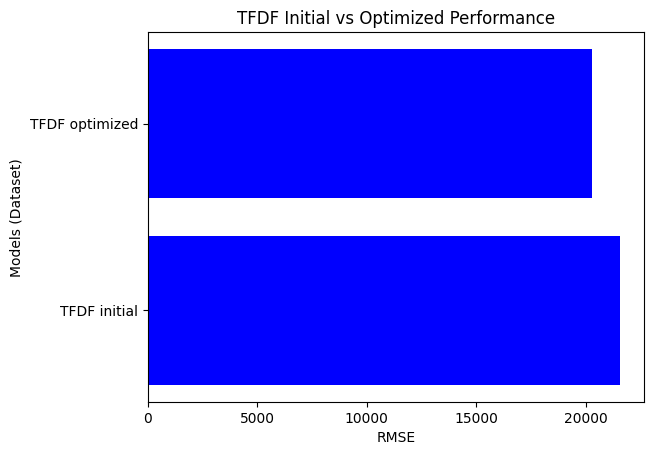

In [81]:
plot(final_dict)